In [1]:
include("../src/Kitaev.jl")
using .my_Kitaev
using PyPlot
using DelimitedFiles
using ProgressMeter
using Yao
#using YaoExtensions
using LinearAlgebra

In [2]:
Lx = 1
Lz = 1
BC = 1
J = 1.0
hz = 0.0
const GPU_enabled = "no"

"no"

# Calculate GS for zero magnetic field using VQE

First prepare inital (symmetry-preserving) state

In [3]:
n,Jxyz,hmagn,h,ham,ham_norm,kappa=output_ham_properties(Lx, Lz, BC, J, hz, 3)
w, plaq_seq, vtot = getstabilizers(Lx, Lz, BC, n);
LXverts, LZverts = getlogicstrings(plaq_seq,Lx,Lz);
println("n=$(n),J = $(J), h=$(hmagn)")
print_vqe = false
ansatz = 2 # choose ansatz
choose_optimizer = "ADAM" # choose "GD" or "ADAM" for optimizer
useparams = 0
learning_rate = 0.08
niter = 500;
num_vortices = 0
if n == 8
    num_vortices = 4
end
print_initial = false # choose if want to print properties of initial state (takes time for large system)
ψ = prepare_inital_state(n, num_vortices, plaq_seq, LXverts, LZverts, print_initial, GPU_enabled,Lx,Lz,BC)

We consider n = 8 qubits
n=8,J = 1.0, h=[0.0, 0.0, 0.0]
 >>exc>> 5 Y 
 >>exc>> 7 Y 


ArrayReg{2, ComplexF64, Array...}
    active qubits: 8/8
    nlevel: 2

Now perform VQE

In [4]:
psitg = trueground(copy(ψ),h,n)
Eground = real(expect(h,psitg))

0.0

In [5]:
#N=8, trueground function doesn't work, try get_spectrum 
energies, vectors = get_spectrum(h, false) #find true GS and GS energy
psitg = ArrayReg(convert(Vector{ComplexF64}, vectors[1]))
Eground = energies[1]

-6.928203230275499

In [6]:
depth = 1
circuit, Energies_vqe, Fidelities_vqe, en_min, fid_en_min, params_min = perform_vqe(n, ψ, depth, niter, learning_rate, ansatz, choose_optimizer, print_vqe, GPU_enabled, useparams,h,Lx,Lz,BC,psitg)

Starting VQE procedure...
make it visible
  * * * * *   seed = 4849177368310094093
Step 0, energy = 3.1642670973426825, fidelity = 0.24462071076414688
 *** Step 1, energy = 1.9860816005517172, fidelity = 0.3207266216076694
 *** Step 2, energy = 0.8485596793950578, fidelity = 0.39738597839353673
 *** Step 3, energy = -0.20926223930248744, fidelity = 0.47501082800380307
 *** Step 4, energy = -1.0880132768425397, fidelity = 0.5450282014385084
 *** Step 5, energy = -1.7210200903087745, fidelity = 0.5978725900360037
 *** Step 6, energy = -2.1393972129873515, fidelity = 0.6337929921513652
 *** Step 7, energy = -2.4186534181447796, fidelity = 0.6580479305035123
 *** Step 8, energy = -2.640931031395517, fidelity = 0.6761852884670403
 *** Step 9, energy = -2.858555605838271, fidelity = 0.6921145941571623
 *** Step 10, energy = -3.08553746767649, fidelity = 0.708211412149666
 *** Step 11, energy = -3.3201402332245786, fidelity = 0.7258598479315997
 *** Step 12, energy = -3.5551311833511368, fide

(nqubits: 8
chain
├─ repeat on (1, 2, 3, 4, 5, 6, 7, 8)
│  └─ H
├─ chain
│  ├─ control(2)
│  │  └─ (3,) X
│  ├─ control(6)
│  │  └─ (7,) X
│  ├─ control(4)
│  │  └─ (1,) X
│  └─ control(8)
│     └─ (5,) X
├─ chain
│  ├─ put on (3)
│  │  └─ rot(Z, 5.634750392301744)
│  ├─ put on (7)
│  │  └─ rot(Z, 5.019270683623565)
│  ├─ put on (1)
│  │  └─ rot(Z, 2.5872979682372685)
│  └─ put on (5)
│     └─ rot(Z, 6.344370330497539)
├─ chain
│  ├─ control(2)
│  │  └─ (3,) X
│  ├─ control(6)
│  │  └─ (7,) X
│  ├─ control(4)
│  │  └─ (1,) X
│  └─ control(8)
│     └─ (5,) X
├─ repeat on (1, 2, 3, 4, 5, 6, 7, 8)
│  └─ H
├─ repeat on (1, 2, 3, 4, 5, 6, 7, 8)
│  └─  [†]S
├─ repeat on (1, 2, 3, 4, 5, 6, 7, 8)
│  └─ H
├─ chain
│  ├─ control(1)
│  │  └─ (2,) X
│  ├─ control(3)
│  │  └─ (4,) X
│  ├─ control(5)
│  │  └─ (6,) X
│  └─ control(7)
│     └─ (8,) X
├─ chain
│  ├─ put on (2)
│  │  └─ rot(Z, 5.594131833153427)
│  ├─ put on (4)
│  │  └─ rot(Z, 0.09634468937568443)
│  ├─ put on (6)
│  │  └─ rot(Z, 3.830

# QFD for non-zero magnetic field GSP

In [4]:
Lx = 1
Lz = 1
BC = 1
J = -1.0
hz = 0.1
n_l = 1
n_k = 2
r=5
n_l2 = 1
n_k2 = 2
r2=5
nkryl = 100
z = 0.5-0.01im
order = 2
type = 1 #Type 1: magnetic field in z direction. Type 2: uniform magnetic field
global α = 2
global β = 2
global γ = 3
n,Jxyz,hmagn,h,ham,ham_norm,kappa=output_ham_properties(Lx, Lz, BC, J, hz, type);

We consider n = 8 qubits


In [5]:
ev,GSE,GS,coeffs,vecs = find_GS_QFD(Lx,Lz,BC,J,hz,2,2,type)

We consider n = 8 qubits
Eground = -0.12649730863600686
 >>exc>> 5 Y 
 >>exc>> 7 Y 
n_k,n_l =(2, 2)
 Smat Pos-def? true
 Hmat Hermitian? true
-0.12649730863594183


(3.6163959722417815e-12, -7.03452431839218, ArrayReg{2, ComplexF64, Array...}
    active qubits: 8/8
    nlevel: 2, ComplexF64[0.05977428812009253 - 0.2269553861551473im, -0.27850599777699514 + 0.01226253484795951im, 0.04950491484970558 + 0.07666716961045217im, -0.028605985826619336 - 0.08103382665450652im, -0.2273613906970908 + 0.05865213283682329im, 0.01170652356852048 + 0.11736477450322311im, 0.0644627788825165 - 0.05126266724493082im, -0.12750677801512286 + 0.040169763393470496im, 0.021903986840178673 + 0.18010543582871913im, 0.13333186128422453 + 0.008543747204280626im, -0.0748095686672827 - 0.034415849998453256im, 0.016724133644217463 + 0.11667827612423008im, 0.23479226628680017 + 0.00263289116572505im, 0.008438608535422661 - 0.08555017640316058im, -0.029781732195744863 + 0.0862327337055583im, 0.2733067591970147 - 0.05461638129890259im, -0.11232562594484395 - 0.20619811165642973im], ArrayReg[ArrayReg{2, ComplexF64, Array...}
    active qubits: 8/8
    nlevel: 2, ArrayReg{2, Compl

In [ ]:
#Fix n_k, increase n_l
nk0 = map(i->find_GS_QFD(Lx,Lz,BC,J,hz,i,0,type)[1],0:5);
nk1 = map(i->find_GS_QFD(Lx,Lz,BC,J,hz,i,1,type)[1],0:5);
nk2 = map(i->find_GS_QFD(Lx,Lz,BC,J,hz,i,2,type)[1],0:5);
nk3 = map(i->find_GS_QFD(Lx,Lz,BC,J,hz,i,3,type)[1],0:5);
nk4 = map(i->find_GS_QFD(Lx,Lz,BC,J,hz,i,4,type)[1],0:5);
nk5 = map(i->find_GS_QFD(Lx,Lz,BC,J,hz,i,5,type)[1],0:5);

We consider n = 8 qubits
Eground = -0.12649730863600686
 >>exc>> 5 Y 
 >>exc>> 7 Y 
n_k,n_l =(0, 0)


┌ Info: Lanczos eigsolve finished after 1 iterations:
│ *  7 eigenvalues converged
│ *  norm of residuals = (1.009577510373966e-45, 0.0, 0.0, 0.0, 1.2674045339733898e-15, 1.4820604454830426e-13, 2.398524102132149e-13)
│ *  number of operations = 128
└ @ KrylovKit C:\Users\chidd\.julia\packages\KrylovKit\diNbc\src\eigsolve\lanczos.jl:143


 Smat Pos-def? true
 Hmat Hermitian? true
-0.12458540515958083


We consider n = 8 qubits
Eground = -0.12649730863600686
 >>exc>> 5 Y 
 >>exc>> 7 Y 
n_k,n_l =(0, 1)


┌ Info: Lanczos eigsolve finished after 1 iterations:
│ *  7 eigenvalues converged
│ *  norm of residuals = (5.649229848580267e-46, 0.0, 0.0, 0.0, 5.277988745550599e-16, 3.733825564364914e-14, 6.348552806067881e-14)
│ *  number of operations = 128
└ @ KrylovKit C:\Users\chidd\.julia\packages\KrylovKit\diNbc\src\eigsolve\lanczos.jl:143


 Smat Pos-def? true
 Hmat Hermitian? true
-0.1262205188329789


We consider n = 8 qubits
Eground = -0.12649730863600686
 >>exc>> 5 Y 
 >>exc>> 7 Y 
n_k,n_l =(0, 2)


┌ Info: Lanczos eigsolve finished after 1 iterations:
│ *  7 eigenvalues converged
│ *  norm of residuals = (7.976884734742724e-46, 0.0, 0.0, 0.0, 7.985520992207727e-16, 2.7930909971862352e-14, 7.931338250852279e-14)
│ *  number of operations = 128
└ @ KrylovKit C:\Users\chidd\.julia\packages\KrylovKit\diNbc\src\eigsolve\lanczos.jl:143


 Smat Pos-def? true
 Hmat Hermitian? true
-0.1264639530724069
We consider n = 8 qubits
Eground = -0.12649730863600686
 >>exc>> 5 Y 
 >>exc>> 7 Y 
n_k,n_l =(0, 3)
 Smat Pos-def? 

┌ Info: Lanczos eigsolve finished after 1 iterations:
│ *  7 eigenvalues converged
│ *  norm of residuals = (2.26834263898331e-45, 0.0, 0.0, 0.0, 8.070089783074425e-15, 1.8239134142017342e-13, 4.3050386621057046e-13)
│ *  number of operations = 128
└ @ KrylovKit C:\Users\chidd\.julia\packages\KrylovKit\diNbc\src\eigsolve\lanczos.jl:143


true
 Hmat Hermitian? true
-0.1264966198661191
We consider n = 8 qubits


Eground = -0.12649730863600686
 >>exc>> 5 Y 
 >>exc>> 7 Y 
n_k,n_l =(0, 4)


┌ Info: Lanczos eigsolve finished after 1 iterations:
│ *  7 eigenvalues converged
│ *  norm of residuals = (1.1095549422201417e-45, 0.0, 0.0, 0.0, 9.231945868123853e-16, 5.3775485945618205e-14, 1.9073024043149252e-13)
│ *  number of operations = 128
└ @ KrylovKit C:\Users\chidd\.julia\packages\KrylovKit\diNbc\src\eigsolve\lanczos.jl:143


 Smat Pos-def? true
 Hmat Hermitian? true
-0.12649730777287532
We consider n = 8 qubits
Eground = -0.1264973086360069
 >>exc>> 5 Y 
 >>exc>> 7 Y 

┌ Info: Lanczos eigsolve finished after 1 iterations:
│ *  7 eigenvalues converged
│ *  norm of residuals = (1.1182789199101822e-45, 0.0, 0.0, 0.0, 6.429494506365125e-16, 3.260971244842915e-14, 9.988461311101621e-14)
│ *  number of operations = 128
└ @ KrylovKit C:\Users\chidd\.julia\packages\KrylovKit\diNbc\src\eigsolve\lanczos.jl:143



n_k,n_l =(0, 5)


 Smat Pos-def? true
 Hmat Hermitian? true
-0.12649730862058908


We consider n = 8 qubits
Eground = -0.12649730863600686
 >>exc>> 5 Y 
 >>exc>> 7 Y 
n_k,n_l =(1, 0)


┌ Info: Lanczos eigsolve finished after 1 iterations:
│ *  7 eigenvalues converged
│ *  norm of residuals = (6.280922656388422e-46, 0.0, 0.0, 0.0, 9.468758821821246e-16, 1.026914896688157e-13, 7.048018555935337e-14)
│ *  number of operations = 128
└ @ KrylovKit C:\Users\chidd\.julia\packages\KrylovKit\diNbc\src\eigsolve\lanczos.jl:143


 Smat Pos-def? true
 Hmat Hermitian? true
-0.1262205188329789
We consider n = 8 qubits
Eground = -0.12649730863600686
 >>exc>> 5 Y 
 >>exc>> 7 Y 
n_k,n_l =(1, 1)


┌ Info: Lanczos eigsolve finished after 1 iterations:
│ *  7 eigenvalues converged
│ *  norm of residuals = (1.509651187571987e-45, 0.0, 0.0, 0.0, 1.4483909551669205e-15, 3.760473052703698e-14, 1.3705994805335465e-13)
│ *  number of operations = 128
└ @ KrylovKit C:\Users\chidd\.julia\packages\KrylovKit\diNbc\src\eigsolve\lanczos.jl:143


 Smat Pos-def? true
 Hmat Hermitian? true
-0.1264966198661191
We consider n = 8 qubits
Eground = -0.12649730863600686
 >>exc>> 5 Y 
 >>exc>> 7 Y 
n_k,n_l =(1, 2)


┌ Info: Lanczos eigsolve finished after 1 iterations:
│ *  7 eigenvalues converged
│ *  norm of residuals = (8.465398926240472e-46, 0.0, 0.0, 0.0, 1.0684529440410322e-15, 1.2130592000890087e-13, 1.014117827885659e-13)
│ *  number of operations = 128
└ @ KrylovKit C:\Users\chidd\.julia\packages\KrylovKit\diNbc\src\eigsolve\lanczos.jl:143


 Smat Pos-def? true
 Hmat Hermitian? true
-0.12649730862058908
We consider n = 8 qubits


Eground = -0.1264973086360069
 >>exc>> 5 Y 
 >>exc>> 7 Y 
n_k,n_l =(1, 3)


┌ Info: Lanczos eigsolve finished after 1 iterations:
│ *  10 eigenvalues converged
│ *  norm of residuals = (4.1099537876668524e-46, 0.0, 0.0, 0.0, 3.82021923130845e-16, 1.454935093088295e-14, 9.255283122438319e-14, 8.429850122887001e-13, 0.0, 5.994950423713816e-14)
│ *  number of operations = 128
└ @ KrylovKit C:\Users\chidd\.julia\packages\KrylovKit\diNbc\src\eigsolve\lanczos.jl:143


 Smat Pos-def? true
 Hmat Hermitian? true
-0.12649730863584524


We consider n = 8 qubits
Eground = -0.1264973086360069
 >>exc>> 5 Y 
 >>exc>> 7 Y 
n_k,n_l =(1, 4)


┌ Info: Lanczos eigsolve finished after 1 iterations:
│ *  7 eigenvalues converged
│ *  norm of residuals = (8.289118555459727e-46, 0.0, 0.0, 0.0, 1.3335606390164798e-15, 5.280685231895717e-14, 1.5202244764573868e-13)
│ *  number of operations = 128
└ @ KrylovKit C:\Users\chidd\.julia\packages\KrylovKit\diNbc\src\eigsolve\lanczos.jl:143


 Smat Pos-def? true
 Hmat Hermitian? true
-0.12649730863597494


We consider n = 8 qubits
Eground = -0.12649730863600686
 >>exc>> 5 Y 
 >>exc>> 7 Y 


┌ Info: Lanczos eigsolve finished after 1 iterations:
│ *  7 eigenvalues converged
│ *  norm of residuals = (9.533738725514597e-46, 0.0, 0.0, 0.0, 1.029342998484826e-15, 5.146326632839366e-14, 7.364412674996709e-13)
│ *  number of operations = 128
└ @ KrylovKit C:\Users\chidd\.julia\packages\KrylovKit\diNbc\src\eigsolve\lanczos.jl:143


n_k,n_l =(1, 5)


 Smat Pos-def? true
 Hmat Hermitian? true
-0.12649730863599157


We consider n = 8 qubits
Eground = -0.1264973086360069
 >>exc>> 5 Y 
 >>exc>> 7 Y 
n_k,n_l =(2, 0)


┌ Info: Lanczos eigsolve finished after 1 iterations:
│ *  7 eigenvalues converged
│ *  norm of residuals = (7.553999097031034e-46, 0.0, 0.0, 0.0, 6.020986717177652e-16, 2.080625524460748e-14, 5.490604247940528e-14)
│ *  number of operations = 128
└ @ KrylovKit C:\Users\chidd\.julia\packages\KrylovKit\diNbc\src\eigsolve\lanczos.jl:143


 Smat Pos-def? true
 Hmat Hermitian? true
-0.1264639530724069
We consider n = 8 qubits


Eground = -0.12649730863600686
 >>exc>> 5 Y 
 >>exc>> 7 Y 
n_k,n_l =(2, 1)


┌ Info: Lanczos eigsolve finished after 1 iterations:
│ *  7 eigenvalues converged
│ *  norm of residuals = (6.791885757690112e-46, 0.0, 0.0, 0.0, 1.3397266549000328e-15, 9.687002798439569e-14, 1.1962787622562118e-13)
│ *  number of operations = 128
└ @ KrylovKit C:\Users\chidd\.julia\packages\KrylovKit\diNbc\src\eigsolve\lanczos.jl:143


 Smat Pos-def? true
 Hmat Hermitian? true
-0.12649730862058908
We consider n = 8 qubits


Eground = -0.12649730863600686
 >>exc>> 5 Y 
 >>exc>> 7 Y 
n_k,n_l =(2, 2)

┌ Info: Lanczos eigsolve finished after 1 iterations:
│ *  7 eigenvalues converged
│ *  norm of residuals = (5.4215513949187435e-46, 0.0, 0.0, 0.0, 5.381157519934772e-16, 2.417414388954188e-14, 2.6504850353720556e-13)
│ *  number of operations = 128
└ @ KrylovKit C:\Users\chidd\.julia\packages\KrylovKit\diNbc\src\eigsolve\lanczos.jl:143



 Smat Pos-def? true
 Hmat Hermitian? true
-0.12649730863594177
We consider n = 8 qubits


Eground = -0.12649730863600686
 >>exc>> 5 Y 
 >>exc>> 7 Y 
n_k,n_l =(2, 3)


┌ Info: Lanczos eigsolve finished after 1 iterations:
│ *  7 eigenvalues converged
│ *  norm of residuals = (1.2882263984772027e-45, 0.0, 0.0, 0.0, 1.3463784063828502e-15, 4.5580453796180746e-14, 1.4788976653758245e-13)
│ *  number of operations = 128
└ @ KrylovKit C:\Users\chidd\.julia\packages\KrylovKit\diNbc\src\eigsolve\lanczos.jl:143


 Smat Pos-def? true
 Hmat Hermitian? true
-0.12649730863599157
We consider n = 8 qubits


Eground = -0.12649730863600686
 >>exc>> 5 Y 
 >>exc>> 7 Y 
n_k,n_l =(2, 4)


┌ Info: Lanczos eigsolve finished after 1 iterations:
│ *  7 eigenvalues converged
│ *  norm of residuals = (5.039484469597344e-46, 0.0, 0.0, 0.0, 5.837376111379597e-16, 2.7864308781549176e-14, 1.6376115122489342e-13)
│ *  number of operations = 128
└ @ KrylovKit C:\Users\chidd\.julia\packages\KrylovKit\diNbc\src\eigsolve\lanczos.jl:143


 Smat Pos-def? true
 Hmat Hermitian? true
-0.12649730863599862


We consider n = 8 qubits
Eground = -0.12649730863600686
 >>exc>> 5 Y 
 >>exc>> 7 Y 
n_k,n_l =(2, 5)

┌ Info: Lanczos eigsolve finished after 1 iterations:
│ *  7 eigenvalues converged
│ *  norm of residuals = (7.769212841683297e-46, 0.0, 0.0, 0.0, 8.806160535110848e-16, 6.256421503811168e-14, 8.299823159445368e-14)
│ *  number of operations = 128
└ @ KrylovKit C:\Users\chidd\.julia\packages\KrylovKit\diNbc\src\eigsolve\lanczos.jl:143



 Smat Pos-def? true
 Hmat Hermitian? true
-0.12649730863600134


We consider n = 8 qubits
Eground = -0.1264973086360069
 >>exc>> 5 Y 
 >>exc>> 7 Y 
n_k,n_l =(3, 0)

┌ Info: Lanczos eigsolve finished after 1 iterations:
│ *  7 eigenvalues converged
│ *  norm of residuals = (4.6655838859356736e-46, 0.0, 0.0, 0.0, 9.202704969186418e-16, 1.4170525807773962e-14, 7.515394807643565e-14)
│ *  number of operations = 128
└ @ KrylovKit C:\Users\chidd\.julia\packages\KrylovKit\diNbc\src\eigsolve\lanczos.jl:143



 Smat Pos-def? true
 Hmat Hermitian? true
-0.1264966198661191


We consider n = 8 qubits
Eground = -0.12649730863600686
 >>exc>> 5 Y 
 >>exc>> 7 Y 
n_k,n_l =(3, 1)


┌ Info: Lanczos eigsolve finished after 1 iterations:
│ *  7 eigenvalues converged
│ *  norm of residuals = (4.683221758917275e-46, 0.0, 0.0, 0.0, 1.904143066048012e-15, 8.438586915664817e-14, 1.482100004941082e-13)
│ *  number of operations = 128
└ @ KrylovKit C:\Users\chidd\.julia\packages\KrylovKit\diNbc\src\eigsolve\lanczos.jl:143


 Smat Pos-def? true
 Hmat Hermitian? true
-0.12649730863584524
We consider n = 8 qubits


Eground = -0.12649730863600686
 >>exc>> 5 Y 
 >>exc>> 7 Y 
n_k,n_l =(3, 2)


┌ Info: Lanczos eigsolve finished after 1 iterations:
│ *  7 eigenvalues converged
│ *  norm of residuals = (8.129784798393266e-46, 0.0, 0.0, 0.0, 1.16950389855339e-15, 4.938828541042626e-14, 1.2618529860424344e-13)
│ *  number of operations = 128
└ @ KrylovKit C:\Users\chidd\.julia\packages\KrylovKit\diNbc\src\eigsolve\lanczos.jl:143


 Smat Pos-def? true
 Hmat Hermitian? true
-0.12649730863599157
We consider n = 8 qubits


Eground = -0.1264973086360069
 >>exc>> 5 Y 
 >>exc>> 7 Y 
n_k,n_l =(3, 3)


┌ Info: Lanczos eigsolve finished after 1 iterations:
│ *  7 eigenvalues converged
│ *  norm of residuals = (1.0197521334828329e-45, 0.0, 0.0, 0.0, 8.19742614531548e-16, 4.441703158619737e-14, 1.2360189720301463e-13)
│ *  number of operations = 128
└ @ KrylovKit C:\Users\chidd\.julia\packages\KrylovKit\diNbc\src\eigsolve\lanczos.jl:143


 Smat Pos-def? true
 Hmat Hermitian? true
-0.1264973086359998


We consider n = 8 qubits
Eground = -0.12649730863600686
 >>exc>> 5 Y 
 >>exc>> 7 Y 
n_k,n_l =(3, 4)


┌ Info: Lanczos eigsolve finished after 1 iterations:
│ *  7 eigenvalues converged
│ *  norm of residuals = (6.365028485116389e-46, 0.0, 0.0, 0.0, 1.8213583538822397e-15, 1.2174957834507674e-13, 1.8274416499721875e-13)
│ *  number of operations = 128
└ @ KrylovKit C:\Users\chidd\.julia\packages\KrylovKit\diNbc\src\eigsolve\lanczos.jl:143


 Smat Pos-def? true
 Hmat Hermitian? true
-0.12649730863600256
We consider n = 8 qubits


Eground = -0.12649730863600686
 >>exc>> 5 Y 
 >>exc>> 7 Y 
n_k,n_l =(3, 5)

┌ Info: Lanczos eigsolve finished after 1 iterations:
│ *  7 eigenvalues converged
│ *  norm of residuals = (7.185039327224374e-46, 0.0, 0.0, 0.0, 1.5620020148537596e-15, 7.553581022617857e-14, 1.3364288262359984e-13)
│ *  number of operations = 128
└ @ KrylovKit C:\Users\chidd\.julia\packages\KrylovKit\diNbc\src\eigsolve\lanczos.jl:143



 Smat Pos-def? true
 Hmat Hermitian? true
-0.1264973086360039


We consider n = 8 qubits
Eground = -0.12649730863600686
 >>exc>> 5 Y 
 >>exc>> 7 Y 
n_k,n_l =(4, 0)

┌ Info: Lanczos eigsolve finished after 1 iterations:
│ *  7 eigenvalues converged
│ *  norm of residuals = (4.459648858916899e-46, 0.0, 0.0, 0.0, 6.581492141776243e-16, 1.6349027859963396e-14, 1.070720209150712e-13)
│ *  number of operations = 128
└ @ KrylovKit C:\Users\chidd\.julia\packages\KrylovKit\diNbc\src\eigsolve\lanczos.jl:143



 Smat Pos-def? true
 Hmat Hermitian? true
-0.12649730777287532
We consider n = 8 qubits


┌ Info: Lanczos eigsolve finished after 1 iterations:
│ *  7 eigenvalues converged
│ *  norm of residuals = (9.098348639591209e-46, 0.0, 0.0, 0.0, 2.3711916815850297e-15, 2.925637684267606e-13, 3.251237471096781e-13)
│ *  number of operations = 128
└ @ KrylovKit C:\Users\chidd\.julia\packages\KrylovKit\diNbc\src\eigsolve\lanczos.jl:143


Eground = -0.12649730863600686
 >>exc>> 5 Y 
 >>exc>> 7 Y 
n_k,n_l =(4, 1)


 Smat Pos-def? true
 Hmat Hermitian? true
-0.12649730863597494
We consider n = 8 qubits
Eground = -0.12649730863600686
 >>exc>> 5 Y 
 >>exc>> 7 Y 
n_k,n_l =(4, 2)

┌ Info: Lanczos eigsolve finished after 1 iterations:
│ *  7 eigenvalues converged
│ *  norm of residuals = (6.6718195246749055e-46, 0.0, 0.0, 0.0, 1.1915826259020593e-15, 1.5475591758918013e-14, 1.0594112654249234e-13)
│ *  number of operations = 128
└ @ KrylovKit C:\Users\chidd\.julia\packages\KrylovKit\diNbc\src\eigsolve\lanczos.jl:143



 Smat Pos-def? true
 Hmat Hermitian? true
-0.12649730863599862


We consider n = 8 qubits
Eground = -0.12649730863600686
 >>exc>> 5 Y 
 >>exc>> 7 Y 
n_k,n_l =(4, 3)

┌ Info: Lanczos eigsolve finished after 1 iterations:
│ *  7 eigenvalues converged
│ *  norm of residuals = (9.311722739807976e-46, 0.0, 0.0, 0.0, 7.468950087087581e-16, 3.08208994411075e-14, 2.2460488711374916e-13)
│ *  number of operations = 128
└ @ KrylovKit C:\Users\chidd\.julia\packages\KrylovKit\diNbc\src\eigsolve\lanczos.jl:143



 Smat Pos-def? true
 Hmat Hermitian? true
-0.1264973086360026


We consider n = 8 qubits
Eground = -0.12649730863600686
 >>exc>> 5 Y 
 >>exc>> 7 Y 
n_k,n_l =(4, 4)

┌ Info: Lanczos eigsolve finished after 1 iterations:
│ *  7 eigenvalues converged
│ *  norm of residuals = (8.26083072365897e-46, 0.0, 0.0, 0.0, 1.8651728978016152e-15, 6.878454158889158e-13, 1.1162630094700007e-13)
│ *  number of operations = 128
└ @ KrylovKit C:\Users\chidd\.julia\packages\KrylovKit\diNbc\src\eigsolve\lanczos.jl:143



 Smat Pos-def? 

true
 Hmat Hermitian? true
-0.12649730863600403


We consider n = 8 qubits


┌ Info: Lanczos eigsolve finished after 1 iterations:
│ *  7 eigenvalues converged
│ *  norm of residuals = (6.898815929692021e-46, 0.0, 0.0, 0.0, 3.760207454835832e-16, 4.3269569217145725e-14, 1.3502343194293093e-13)
│ *  number of operations = 128
└ @ KrylovKit C:\Users\chidd\.julia\packages\KrylovKit\diNbc\src\eigsolve\lanczos.jl:143


Eground = -0.12649730863600686
 >>exc>> 5 Y 
 >>exc>> 7 Y 
n_k,n_l =(4, 5)


 Smat Pos-def? true
 Hmat Hermitian? true
-0.12649730863600453


We consider n = 8 qubits
Eground = -0.1264973086360069
 >>exc>> 5 Y 
 >>exc>> 7 Y 
n_k,n_l =(5, 0)


┌ Info: Lanczos eigsolve finished after 1 iterations:
│ *  7 eigenvalues converged
│ *  norm of residuals = (7.824653742126988e-46, 0.0, 0.0, 0.0, 1.1877222908493617e-15, 8.627928353383262e-14, 9.952114598387605e-14)
│ *  number of operations = 128
└ @ KrylovKit C:\Users\chidd\.julia\packages\KrylovKit\diNbc\src\eigsolve\lanczos.jl:143


 Smat Pos-def? true
 Hmat Hermitian? true
-0.12649730862058908
We consider n = 8 qubits


Eground = -0.12649730863600686
 >>exc>> 5 Y 
 >>exc>> 7 Y 
n_k,n_l =(5, 1)


┌ Info: Lanczos eigsolve finished after 1 iterations:
│ *  7 eigenvalues converged
│ *  norm of residuals = (6.2159762944658214e-46, 0.0, 0.0, 0.0, 9.867759977575534e-16, 9.559583869157575e-14, 6.83213128978608e-14)
│ *  number of operations = 128
└ @ KrylovKit C:\Users\chidd\.julia\packages\KrylovKit\diNbc\src\eigsolve\lanczos.jl:143


 Smat Pos-def? true
 Hmat Hermitian? true
-0.12649730863599157
We consider n = 8 qubits
Eground = -0.12649730863600686
 >>exc>> 5 Y 
 >>exc>> 7 Y 
n_k,n_l =(5, 2)


┌ Info: Lanczos eigsolve finished after 1 iterations:
│ *  10 eigenvalues converged
│ *  norm of residuals = (5.7271474834912565e-46, 0.0, 0.0, 0.0, 9.04092321137989e-16, 5.646074287952657e-14, 1.5671578846159986e-13, 9.521477037278589e-13, 0.0, 1.7047046230489454e-14)
│ *  number of operations = 128
└ @ KrylovKit C:\Users\chidd\.julia\packages\KrylovKit\diNbc\src\eigsolve\lanczos.jl:143


 Smat Pos-def? true
 Hmat Hermitian? true
-0.12649730863600142
We consider n = 8 qubits


Eground = -0.1264973086360069
 >>exc>> 5 Y 
 >>exc>> 7 Y 
n_k,n_l =(5, 3)


┌ Info: Lanczos eigsolve finished after 1 iterations:
│ *  7 eigenvalues converged
│ *  norm of residuals = (8.143013996405299e-46, 0.0, 0.0, 0.0, 6.474445969971286e-16, 2.0536047946201158e-14, 1.7339730735506527e-13)
│ *  number of operations = 128
└ @ KrylovKit C:\Users\chidd\.julia\packages\KrylovKit\diNbc\src\eigsolve\lanczos.jl:143


 Smat Pos-def? true
 Hmat Hermitian? true
-0.1264973086360039


We consider n = 8 qubits
Eground = -0.12649730863600686
 >>exc>> 5 Y 
 >>exc>> 7 Y 
n_k,n_l =(5, 4)

┌ Info: Lanczos eigsolve finished after 1 iterations:
│ *  7 eigenvalues converged
│ *  norm of residuals = (6.309479283547208e-46, 0.0, 0.0, 0.0, 6.714903380274074e-16, 3.5966024361820823e-14, 1.3427561379006624e-13)
│ *  number of operations = 128
└ @ KrylovKit C:\Users\chidd\.julia\packages\KrylovKit\diNbc\src\eigsolve\lanczos.jl:143



 Smat Pos-def? true
 Hmat Hermitian? true
-0.12649730863600447


We consider n = 8 qubits
Eground = -0.12649730863600686
 >>exc>> 5 Y 
 >>exc>> 7 Y 
n_k,n_l =(5, 5)

┌ Info: Lanczos eigsolve finished after 1 iterations:
│ *  7 eigenvalues converged
│ *  norm of residuals = (1.2151335334061566e-45, 0.0, 0.0, 0.0, 1.3890708779239776e-15, 5.523361517354665e-14, 6.417694710395389e-13)
│ *  number of operations = 128
└ @ KrylovKit C:\Users\chidd\.julia\packages\KrylovKit\diNbc\src\eigsolve\lanczos.jl:143



 Smat Pos-def? true
 Hmat Hermitian? true
-0.12649730863600483


In [ ]:
open("./data/N=$(n)_h=$(hz)_J=$(J)_fix_n_k.dat", "a") do io
    writedlm(io, [nk0,nk1,nk2,nk3,nk4,nk5])
end

In [ ]:
#Increase number of basis states for different hs
nk_nl=[[0,0],[1,0],[2,0],[1,1],[4,0],[2,1],[6,0],[3,1],[2,2],[4,1],[10,0],[3,2],[12,0],[6,1],[4,2],[3,3],[16,0],[5,2]];

In [ ]:
n_basis = [2*(i[1]+1)*(i[2]+1)-1 for i in nk_nl];

In [ ]:
h1 = map(i->find_GS_QFD(Lx,Lz,BC,J,0.1,nk_nl[i][2],nk_nl[i][1],type)[1],1:length(nk_nl))
h2 = map(i->find_GS_QFD(Lx,Lz,BC,J,0.2,nk_nl[i][2],nk_nl[i][1],type)[1],1:length(nk_nl))
h3 = map(i->find_GS_QFD(Lx,Lz,BC,J,0.3,nk_nl[i][2],nk_nl[i][1],type)[1],1:length(nk_nl))
h4 = map(i->find_GS_QFD(Lx,Lz,BC,J,0.4,nk_nl[i][2],nk_nl[i][1],type)[1],1:length(nk_nl))
h5 = map(i->find_GS_QFD(Lx,Lz,BC,J,0.5,nk_nl[i][2],nk_nl[i][1],type)[1],1:length(nk_nl))

We consider n = 8 qubits
Eground = -0.12469873020765168
 >>exc>> 5 Y 

┌ Info: Lanczos eigsolve finished after 1 iterations:
│ *  5 eigenvalues converged
│ *  norm of residuals = (2.4972368926971053e-46, 0.0, 0.0, 0.0, 1.76140789122571e-14)
│ *  number of operations = 128
└ @ KrylovKit C:\Users\chidd\.julia\packages\KrylovKit\diNbc\src\eigsolve\lanczos.jl:143



 >>exc>> 7 Y 
n_k,n_l =(0, 0)
 Smat Pos-def? true
 Hmat Hermitian? true
-0.1245854051595808
We consider n = 8 qubits


┌ Info: Lanczos eigsolve finished after 1 iterations:
│ *  5 eigenvalues converged
│ *  norm of residuals = (3.2384668585875147e-46, 0.0, 0.0, 0.0, 2.15151177546737e-15)
│ *  number of operations = 128
└ @ KrylovKit C:\Users\chidd\.julia\packages\KrylovKit\diNbc\src\eigsolve\lanczos.jl:143


Eground = -0.12469873020765174
 >>exc>> 5 Y 
 >>exc>> 7 Y 
n_k,n_l =(1, 0)
 Smat Pos-def? true
 Hmat Hermitian? true
-0.1246970984073261


We consider n = 8 qubits
Eground = -0.12469873020765179
 >>exc>> 5 Y 
 >>exc>> 7 Y 
n_k,n_l =(2, 0)


┌ Info: Lanczos eigsolve finished after 1 iterations:
│ *  5 eigenvalues converged
│ *  norm of residuals = (1.6266183010720123e-46, 0.0, 0.0, 0.0, 1.3527379027369414e-15)
│ *  number of operations = 128
└ @ KrylovKit C:\Users\chidd\.julia\packages\KrylovKit\diNbc\src\eigsolve\lanczos.jl:143


 Smat Pos-def? true
 Hmat Hermitian? true
-0.1246982023252816


We consider n = 8

 qubits


┌ Info: Lanczos eigsolve finished after 1 iterations:
│ *  5 eigenvalues converged
│ *  norm of residuals = (2.0066276907529457e-46, 0.0, 0.0, 0.0, 7.816347620790426e-15)
│ *  number of operations = 128
└ @ KrylovKit C:\Users\chidd\.julia\packages\KrylovKit\diNbc\src\eigsolve\lanczos.jl:143


Eground = -0.12469873020765174
 >>exc>> 5 Y 
 >>exc>> 7 Y 
n_k,n_l =(1, 1)


 Smat Pos-def? true
 Hmat Hermitian? true
-0.12469871199937844
We consider n = 8 qubits
Eground = -0.12469873020765174
 >>exc>> 5 Y 
 >>exc>> 7 Y 
n_k,n_l =(4, 0)


┌ Info: Lanczos eigsolve finished after 1 iterations:
│ *  5 eigenvalues converged
│ *  norm of residuals = (2.0608036991531758e-46, 0.0, 0.0, 0.0, 6.151754516986703e-14)
│ *  number of operations = 128
└ @ KrylovKit C:\Users\chidd\.julia\packages\KrylovKit\diNbc\src\eigsolve\lanczos.jl:143


 Smat Pos-def? true
 Hmat Hermitian? true
-0.12469873019905123
We consider n = 8 qubits
Eground = -0.12469873020765179
 >>exc>> 5 Y 
 >>exc>> 7 Y 
n_k,n_l =(2, 1)

┌ Info: Lanczos eigsolve finished after 1 iterations:
│ *  5 eigenvalues converged
│ *  norm of residuals = (2.9124132935321048e-46, 0.0, 0.0, 0.0, 3.923070470307387e-15)
│ *  number of operations = 128
└ @ KrylovKit C:\Users\chidd\.julia\packages\KrylovKit\diNbc\src\eigsolve\lanczos.jl:143



 Smat Pos-def? true
 Hmat Hermitian? true
-0.12469873020721492
We consider n = 8 qubits
Eground = -0.12469873020765168
 >>exc>> 5 Y 
 >>exc>> 7

┌ Info: Lanczos eigsolve finished after 1 iterations:
│ *  5 eigenvalues converged
│ *  norm of residuals = (1.2507609427599549e-46, 0.0, 0.0, 0.0, 1.0730471047973842e-14)
│ *  number of operations = 128
└ @ KrylovKit C:\Users\chidd\.julia\packages\KrylovKit\diNbc\src\eigsolve\lanczos.jl:143


 Y 
n_k,n_l =(6, 0)


 Smat Pos-def? true
 Hmat Hermitian? true
-0.12469873020757194
We consider n = 8 qubits


Eground = -0.12469873020765179
 >>exc>> 5 Y 
 >>exc>> 7 Y 
n_k,n_l =(3, 1)


┌ Info: Lanczos eigsolve finished after 1 iterations:
│ *  5 eigenvalues converged
│ *  norm of residuals = (5.46357789780371e-46, 0.0, 0.0, 0.0, 4.048751789297596e-14)
│ *  number of operations = 128
└ @ KrylovKit C:\Users\chidd\.julia\packages\KrylovKit\diNbc\src\eigsolve\lanczos.jl:143


 Smat Pos-def? true
 Hmat Hermitian? true
-0.12469873020760476
We consider n = 8 qubits
Eground = -0.12469873020765185
 >>exc>> 

┌ Info: Lanczos eigsolve finished after 1 iterations:
│ *  5 eigenvalues converged
│ *  norm of residuals = (6.025261505146883e-46, 0.0, 0.0, 0.0, 9.076675736459663e-15)
│ *  number of operations = 128
└ @ KrylovKit C:\Users\chidd\.julia\packages\KrylovKit\diNbc\src\eigsolve\lanczos.jl:143


5 Y 
 >>exc>> 7 Y 
n_k,n_l =(2, 2)


 Smat Pos-def? true
 Hmat Hermitian? true
-0.12469873020761998
We consider n = 8 qubits


┌ Info: Lanczos eigsolve finished after 1 iterations:
│ *  5 eigenvalues converged
│ *  norm of residuals = (1.2697686234059876e-46, 0.0, 0.0, 0.0, 2.0439073362129898e-14)
│ *  number of operations = 128
└ @ KrylovKit C:\Users\chidd\.julia\packages\KrylovKit\diNbc\src\eigsolve\lanczos.jl:143


Eground = -0.12469873020765174
 >>exc>> 5 Y 
 >>exc>> 7 Y 
n_k,n_l =(4, 1)


 Smat Pos-def? true
 Hmat Hermitian? true
-0.12469873020762733
We consider n = 8 qubits
Eground = -0.12469873020765168
 >>exc>> 5 Y 
 >>exc>> 7 Y 
n_k,n_l =(10, 0)


┌ Info: Lanczos eigsolve finished after 1 iterations:
│ *  5 eigenvalues converged
│ *  norm of residuals = (1.405450709120783e-46, 0.0, 0.0, 0.0, 5.998713862237864e-15)
│ *  number of operations = 128
└ @ KrylovKit C:\Users\chidd\.julia\packages\KrylovKit\diNbc\src\eigsolve\lanczos.jl:143


 Smat Pos-def? true
 Hmat Hermitian? true
-0.12469873020763358
We consider n = 8 qubits
Eground = -0.12469873020765174
 >>exc>> 5 Y 
 >>exc>> 7 Y 
n_k,n_l =(3, 2)


┌ Info: Lanczos eigsolve finished after 1 iterations:
│ *  5 eigenvalues converged
│ *  norm of residuals = (2.006887379189246e-46, 0.0, 0.0, 0.0, 6.753383196236945e-15)
│ *  number of operations = 128
└ @ KrylovKit C:\Users\chidd\.julia\packages\KrylovKit\diNbc\src\eigsolve\lanczos.jl:143


 Smat Pos-def? true
 Hmat Hermitian? true
-0.12469873020763672
We consider n = 8 qubits
Eground = -0.12469873020765163
 >>exc>> 5 Y 
 >>exc>> 7 Y 
n_k,n_l =(12, 0)


┌ Info: Lanczos eigsolve finished after 1 iterations:
│ *  5 eigenvalues converged
│ *  norm of residuals = (2.7823439789496817e-46, 0.0, 0.0, 0.0, 1.0562082292381245e-14)
│ *  number of operations = 128
└ @ KrylovKit C:\Users\chidd\.julia\packages\KrylovKit\diNbc\src\eigsolve\lanczos.jl:143


 Smat Pos-def? true
 Hmat Hermitian? true
-0.1246987302076392
We consider n = 8 qubits
Eground = -0.12469873020765174


┌ Info: Lanczos eigsolve finished after 1 iterations:
│ *  5 eigenvalues converged
│ *  norm of residuals = (2.232735683991024e-46, 0.0, 0.0, 0.0, 4.6649283904909966e-14)
│ *  number of operations = 128
└ @ KrylovKit C:\Users\chidd\.julia\packages\KrylovKit\diNbc\src\eigsolve\lanczos.jl:143


 >>exc>> 5 Y 
 >>exc>> 7 Y 
n_k,n_l =(6, 1)


 Smat Pos-def? true
 Hmat Hermitian? true
-0.12469873020764123
We consider n = 8 qubits
Eground = -0.12469873020765168
 >>exc>> 5 Y 
 >>exc>> 7 Y 
n_k,n_l =(4, 2)


┌ Info: Lanczos eigsolve finished after 1 iterations:
│ *  5 eigenvalues converged
│ *  norm of residuals = (1.3623701538195152e-46, 0.0, 0.0, 0.0, 1.0449085068093769e-15)
│ *  number of operations = 128
└ @ KrylovKit C:\Users\chidd\.julia\packages\KrylovKit\diNbc\src\eigsolve\lanczos.jl:143


 Smat Pos-def? true
 Hmat Hermitian? true
-0.12469873020764247


We consider n = 8 qubits
Eground = -0.12469873020765174


┌ Info: Lanczos eigsolve finished after 1 iterations:
│ *  5 eigenvalues converged
│ *  norm of residuals = (2.660195225751177e-46, 0.0, 0.0, 0.0, 2.6734551237854914e-15)
│ *  number of operations = 128
└ @ KrylovKit C:\Users\chidd\.julia\packages\KrylovKit\diNbc\src\eigsolve\lanczos.jl:143


 >>exc>> 5 Y 
 >>exc>> 7 Y 
n_k,n_l =(3, 3)
 Smat Pos-def? 

true
 Hmat Hermitian? true
-0.12469873020764377
We consider n = 8 qubits
Eground = -0.12469873020765174
 >>exc>> 5 Y 
 >>exc>> 7 Y 
n_k,n_l =(16, 0)


┌ Info: Lanczos eigsolve finished after 1 iterations:
│ *  5 eigenvalues converged
│ *  norm of residuals = (3.2240073507913085e-46, 0.0, 0.0, 0.0, 1.3011364879610998e-15)
│ *  number of operations = 128
└ @ KrylovKit C:\Users\chidd\.julia\packages\KrylovKit\diNbc\src\eigsolve\lanczos.jl:143


 Smat Pos-def? true
 Hmat Hermitian? true
-0.12469873020764469


We consider n = 8 qubits
Eground = -0.12469873020765174
 >>exc>> 5 Y 
 >>exc>> 7 Y 
n_k,n_l =(5, 2)

┌ Info: Lanczos eigsolve finished after 1 iterations:
│ *  5 eigenvalues converged
│ *  norm of residuals = (1.6442307264866256e-46, 0.0, 0.0, 0.0, 3.0377704894632034e-14)
│ *  number of operations = 128
└ @ KrylovKit C:\Users\chidd\.julia\packages\KrylovKit\diNbc\src\eigsolve\lanczos.jl:143



 Smat Pos-def? true
 Hmat Hermitian? true
-0.1246987302076455
We consider n = 

8 qubits
Eground = -0.12383968239498255
 >>exc>> 5 Y 
 >>exc>> 7 Y 
n_k,n_l =(0, 0)
 Smat Pos-def? true
 Hmat Hermitian? true
-0.1233659428048333
We consider n = 8 qubits


┌ Info: Lanczos eigsolve finished after 1 iterations:
│ *  5 eigenvalues converged
│ *  norm of residuals = (1.1119957398043316e-42, 0.0, 0.0, 0.0, 4.894980396800494e-14)
│ *  number of operations = 128
└ @ KrylovKit C:\Users\chidd\.julia\packages\KrylovKit\diNbc\src\eigsolve\lanczos.jl:143


Eground = -0.12383968239498254
 >>exc>> 5 Y 
 >>exc>> 7 Y 
n_k,n_l =(1, 0)
 Smat Pos-def? true
 Hmat Hermitian? true
-0.12381344260128667
We consider n = 8 qubits
Eground = -0.12383968239498254
 >>exc>> 5 Y 
 >>exc>> 7 Y 
n_k,n_l =(2, 0)


┌ Info: Lanczos eigsolve finished after 1 iterations:
│ *  5 eigenvalues converged
│ *  norm of residuals = (1.1073441469142492e-42, 0.0, 0.0, 0.0, 1.6561169516934228e-13)
│ *  number of operations = 128
└ @ KrylovKit C:\Users\chidd\.julia\packages\KrylovKit\diNbc\src\eigsolve\lanczos.jl:143
┌ Info: Lanczos eigsolve finished after 1 iterations:
│ *  5 eigenvalues converged
│ *  norm of residuals = (1.0551663695623374e-42, 0.0, 0.0, 0.0, 3.075584561208311e-13)
│ *  number of operations = 128
└ @ KrylovKit C:\Users\chidd\.julia\packages\KrylovKit\diNbc\src\eigsolve\lanczos.jl:143


 Smat Pos-def? true
 Hmat Hermitian? true
-0.12382925356574613
We consider n = 8 qubits
Eground = -0.12383968239498254
 >>exc>> 5 Y 
 >>exc>> 7 Y 
n_k,n_l =(1, 1)


┌ Info: Lanczos eigsolve finished after 1 iterations:
│ *  5 eigenvalues converged
│ *  norm of residuals = (9.011121197735721e-43, 0.0, 0.0, 0.0, 1.7252685290809145e-13)
│ *  number of operations = 128
└ @ KrylovKit C:\Users\chidd\.julia\packages\KrylovKit\diNbc\src\eigsolve\lanczos.jl:143


 Smat Pos-def? true
 Hmat Hermitian? true
-0.12383908418046476
We consider n = 8 qubits
Eground = -0.12383968239498254


┌ Info: Lanczos eigsolve finished after 1 iterations:
│ *  5 eigenvalues converged
│ *  norm of residuals = (1.1924046402692492e-42, 0.0, 0.0, 0.0, 7.069162118088488e-14)
│ *  number of operations = 128
└ @ KrylovKit C:\Users\chidd\.julia\packages\KrylovKit\diNbc\src\eigsolve\lanczos.jl:143


 >>exc>> 5 Y 
 >>exc>> 7 Y 
n_k,n_l =(4, 0)


 Smat Pos-def? true
 Hmat Hermitian? true
-0.12383968210230777
We consider n = 8 qubits
Eground = -0.12383968239498254
 >>exc>> 5 Y 
 >>exc>> 7 Y 
n_k,n_l =(2, 1)

┌ Info: Lanczos eigsolve finished after 1 iterations:
│ *  5 eigenvalues converged
│ *  norm of residuals = (1.1514530706932906e-42, 0.0, 0.0, 0.0, 4.2504408930349457e-13)
│ *  number of operations = 128
└ @ KrylovKit C:\Users\chidd\.julia\packages\KrylovKit\diNbc\src\eigsolve\lanczos.jl:143



 Smat Pos-def? true
 Hmat Hermitian? true
-0.12383968239444504
We consider n = 8 qubits


┌ Info: Lanczos eigsolve finished after 1 iterations:
│ *  5 eigenvalues converged
│ *  norm of residuals = (7.083378721427615e-43, 0.0, 0.0, 0.0, 1.454855540206177e-13)
│ *  number of operations = 128
└ @ KrylovKit C:\Users\chidd\.julia\packages\KrylovKit\diNbc\src\eigsolve\lanczos.jl:143


Eground = -0.12383968239498254
 >>exc>> 5 Y 
 >>exc>> 7 Y 
n_k,n_l =(6, 0)


 Smat Pos-def? true
 Hmat Hermitian? true
-0.1238396823949085
We consider n = 8 qubits
Eground = -0.12383968239498254
 >>exc>> 5 Y 
 >>exc>> 7 Y 
n_k,n_l =(3, 1)


┌ Info: Lanczos eigsolve finished after 1 iterations:
│ *  5 eigenvalues converged
│ *  norm of residuals = (7.620810903429641e-43, 0.0, 0.0, 0.0, 4.776554170855648e-13)
│ *  number of operations = 128
└ @ KrylovKit C:\Users\chidd\.julia\packages\KrylovKit\diNbc\src\eigsolve\lanczos.jl:143


 Smat Pos-def? true
 Hmat Hermitian? true
-0.12383968239493863
We consider n = 8 qubits


Eground = -0.12383968239498254
 >>exc>> 5 Y 
 >>exc>> 7 Y 
n_k,n_l =(2, 2)


┌ Info: Lanczos eigsolve finished after 1 iterations:
│ *  5 eigenvalues converged
│ *  norm of residuals = (8.361539625178765e-43, 0.0, 0.0, 0.0, 1.875332964074257e-13)
│ *  number of operations = 128
└ @ KrylovKit C:\Users\chidd\.julia\packages\KrylovKit\diNbc\src\eigsolve\lanczos.jl:143


 Smat Pos-def? true
 Hmat Hermitian? true
-0.12383968239495585
We consider n = 8 qubits


Eground = -0.12383968239498254
 >>exc>> 5 Y 
 >>exc>> 7 Y 
n_k,n_l =(4, 1)


┌ Info: Lanczos eigsolve finished after 1 iterations:
│ *  5 eigenvalues converged
│ *  norm of residuals = (9.663355843241787e-43, 0.0, 0.0, 0.0, 8.067718166385181e-14)
│ *  number of operations = 128
└ @ KrylovKit C:\Users\chidd\.julia\packages\KrylovKit\diNbc\src\eigsolve\lanczos.jl:143


 Smat Pos-def? true
 Hmat Hermitian? true
-0.12383968239496303
We consider n = 8 qubits


Eground = -0.12383968239498254
 >>exc>> 5 Y 
 >>exc>> 7 Y 
n_k,n_l =(10, 0)

┌ Info: Lanczos eigsolve finished after 1 iterations:
│ *  5 eigenvalues converged
│ *  norm of residuals = (1.056880362072553e-42, 0.0, 0.0, 0.0, 5.703751377668257e-13)
│ *  number of operations = 128
└ @ KrylovKit C:\Users\chidd\.julia\packages\KrylovKit\diNbc\src\eigsolve\lanczos.jl:143



 Smat Pos-def? true
 Hmat Hermitian? true
-0.12383968239496919
We consider n = 8 qubits
Eground = -0.12383968239498254

┌ Info: Lanczos eigsolve finished after 1 iterations:
│ *  5 eigenvalues converged
│ *  norm of residuals = (1.387463731563169e-42, 0.0, 0.0, 0.0, 2.7102184238266857e-13)
│ *  number of operations = 128
└ @ KrylovKit C:\Users\chidd\.julia\packages\KrylovKit\diNbc\src\eigsolve\lanczos.jl:143



 >>exc>> 5 Y 
 >>exc>> 7 Y 
n_k,n_l =(3, 2)


 Smat Pos-def? true
 Hmat Hermitian? true
-0.12383968239497241
We consider n = 8 qubits
Eground = -0.12383968239498255
 >>exc>> 5 Y 
 >>exc>> 7 Y 
n_k,n_l =(12, 0)


┌ Info: Lanczos eigsolve finished after 1 iterations:
│ *  5 eigenvalues converged
│ *  norm of residuals = (7.850617072967043e-43, 0.0, 0.0, 0.0, 3.315056600599485e-13)
│ *  number of operations = 128
└ @ KrylovKit C:\Users\chidd\.julia\packages\KrylovKit\diNbc\src\eigsolve\lanczos.jl:143


 Smat Pos-def? true
 Hmat Hermitian? true
-0.12383968239497464
We consider n = 8 qubits
Eground = -0.12383968239498254
 >>exc>> 5 Y 
 >>exc>> 7 Y 
n_k,n_l =(6, 1)


┌ Info: Lanczos eigsolve finished after 1 iterations:
│ *  5 eigenvalues converged
│ *  norm of residuals = (9.916353296631426e-43, 0.0, 0.0, 0.0, 3.633587458353208e-14)
│ *  number of operations = 128
└ @ KrylovKit C:\Users\chidd\.julia\packages\KrylovKit\diNbc\src\eigsolve\lanczos.jl:143


 Smat Pos-def? true
 Hmat Hermitian? true
-0.12383968239497645
We consider n = 8 qubits


Eground = -0.12383968239498254
 >>exc>> 5 Y 
 >>exc>> 7 Y 
n_k,n_l =(4, 2)

┌ Info: Lanczos eigsolve finished after 1 iterations:
│ *  5 eigenvalues converged
│ *  norm of residuals = (2.7773244008945355e-42, 0.0, 0.0, 0.0, 9.225035077415059e-14)
│ *  number of operations = 128
└ @ KrylovKit C:\Users\chidd\.julia\packages\KrylovKit\diNbc\src\eigsolve\lanczos.jl:143



 Smat Pos-def? true
 Hmat Hermitian? true
-0.12383968239497752
We consider n = 8 qubits
Eground = -0.12383968239498254

┌ Info: Lanczos eigsolve finished after 1 iterations:
│ *  5 eigenvalues converged
│ *  norm of residuals = (8.840162551221461e-43, 0.0, 0.0, 0.0, 2.129486537766888e-13)
│ *  number of operations = 128
└ @ KrylovKit C:\Users\chidd\.julia\packages\KrylovKit\diNbc\src\eigsolve\lanczos.jl:143



 >>exc>> 5 Y 
 >>exc>> 7 Y 
n_k,n_l =(3, 3)


 Smat Pos-def? true
 Hmat Hermitian? true
-0.12383968239497843
We consider n = 8 qubits
Eground = -0.12383968239498254
 >>exc>> 5 Y 
 >>exc>> 7 Y 
n_k,n_l =(16, 0)


┌ Info: Lanczos eigsolve finished after 1 iterations:
│ *  5 eigenvalues converged
│ *  norm of residuals = (6.6624209625998725e-43, 0.0, 0.0, 0.0, 4.584259897383188e-13)
│ *  number of operations = 128
└ @ KrylovKit C:\Users\chidd\.julia\packages\KrylovKit\diNbc\src\eigsolve\lanczos.jl:143


 Smat Pos-def? true
 Hmat Hermitian? true
-0.12383968239497915
We consider n = 8 qubits
Eground = -0.12383968239498254
 >>exc>> 5 Y 
 >>exc>> 7 Y 
n_k,n_l =(5, 2)


┌ Info: Lanczos eigsolve finished after 1 iterations:
│ *  5 eigenvalues converged
│ *  norm of residuals = (6.462493465290989e-43, 0.0, 0.0, 0.0, 1.9454293319735976e-13)
│ *  number of operations = 128
└ @ KrylovKit C:\Users\chidd\.julia\packages\KrylovKit\diNbc\src\eigsolve\lanczos.jl:143


 Smat Pos-def? true
 Hmat Hermitian? true
-0.12383968239497965


We consider n = 8 qubits
Eground = -0.12255407503845246


┌ Info: Lanczos eigsolve finished after 2 iterations:
│ *  19 eigenvalues converged
│ *  norm of residuals = (1.3736793948202928e-65, 0.0, 0.0, 0.0, 1.3999174768633748e-28, 5.2838014726446e-30, 3.321538645082762e-22, 1.0209571664522689e-23, 2.095527825942393e-19, 7.85694471360829e-18, 1.5285033594537356e-18, 2.7604056867422474e-17, 0.0, 0.0, 3.70419046981877e-19, 6.113258198116272e-18, 0.0, 1.002341454751838e-20, 4.765136379335712e-19)
│ *  number of operations = 178
└ @ KrylovKit C:\Users\chidd\.julia\packages\KrylovKit\diNbc\src\eigsolve\lanczos.jl:143


 >>exc>> 5 Y 
 >>exc>> 7 Y 
n_k,n_l =(0, 0)
 Smat Pos-def? true
 Hmat Hermitian? true
-0.12141073279453655
We consider n = 8 qubits
Eground = -0.12255407503845242
 >>exc>> 5 Y 
 >>exc>> 7 Y 
n_k,n_l =(1, 0)

┌ Info: Lanczos eigsolve finished after 2 iterations:
│ *  19 eigenvalues converged
│ *  norm of residuals = (3.306114482364255e-65, 0.0, 0.0, 0.0, 1.3870948330747891e-28, 3.1584194350345996e-29, 4.231411708185874e-23, 5.209660920479381e-22, 1.889802296457759e-19, 5.8322638451963734e-18, 3.91137801755587e-17, 3.9654547774465335e-18, 0.0, 0.0, 1.0951324350572497e-19, 6.239127178453108e-18, 0.0, 6.613361458334304e-20, 3.3137206780326647e-18)
│ *  number of operations = 178
└ @ KrylovKit C:\Users\chidd\.julia\packages\KrylovKit\diNbc\src\eigsolve\lanczos.jl:143



 Smat Pos-def? true
 Hmat Hermitian? true
-0.12242122232956094
We consider n = 8 qubits
Eground = -0.12255407503845243
 >>exc>> 5 Y 
 >>exc>> 7 Y 
n_k,n_l =(2, 0)


┌ Info: Lanczos eigsolve finished after 2 iterations:
│ *  19 eigenvalues converged
│ *  norm of residuals = (3.1316858471219094e-66, 0.0, 0.0, 0.0, 5.841233077876673e-29, 4.502932755855159e-30, 2.0794003225729357e-24, 4.313797713161896e-22, 4.0299209326848286e-20, 1.3008197942718177e-18, 8.837735118638915e-18, 1.747736394043636e-18, 0.0, 0.0, 6.271649906865014e-20, 4.2797065775027855e-18, 0.0, 2.3340409486739737e-19, 4.012085027412617e-21)
│ *  number of operations = 178
└ @ KrylovKit C:\Users\chidd\.julia\packages\KrylovKit\diNbc\src\eigsolve\lanczos.jl:143


 Smat Pos-def? true
 Hmat Hermitian? true
-0.12249525937888872
We consider n = 8 qubits
Eground = -0.12255407503845243
 >>exc>> 5 Y 
 >>exc>> 7 Y 
n_k,n_l =(1, 1)


┌ Info: Lanczos eigsolve finished after 1 iterations:
│ *  5 eigenvalues converged
│ *  norm of residuals = (1.3274440196309976e-40, 0.0, 0.0, 0.0, 8.875886738700808e-13)
│ *  number of operations = 128
└ @ KrylovKit C:\Users\chidd\.julia\packages\KrylovKit\diNbc\src\eigsolve\lanczos.jl:143


 Smat Pos-def? true
 Hmat Hermitian? true
-0.12254906906594966
We consider n = 8 qubits
Eground = -0.12255407503845248
 >>exc>> 5 Y 
 >>exc>> 7 Y 
n_k,n_l =(4, 0)

┌ Info: Lanczos eigsolve finished after 2 iterations:
│ *  19 eigenvalues converged
│ *  norm of residuals = (9.377234266914503e-66, 0.0, 0.0, 0.0, 6.695665042245012e-29, 2.2012205472883365e-30, 6.910436504593858e-22, 2.847428009556238e-23, 2.668208181901285e-19, 4.127853115070183e-18, 2.1523286703471465e-17, 1.818346336533956e-18, 0.0, 0.0, 9.566072416098798e-20, 1.738710413612562e-18, 0.0, 9.076042759165401e-20, 2.1237059975880222e-18)
│ *  number of operations = 178
└ @ KrylovKit C:\Users\chidd\.julia\packages\KrylovKit\diNbc\src\eigsolve\lanczos.jl:143



 Smat Pos-def? true
 Hmat Hermitian? true
-0.12255407364538666


We consider n = 8 qubits
Eground = -0.12255407503845245
 >>exc>> 5 Y 
 >>exc>> 7 Y 
n_k,n_l =(2, 1)


┌ Info: Lanczos eigsolve finished after 2 iterations:
│ *  19 eigenvalues converged
│ *  norm of residuals = (1.581793322336398e-66, 0.0, 0.0, 0.0, 8.210120668467094e-31, 5.587918458625273e-29, 6.152009830630332e-23, 5.5658943615103355e-25, 1.0682688123349887e-19, 1.4869673488901354e-18, 4.958591373519942e-18, 7.789775645517119e-19, 0.0, 0.0, 1.185503542853151e-20, 7.889611002464101e-19, 0.0, 9.30512612200881e-21, 6.952397359146396e-20)
│ *  number of operations = 178
└ @ KrylovKit C:\Users\chidd\.julia\packages\KrylovKit\diNbc\src\eigsolve\lanczos.jl:143


 Smat Pos-def? true
 Hmat Hermitian? true
-0.12255407503784713
We consider n = 8 qubits
Eground = -0.12255407503845246
 >>exc>> 5 Y 
 >>exc>> 7 Y 
n_k,n_l =(6, 0)

┌ Info: Lanczos eigsolve finished after 2 iterations:
│ *  19 eigenvalues converged
│ *  norm of residuals = (4.0183486680698167e-66, 0.0, 0.0, 0.0, 4.727333416232513e-31, 5.185691141453641e-29, 1.0427319059754512e-23, 1.5011278393558045e-22, 7.207114977034877e-20, 2.5643906005290507e-18, 1.5387032370814585e-18, 2.2488352510129132e-17, 0.0, 0.0, 3.2498495204962624e-20, 5.84424213680958e-18, 0.0, 3.605636181407584e-20, 4.391461968028403e-19)
│ *  number of operations = 178
└ @ KrylovKit C:\Users\chidd\.julia\packages\KrylovKit\diNbc\src\eigsolve\lanczos.jl:143



 Smat Pos-def? true
 Hmat Hermitian? true
-0.12255407503837705
We consider n = 8 qubits


┌ Info: Lanczos eigsolve finished after 2 iterations:
│ *  19 eigenvalues converged
│ *  norm of residuals = (9.906017169248235e-66, 0.0, 0.0, 0.0, 4.95665211941925e-29, 2.2519605482383388e-30, 6.515654035195476e-24, 2.68791174577688e-22, 2.224767981514419e-19, 2.2472834133036923e-18, 4.296231487180109e-19, 2.31886986958339e-17, 0.0, 0.0, 1.6059981516462833e-19, 1.7452372644309177e-18, 0.0, 4.248328215122458e-19, 5.626867437379669e-20)
│ *  number of operations = 178
└ @ KrylovKit C:\Users\chidd\.julia\packages\KrylovKit\diNbc\src\eigsolve\lanczos.jl:143


Eground = -0.12255407503845245
 >>exc>> 5 Y 
 >>exc>> 7 Y 
n_k,n_l =(3, 1)


 Smat Pos-def? true
 Hmat Hermitian? true
-0.12255407503840436
We consider n = 8 qubits
Eground = -0.12255407503845249
 >>exc>> 5 Y 
 >>exc>> 7 Y 
n_k,n_l =(2, 2)

┌ Info: Lanczos eigsolve finished after 2 iterations:
│ *  19 eigenvalues converged
│ *  norm of residuals = (2.624713366526944e-66, 0.0, 0.0, 0.0, 3.5840258820283155e-30, 2.8404130128575546e-29, 5.600035224454295e-23, 3.7842735935541805e-24, 1.5081141162723223e-18, 1.5406161619861512e-19, 5.644835409459099e-18, 1.1122371118091796e-18, 0.0, 0.0, 1.9714742088569612e-20, 1.6844221418105148e-18, 0.0, 1.1635434593338124e-19, 1.5376152796069985e-20)
│ *  number of operations = 178
└ @ KrylovKit C:\Users\chidd\.julia\packages\KrylovKit\diNbc\src\eigsolve\lanczos.jl:143



 Smat Pos-def? true
 Hmat Hermitian? true
-0.1225540750384232
We consider n = 8 qubits
Eground = -0.12255407503845245
 >>exc>> 5 Y 
 >>exc>> 7 Y 
n_k,n_l =(4, 1)

┌ Info: Lanczos eigsolve finished after 2 iterations:
│ *  21 eigenvalues converged
│ *  norm of residuals = (1.1857262196046984e-65, 0.0, 0.0, 0.0, 4.494634701039448e-30, 9.433654821932164e-29, 1.0519519010459e-22, 1.2602497084143033e-21, 7.9557511991611265e-19, 1.0562708255034197e-17, 1.134680534692543e-18, 2.8040069585985085e-17, 0.0, 0.0, 2.3195562399656565e-19, 2.6520553475412806e-17, 0.0, 1.0169169326900188e-19, 2.196440409991275e-18, 1.976932099949954e-18, 2.0727713419704384e-16)
│ *  number of operations = 178
└ @ KrylovKit C:\Users\chidd\.julia\packages\KrylovKit\diNbc\src\eigsolve\lanczos.jl:143



 Smat Pos-def? true
 Hmat Hermitian? true
-0.12255407503843026
We consider n = 8 qubits


┌ Info: Lanczos eigsolve finished after 2 iterations:
│ *  19 eigenvalues converged
│ *  norm of residuals = (2.4572393016548485e-66, 0.0, 0.0, 0.0, 7.090634686575802e-31, 1.5863272916295864e-29, 1.0664703512822359e-22, 4.551126002550126e-24, 1.3914737792490796e-19, 2.2416046639116153e-18, 1.684068253579244e-17, 8.484470497436949e-19, 0.0, 0.0, 5.50543926629726e-20, 1.1183221597858235e-18, 0.0, 6.800551046289394e-21, 9.415928567776735e-19)
│ *  number of operations = 178
└ @ KrylovKit C:\Users\chidd\.julia\packages\KrylovKit\diNbc\src\eigsolve\lanczos.jl:143


Eground = -0.12255407503845243
 >>exc>> 5 Y 
 >>exc>> 7 Y 
n_k,n_l =(10, 0)


 Smat Pos-def? true
 Hmat Hermitian? true
-0.12255407503843609
We consider n = 8 qubits


┌ Info: Lanczos eigsolve finished after 2 iterations:
│ *  19 eigenvalues converged
│ *  norm of residuals = (5.283361802195992e-66, 0.0, 0.0, 0.0, 8.700399130101217e-31, 4.560937810667914e-29, 5.856861395020758e-23, 3.005341798318717e-22, 9.897544941063121e-19, 1.5170574648163876e-18, 1.1831380718406253e-18, 1.0909144027761296e-17, 0.0, 0.0, 2.429879746888561e-18, 3.793379756225217e-19, 0.0, 1.5843006881269485e-20, 4.662449008891317e-19)
│ *  number of operations = 178
└ @ KrylovKit C:\Users\chidd\.julia\packages\KrylovKit\diNbc\src\eigsolve\lanczos.jl:143


Eground = -0.12255407503845246
 >>exc>> 5 Y 
 >>exc>> 7 Y 
n_k,n_l =(3, 2)


 Smat Pos-def? true
 Hmat Hermitian? true
-0.12255407503843971
We consider n = 8 qubits
Eground = -0.12255407503845255


┌ Info: Lanczos eigsolve finished after 2 iterations:
│ *  19 eigenvalues converged
│ *  norm of residuals = (9.132241745904483e-66, 0.0, 0.0, 0.0, 1.9177351275371314e-28, 1.341650204734412e-29, 2.88470218372233e-23, 8.93515916304921e-22, 4.316561297936524e-18, 3.27263527651272e-19, 1.879044293457214e-18, 2.5271940808522842e-17, 0.0, 0.0, 1.0338054940688731e-19, 2.1074387640887904e-18, 0.0, 2.431706560201361e-20, 5.298622277305625e-19)
│ *  number of operations = 178
└ @ KrylovKit C:\Users\chidd\.julia\packages\KrylovKit\diNbc\src\eigsolve\lanczos.jl:143


 >>exc>> 5 Y 
 >>exc>> 7 Y 
n_k,n_l =(12, 0)


 Smat Pos-def? true
 Hmat Hermitian? true
-0.12255407503844168
We consider n = 8 qubits
Eground = -0.12255407503845252
 >>exc>> 5 Y 
 >>exc>> 7 Y 
n_k,n_l =(6, 1)


┌ Info: Lanczos eigsolve finished after 2 iterations:
│ *  19 eigenvalues converged
│ *  norm of residuals = (8.85136510860478e-66, 0.0, 0.0, 0.0, 4.809026405892799e-29, 7.655557520694218e-31, 1.29792989661075e-22, 8.766909098404043e-22, 4.391725207522579e-18, 1.93324109027655e-19, 6.282876302590971e-19, 1.0391364836084221e-17, 0.0, 0.0, 1.246478407872977e-19, 5.474781350848283e-18, 0.0, 7.190924829358774e-20, 8.067704945938674e-19)
│ *  number of operations = 178
└ @ KrylovKit C:\Users\chidd\.julia\packages\KrylovKit\diNbc\src\eigsolve\lanczos.jl:143


 Smat Pos-def? true
 Hmat Hermitian? true
-0.12255407503844373
We consider n = 8 qubits
Eground = -0.12255407503845243
 >>exc>> 5 Y 
 >>exc>> 7 Y 
n_k,n_l =(4, 2)


┌ Info: Lanczos eigsolve finished after 2 iterations:
│ *  19 eigenvalues converged
│ *  norm of residuals = (1.2337099857980597e-65, 0.0, 0.0, 0.0, 8.628113289839232e-31, 9.015763755632701e-29, 1.1106267969301278e-23, 2.665596026999765e-22, 1.7137004158576054e-18, 5.821189592824646e-18, 6.220844928821974e-18, 9.348307029611241e-17, 0.0, 0.0, 2.408966266221563e-19, 4.383263238702741e-18, 0.0, 2.954941266233725e-20, 1.192573619530096e-18)
│ *  number of operations = 178
└ @ KrylovKit C:\Users\chidd\.julia\packages\KrylovKit\diNbc\src\eigsolve\lanczos.jl:143


 Smat Pos-def? true
 Hmat Hermitian? true
-0.12255407503844495


We consider n = 8 qubits
Eground = -0.12255407503845243
 >>exc>> 5 Y 
 >>exc>> 7 Y 
n_k,n_l =(3, 3)


┌ Info: Lanczos eigsolve finished after 2 iterations:
│ *  19 eigenvalues converged
│ *  norm of residuals = (4.3641980458658043e-66, 0.0, 0.0, 0.0, 1.383080954337458e-30, 7.861263390575084e-29, 1.242422162410147e-22, 1.2707258201057375e-23, 2.496634356148245e-18, 5.743355955266601e-19, 5.016645411818158e-17, 1.9719584958039232e-17, 0.0, 0.0, 5.4140062767302885e-20, 7.527619292127554e-19, 0.0, 9.852142316497482e-21, 5.634646164732106e-19)
│ *  number of operations = 178
└ @ KrylovKit C:\Users\chidd\.julia\packages\KrylovKit\diNbc\src\eigsolve\lanczos.jl:143


 Smat Pos-def? true
 Hmat Hermitian? true
-0.12255407503844587
We consider n = 8 qubits


Eground = -0.12255407503845245
 >>exc>> 5 Y 
 >>exc>> 7 Y 
n_k,n_l =(16, 0)


┌ Info: Lanczos eigsolve finished after 2 iterations:
│ *  19 eigenvalues converged
│ *  norm of residuals = (7.897074916962374e-66, 0.0, 0.0, 0.0, 1.1938738260758078e-28, 1.049883157485039e-30, 3.8183249389232205e-24, 2.0187364788199523e-22, 1.1911293838842395e-19, 4.616320613117188e-18, 7.6848467186916235e-19, 2.6172145661690297e-17, 0.0, 0.0, 3.065134225099256e-20, 1.7581708306428145e-18, 0.0, 7.363547800378696e-19, 4.256392933112486e-19)
│ *  number of operations = 178
└ @ KrylovKit C:\Users\chidd\.julia\packages\KrylovKit\diNbc\src\eigsolve\lanczos.jl:143


 Smat Pos-def? true
 Hmat Hermitian? true
-0.12255407503844665
We consider n = 8 qubits
Eground = -0.12255407503845235

┌ Info: Lanczos eigsolve finished after 2 iterations:
│ *  19 eigenvalues converged
│ *  norm of residuals = (8.629922879879021e-66, 0.0, 0.0, 0.0, 2.5995467048876365e-30, 4.819973510612528e-29, 3.630919393835497e-24, 8.410777780385298e-22, 1.4743336600035647e-19, 3.414282044110242e-18, 4.027884129677776e-18, 1.1834915041279523e-17, 0.0, 0.0, 1.3847286813120653e-19, 2.7356519291012782e-18, 0.0, 6.178611950081166e-21, 3.3490020227376546e-19)
│ *  number of operations = 178
└ @ KrylovKit C:\Users\chidd\.julia\packages\KrylovKit\diNbc\src\eigsolve\lanczos.jl:143



 >>exc>> 5 Y 
 >>exc>> 7 Y 
n_k,n_l =(5, 2)


 Smat Pos-def? true
 Hmat Hermitian? true
-0.12255407503844723
We consider n = 8

 qubits
Eground = -0.12104302449079206
 >>exc>> 5 Y 
 >>exc>> 7 Y 
n_k,n_l =(0, 0)
 Smat Pos-def? true
 Hmat Hermitian? true
-0.11882329697322068
We consider n = 8 qubits


┌ Info: Lanczos eigsolve finished after 2 iterations:
│ *  13 eigenvalues converged
│ *  norm of residuals = (2.490924801912745e-64, 0.0, 0.0, 0.0, 2.920946570134673e-32, 6.300694012792168e-31, 7.873919219713382e-24, 1.3606710199202176e-25, 0.0, 9.581015006268141e-20, 1.5494423532867137e-18, 2.042478637926983e-18, 9.439367947751673e-20)
│ *  number of operations = 178
└ @ KrylovKit C:\Users\chidd\.julia\packages\KrylovKit\diNbc\src\eigsolve\lanczos.jl:143


Eground = -0.12104302449079199
 >>exc>> 5 Y 
 >>exc>> 7 Y 
n_k,n_l =(1, 0)
 Smat Pos-def? true
 Hmat Hermitian? true
-0.12063149705035245


┌ Info: Lanczos eigsolve finished after 2 iterations:
│ *  11 eigenvalues converged
│ *  norm of residuals = (4.486514082333063e-64, 0.0, 0.0, 0.0, 1.3607226500054577e-32, 8.794578808061434e-31, 1.7200249023522086e-23, 1.6249082229315968e-24, 0.0, 1.1768782771006992e-18, 3.036700440633153e-17)
│ *  number of operations = 178
└ @ KrylovKit C:\Users\chidd\.julia\packages\KrylovKit\diNbc\src\eigsolve\lanczos.jl:143


We consider n = 8 qubits
Eground = -0.12104302449079209
 >>exc>> 5 Y 
 >>exc>> 7 Y 
n_k,n_l =(2, 0)


┌ Info: Lanczos eigsolve finished after 2 iterations:
│ *  13 eigenvalues converged
│ *  norm of residuals = (3.643468150689246e-64, 0.0, 0.0, 0.0, 6.414029004053733e-31, 3.428756351388154e-30, 5.795035747799046e-25, 1.85845199944091e-23, 0.0, 1.6886046052396495e-18, 6.593008452271382e-18, 2.809788299082561e-17, 3.609673526850029e-19)
│ *  number of operations = 178
└ @ KrylovKit C:\Users\chidd\.julia\packages\KrylovKit\diNbc\src\eigsolve\lanczos.jl:143


 Smat Pos-def? true
 Hmat Hermitian? true
-0.12085519483880061
We consider n = 8 qubits
Eground = -0.12104302449079199
 >>exc>> 5 Y 
 >>exc>> 7 Y 
n_k,n_l =(1, 1)

┌ Info: Lanczos eigsolve finished after 2 iterations:
│ *  13 eigenvalues converged
│ *  norm of residuals = (2.8412641084900136e-64, 0.0, 0.0, 0.0, 1.0794844402682931e-31, 7.657914550838572e-31, 2.4259968917009806e-23, 1.2053109692040032e-24, 0.0, 6.8604284904360315e-18, 1.350031316506307e-18, 1.2041300819731674e-17, 3.822032209834851e-16)
│ *  number of operations = 178
└ @ KrylovKit C:\Users\chidd\.julia\packages\KrylovKit\diNbc\src\eigsolve\lanczos.jl:143



 Smat Pos-def? true
 Hmat Hermitian? true
-0.12102721575728749
We consider n = 8 qubits
Eground = -0.12104302449079211
 >>exc>> 5 Y 
 >>exc>> 7 Y 
n_k,n_l =(4, 0)


┌ Info: Lanczos eigsolve finished after 2 iterations:
│ *  13 eigenvalues converged
│ *  norm of residuals = (6.139076119195243e-64, 0.0, 0.0, 0.0, 6.786359877540892e-32, 2.6494469481713527e-30, 1.1465427764411169e-23, 5.130048287660315e-25, 0.0, 9.509804211873584e-19, 8.513474762705962e-18, 1.184993521616412e-17, 7.453666201588036e-19)
│ *  number of operations = 178
└ @ KrylovKit C:\Users\chidd\.julia\packages\KrylovKit\diNbc\src\eigsolve\lanczos.jl:143


 Smat Pos-def? true
 Hmat Hermitian? true
-0.12104301522410303
We consider n = 8 qubits
Eground = -0.12104302449079206
 >>exc>> 5 Y 
 >>exc>> 7 Y 
n_k,n_l =(2, 1)


┌ Info: Lanczos eigsolve finished after 2 iterations:
│ *  11 eigenvalues converged
│ *  norm of residuals = (3.27561392010114e-64, 0.0, 0.0, 0.0, 2.0832140516302688e-32, 5.717674471995749e-30, 2.2578378233586774e-23, 8.011971206588547e-25, 0.0, 2.4704154938996886e-19, 2.8198129494782635e-17)
│ *  number of operations = 178
└ @ KrylovKit C:\Users\chidd\.julia\packages\KrylovKit\diNbc\src\eigsolve\lanczos.jl:143


 Smat Pos-def? true
 Hmat Hermitian? true
-0.12104302449017501
We consider n = 8 qubits
Eground = -0.12104302449079202
 >>exc>> 5 Y 
 >>exc>> 7 Y 
n_k,n_l =(6, 0)


┌ Info: Lanczos eigsolve finished after 2 iterations:
│ *  13 eigenvalues converged
│ *  norm of residuals = (8.400924927941035e-64, 0.0, 0.0, 0.0, 5.988382574968882e-31, 4.6027014678069645e-30, 5.716644882429297e-24, 5.836958350309595e-23, 0.0, 8.799047597262003e-19, 1.2132363446666309e-17, 4.745584084978358e-18, 4.349880175435574e-17)
│ *  number of operations = 178
└ @ KrylovKit C:\Users\chidd\.julia\packages\KrylovKit\diNbc\src\eigsolve\lanczos.jl:143


 Smat Pos-def? true
 Hmat Hermitian? true
-0.12104302449072254
We consider n = 8 qubits
Eground = -0.12104302449079206
 >>exc>> 5 Y 
 >>exc>> 7 Y 
n_k,n_l =(3, 1)


┌ Info: Lanczos eigsolve finished after 2 iterations:
│ *  13 eigenvalues converged
│ *  norm of residuals = (3.263908312420691e-64, 0.0, 0.0, 0.0, 3.1142246124115903e-30, 8.955151417366927e-31, 1.41677692394479e-23, 2.285510243556041e-24, 0.0, 1.4836121334987663e-19, 5.911212266703016e-18, 4.1580369131911385e-18, 6.32179040885956e-17)
│ *  number of operations = 178
└ @ KrylovKit C:\Users\chidd\.julia\packages\KrylovKit\diNbc\src\eigsolve\lanczos.jl:143


 Smat Pos-def? true
 Hmat Hermitian? true
-0.12104302449074596
We consider n = 8 qubits
Eground = -0.12104302449079203
 >>exc>> 5 Y 
 >>exc>> 7 Y 
n_k,n_l =(2, 2)


┌ Info: Lanczos eigsolve finished after 2 iterations:
│ *  11 eigenvalues converged
│ *  norm of residuals = (1.7187388488774007e-64, 0.0, 0.0, 0.0, 2.880784273219658e-31, 1.729046626992857e-30, 1.4529124181689011e-23, 8.600066100358409e-26, 0.0, 9.778796142784529e-17, 5.6693815581022864e-18)
│ *  number of operations = 178
└ @ KrylovKit C:\Users\chidd\.julia\packages\KrylovKit\diNbc\src\eigsolve\lanczos.jl:143


 Smat Pos-def? true
 Hmat Hermitian? true
-0.12104302449076458
We consider n = 8 qubits


Eground = -0.12104302449079203
 >>exc>> 5 Y 
 >>exc>> 7 Y 
n_k,n_l =(4, 1)

┌ Info: Lanczos eigsolve finished after 2 iterations:
│ *  11 eigenvalues converged
│ *  norm of residuals = (1.4528070077083174e-64, 0.0, 0.0, 0.0, 3.164218763161513e-31, 2.8274836821886446e-32, 2.035062056968006e-25, 9.050517239425476e-24, 0.0, 8.108053796791682e-19, 6.074935379446869e-17)
│ *  number of operations = 178
└ @ KrylovKit C:\Users\chidd\.julia\packages\KrylovKit\diNbc\src\eigsolve\lanczos.jl:143



 Smat Pos-def? true


 Hmat Hermitian? true


-0.1210430244907715


We consider n = 8 qubits


Eground = -0.12104302449079207

┌ Info: Lanczos eigsolve finished after 2 iterations:
│ *  13 eigenvalues converged
│ *  norm of residuals = (3.432863942892058e-64, 0.0, 0.0, 0.0, 5.8687742129559806e-30, 2.015459402826473e-31, 9.05643396438666e-25, 9.839727142232977e-24, 0.0, 6.614512533738317e-20, 1.671578558759691e-18, 1.5339250999693055e-19, 1.5832276663527173e-17)
│ *  number of operations = 178
└ @ KrylovKit C:\Users\chidd\.julia\packages\KrylovKit\diNbc\src\eigsolve\lanczos.jl:143



 >>exc>> 5 Y 
 >>exc>> 7 Y 
n_k,n_l =(10, 0)


 Smat Pos-def? true
 Hmat Hermitian? true
-0.12104302449077603
We consider n = 8 qubits
Eground = -0.12104302449079209
 >>exc>> 5 Y 
 >>exc>> 7 Y 
n_k,n_l =(3, 2)


┌ Info: Lanczos eigsolve finished after 2 iterations:
│ *  13 eigenvalues converged
│ *  norm of residuals = (4.0848069042374116e-64, 0.0, 0.0, 0.0, 1.4468682211604093e-32, 2.7793301672771683e-30, 2.4067590705099882e-24, 4.6946862143384524e-23, 0.0, 1.5373303175724344e-18, 1.1854893735685359e-17, 3.425559919741529e-18, 2.394713051713825e-16)
│ *  number of operations = 178
└ @ KrylovKit C:\Users\chidd\.julia\packages\KrylovKit\diNbc\src\eigsolve\lanczos.jl:143


 Smat Pos-def? true
 Hmat Hermitian? true
-0.12104302449077993
We consider n = 8 qubits
Eground = -0.12104302449079202
 >>exc>> 5 Y 
 >>exc>> 7 Y 
n_k,n_l =(12, 0)


┌ Info: Lanczos eigsolve finished after 2 iterations:
│ *  13 eigenvalues converged
│ *  norm of residuals = (1.0452332462606926e-63, 0.0, 0.0, 0.0, 5.405255881069637e-31, 9.687270004543e-30, 3.8469186223471984e-22, 3.992235985513724e-24, 0.0, 8.377677338238428e-20, 7.647534245751806e-18, 3.347393302876107e-17, 6.759046953568754e-18)
│ *  number of operations = 178
└ @ KrylovKit C:\Users\chidd\.julia\packages\KrylovKit\diNbc\src\eigsolve\lanczos.jl:143


 Smat Pos-def? true
 Hmat Hermitian? true
-0.121043024490782
We consider n = 8 qubits


Eground = -0.12104302449079207
 >>exc>> 5 Y 
 >>exc>> 7 Y 
n_k,n_l =(6, 1)


┌ Info: Lanczos eigsolve finished after 2 iterations:
│ *  11 eigenvalues converged
│ *  norm of residuals = (6.063797480501191e-64, 0.0, 0.0, 0.0, 2.794791388838478e-32, 1.6692360165164582e-30, 7.374621798893046e-25, 1.3080031238651431e-23, 0.0, 3.279085642821e-19, 1.136007271104087e-17)
│ *  number of operations = 178
└ @ KrylovKit C:\Users\chidd\.julia\packages\KrylovKit\diNbc\src\eigsolve\lanczos.jl:143


 Smat Pos-def? true
 Hmat Hermitian? true
-0.12104302449078383
We consider n = 8 qubits
Eground = -0.12104302449079207

┌ Info: Lanczos eigsolve finished after 2 iterations:
│ *  11 eigenvalues converged
│ *  norm of residuals = (1.5174969373037328e-64, 0.0, 0.0, 0.0, 5.558830845970931e-32, 7.203902229588044e-31, 3.8755601247923544e-25, 4.694188459667587e-23, 0.0, 1.4941446557457477e-19, 1.2436772924272845e-17)
│ *  number of operations = 178
└ @ KrylovKit C:\Users\chidd\.julia\packages\KrylovKit\diNbc\src\eigsolve\lanczos.jl:143



 >>exc>> 5 Y 
 >>exc>> 7 Y 
n_k,n_l =(4, 2)


 Smat Pos-def? true
 Hmat Hermitian? true
-0.12104302449078508
We consider n = 8 qubits


Eground = -0.12104302449079202
 >>exc>> 5 Y 
 >>exc>> 7 Y 
n_k,n_l =(3, 3)

┌ Info: Lanczos eigsolve finished after 2 iterations:
│ *  14 eigenvalues converged
│ *  norm of residuals = (2.37430115159826e-64, 0.0, 0.0, 0.0, 0.0, 6.304954403065769e-31, 3.4678675189365044e-25, 7.34918277820007e-24, 0.0, 1.5201535967931946e-20, 1.0410454523850703e-18, 1.5404380124874195e-18, 1.5980233802802041e-18, 0.0)
│ *  number of operations = 178
└ @ KrylovKit C:\Users\chidd\.julia\packages\KrylovKit\diNbc\src\eigsolve\lanczos.jl:143



 Smat Pos-def? true
 Hmat Hermitian? true
-0.12104302449078601
We consider n = 8 qubits


┌ Info: Lanczos eigsolve finished after 2 iterations:
│ *  13 eigenvalues converged
│ *  norm of residuals = (5.326748692069581e-64, 0.0, 0.0, 0.0, 9.163364467823585e-31, 3.157287881249609e-32, 1.8021311098475342e-23, 3.795112745671119e-25, 0.0, 4.959848788843514e-18, 1.3182074784697603e-18, 2.5464438114593986e-17, 2.9250209825796755e-18)
│ *  number of operations = 178
└ @ KrylovKit C:\Users\chidd\.julia\packages\KrylovKit\diNbc\src\eigsolve\lanczos.jl:143


Eground = -0.12104302449079199
 >>exc>> 5 Y 
 >>exc>> 7 Y 
n_k,n_l =(16, 0)


 Smat Pos-def? true
 Hmat Hermitian? true
-0.12104302449078667
We consider n = 8 qubits
Eground = -0.12104302449079203
 >>exc>> 

┌ Info: Lanczos eigsolve finished after 2 iterations:
│ *  13 eigenvalues converged
│ *  norm of residuals = (5.2646407668883574e-64, 0.0, 0.0, 0.0, 6.945937624781444e-32, 2.2187856878455886e-30, 5.7909673917398746e-24, 9.512584994245491e-23, 0.0, 1.2744213076179554e-18, 1.1839966021529376e-17, 1.550358481440061e-16, 5.075161176288946e-17)
│ *  number of operations = 178
└ @ KrylovKit C:\Users\chidd\.julia\packages\KrylovKit\diNbc\src\eigsolve\lanczos.jl:143


5 Y 
 >>exc>> 7 Y 
n_k,n_l =(5, 2)


 Smat Pos-def? true
 Hmat Hermitian? true
-0.12104302449078722


We consider n = 8 qubits
Eground = -0.11953183828468705
 >>exc>> 5 Y 
 >>exc>> 7 Y 
n_k,n_l =(0, 0)
 Smat Pos-def? true
 Hmat Hermitian? true
-0.11572751247145366


┌ Info: Lanczos eigsolve finished after 2 iterations:
│ *  11 eigenvalues converged
│ *  norm of residuals = (4.229596457168729e-64, 0.0, 0.0, 0.0, 4.827930918067883e-33, 7.222515954827623e-32, 0.0, 4.1196213022971766e-25, 4.035666653422284e-24, 1.7117068996870166e-15, 1.7777831901024917e-16)
│ *  number of operations = 178
└ @ KrylovKit C:\Users\chidd\.julia\packages\KrylovKit\diNbc\src\eigsolve\lanczos.jl:143


We consider n = 8 qubits
Eground = -0.11953183828468705
 >>exc>> 5 Y 
 >>exc>> 7 Y 
n_k,n_l =(1, 0)
 Smat Pos-def? true
 Hmat Hermitian? true
-0.11858269216751031


┌ Info: Lanczos eigsolve finished after 2 iterations:
│ *  11 eigenvalues converged
│ *  norm of residuals = (2.838118176959996e-64, 0.0, 0.0, 0.0, 2.534317470908886e-32, 8.328029702492481e-32, 0.0, 2.670045543914111e-25, 2.6816077654795455e-23, 5.406283853180983e-17, 1.0191777991141543e-15)
│ *  number of operations = 178
└ @ KrylovKit C:\Users\chidd\.julia\packages\KrylovKit\diNbc\src\eigsolve\lanczos.jl:143


We consider n = 8 qubits
Eground = -0.11953183828468718
 >>exc>> 5 Y 
 >>exc>> 7 Y 
n_k,n_l =(2, 0)


┌ Info: Lanczos eigsolve finished after 2 iterations:
│ *  11 eigenvalues converged
│ *  norm of residuals = (3.8601668210661e-64, 0.0, 0.0, 0.0, 1.830227441087413e-31, 1.9170944951060873e-32, 0.0, 5.373311448875547e-26, 5.25100529656007e-24, 1.3857203558452525e-17, 2.0451238640994503e-15)
│ *  number of operations = 178
└ @ KrylovKit C:\Users\chidd\.julia\packages\KrylovKit\diNbc\src\eigsolve\lanczos.jl:143


 Smat Pos-def? true
 Hmat Hermitian? true
-0.1191008719457409
We consider n = 8 qubits
Eground = -0.11953183828468703
 >>exc>> 5 Y 
 >>exc>> 7 Y 
n_k,n_l =(1, 1)


┌ Info: Lanczos eigsolve finished after 2 iterations:
│ *  11 eigenvalues converged
│ *  norm of residuals = (9.33423572684383e-64, 0.0, 0.0, 0.0, 7.035144946385426e-31, 3.142742147979335e-32, 0.0, 5.784245617299074e-26, 2.3753341002680726e-24, 7.184152874637163e-19, 4.81344221705665e-17)
│ *  number of operations = 178
└ @ KrylovKit C:\Users\chidd\.julia\packages\KrylovKit\diNbc\src\eigsolve\lanczos.jl:143


 Smat Pos-def? true
 Hmat Hermitian? true
-0.1195020864202908
We consider n = 8 qubits
Eground = -0.11953183828468703
 >>exc>> 5 Y 
 >>exc>> 7 Y 
n_k,n_l =(4, 0)

┌ Info: Lanczos eigsolve finished after 2 iterations:
│ *  11 eigenvalues converged
│ *  norm of residuals = (4.004981405687808e-64, 0.0, 0.0, 0.0, 3.671950429966796e-33, 5.111126825884852e-31, 0.0, 6.781474955548776e-24, 5.245206033009413e-26, 1.5220471234476924e-15, 2.831036590895009e-15)
│ *  number of operations = 178
└ @ KrylovKit C:\Users\chidd\.julia\packages\KrylovKit\diNbc\src\eigsolve\lanczos.jl:143



 Smat Pos-def? true
 Hmat Hermitian? true
-0.1195317213503834
We consider n = 8 qubits
Eground = -0.11953183828468703
 >>exc>> 5 Y 
 >>exc>> 7 Y 
n_k,n_l =(2, 1)


┌ Info: Lanczos eigsolve finished after 2 iterations:
│ *  11 eigenvalues converged
│ *  norm of residuals = (8.061869054176707e-64, 0.0, 0.0, 0.0, 6.805185121507275e-31, 7.607596055777146e-32, 0.0, 9.90440368014968e-25, 9.83359854410951e-24, 9.119196576149718e-17, 1.6470490236233012e-18)
│ *  number of operations = 178
└ @ KrylovKit C:\Users\chidd\.julia\packages\KrylovKit\diNbc\src\eigsolve\lanczos.jl:143


 Smat Pos-def? true
 Hmat Hermitian? true


-0.11953183828413277
We consider n = 8 qubits


┌ Info: Lanczos eigsolve finished after 2 iterations:
│ *  11 eigenvalues converged
│ *  norm of residuals = (3.821978898036401e-64, 0.0, 0.0, 0.0, 1.2597244777260323e-32, 1.0708034225544034e-31, 0.0, 6.201160011270274e-26, 3.2944477508936317e-24, 3.5212754580081157e-16, 1.3673255323396976e-17)
│ *  number of operations = 178
└ @ KrylovKit C:\Users\chidd\.julia\packages\KrylovKit\diNbc\src\eigsolve\lanczos.jl:143


Eground = -0.11953183828468701
 >>exc>> 5 Y 
 >>exc>> 7 Y 
n_k,n_l =(6, 0)


 Smat Pos-def? true
 Hmat Hermitian? true
-0.11953183828462795
We consider n = 8 qubits
Eground = -0.11953183828468711
 >>exc>> 5 Y 
 >>exc>> 7 Y 
n_k,n_l =(3, 1)

┌ Info: Lanczos eigsolve finished after 2 iterations:
│ *  11 eigenvalues converged
│ *  norm of residuals = (7.212144174550765e-64, 0.0, 0.0, 0.0, 1.2254364011852004e-32, 1.0550521867501386e-31, 0.0, 6.1207545931408584e-24, 1.1437129535602111e-25, 1.9857170228213573e-17, 1.708514924066238e-15)
│ *  number of operations = 178
└ @ KrylovKit C:\Users\chidd\.julia\packages\KrylovKit\diNbc\src\eigsolve\lanczos.jl:143



 Smat Pos-def? true
 Hmat Hermitian? true
-0.11953183828464524
We consider n = 8 qubits
Eground = -0.1195318382846871
 >>exc>> 5 Y 
 >>exc>> 7 Y 
n_k,n_l =(2, 2)

┌ Info: Lanczos eigsolve finished after 2 iterations:
│ *  11 eigenvalues converged
│ *  norm of residuals = (8.646876466959478e-64, 0.0, 0.0, 0.0, 5.593895015836881e-32, 1.2113217949035093e-31, 0.0, 4.07660254448283e-24, 1.543125041583535e-23, 3.5990367415024e-16, 2.3912872120916017e-17)
│ *  number of operations = 178
└ @ KrylovKit C:\Users\chidd\.julia\packages\KrylovKit\diNbc\src\eigsolve\lanczos.jl:143



 Smat Pos-def? true
 Hmat Hermitian? true
-0.11953183828466252


We consider n = 8 qubits
Eground = -0.11953183828468707
 >>exc>> 5 Y 
 >>exc>> 7 Y 
n_k,n_l =(4, 1)


┌ Info: Lanczos eigsolve finished after 2 iterations:
│ *  11 eigenvalues converged
│ *  norm of residuals = (6.668705780721188e-64, 0.0, 0.0, 0.0, 2.0321161656443223e-31, 1.6525858562896557e-32, 0.0, 4.835555516661749e-24, 1.4048568392920292e-25, 3.636847336792997e-17, 5.514378465545283e-16)
│ *  number of operations = 178
└ @ KrylovKit C:\Users\chidd\.julia\packages\KrylovKit\diNbc\src\eigsolve\lanczos.jl:143


 Smat Pos-def? true
 Hmat Hermitian? true
-0.11953183828466914
We consider n = 8 qubits
Eground = -0.11953183828468705
 >>exc>> 5 Y 
 >>exc>> 7 Y 
n_k,n_l =(10, 0)


┌ Info: Lanczos eigsolve finished after 2 iterations:
│ *  11 eigenvalues converged
│ *  norm of residuals = (4.070315994659756e-64, 0.0, 0.0, 0.0, 1.6130034744187026e-31, 3.8108277131873896e-32, 0.0, 2.5386110696967327e-25, 3.227896265988286e-24, 1.5511698380649811e-16, 1.6566105166837854e-15)
│ *  number of operations = 178
└ @ KrylovKit C:\Users\chidd\.julia\packages\KrylovKit\diNbc\src\eigsolve\lanczos.jl:143


 Smat Pos-def? true
 Hmat Hermitian? true
-0.11953183828467265
We consider n = 8 qubits
Eground = -0.119531838284687
 >>exc>> 5 Y 
 >>exc>> 7 Y 
n_k,n_l =(3, 2)

┌ Info: Lanczos eigsolve finished after 2 iterations:
│ *  11 eigenvalues converged
│ *  norm of residuals = (2.6258701406524276e-64, 0.0, 0.0, 0.0, 6.8007613604457735e-31, 1.865061203925319e-31, 0.0, 3.643225491988937e-26, 5.833960808849104e-24, 1.6603004363873327e-15, 1.5427415846932536e-15)
│ *  number of operations = 178
└ @ KrylovKit C:\Users\chidd\.julia\packages\KrylovKit\diNbc\src\eigsolve\lanczos.jl:143



 Smat Pos-def? true
 Hmat Hermitian? true
-0.11953183828467652
We consider n = 8 qubits


┌ Info: Lanczos eigsolve finished after 2 iterations:
│ *  11 eigenvalues converged
│ *  norm of residuals = (1.0159967534309451e-63, 0.0, 0.0, 0.0, 1.6376389042323405e-31, 1.7322685488868992e-32, 0.0, 2.37237503885742e-25, 6.1555523433645e-23, 5.475039858863784e-18, 6.349446206880808e-16)
│ *  number of operations = 178
└ @ KrylovKit C:\Users\chidd\.julia\packages\KrylovKit\diNbc\src\eigsolve\lanczos.jl:143


Eground = -0.11953183828468708
 >>exc>> 5 Y 
 >>exc>> 7 Y 
n_k,n_l =(12, 0)


 Smat Pos-def? true
 Hmat Hermitian? true
-0.11953183828467834
We consider n = 8 qubits
Eground = -0.11953183828468704
 >>exc>> 5 Y 
 >>exc>> 7 Y 
n_k,n_l =(6, 1)

┌ Info: Lanczos eigsolve finished after 2 iterations:
│ *  11 eigenvalues converged
│ *  norm of residuals = (1.0273700112701338e-63, 0.0, 0.0, 0.0, 1.0061750442255257e-31, 5.1393774048229715e-31, 0.0, 1.35168295086024e-24, 2.5214548426819327e-23, 1.0601936099473627e-17, 3.1041460613564826e-16)
│ *  number of operations = 178
└ @ KrylovKit C:\Users\chidd\.julia\packages\KrylovKit\diNbc\src\eigsolve\lanczos.jl:143



 Smat Pos-def? true
 Hmat Hermitian? true
-0.11953183828467973
We consider n = 8 qubits
Eground = -0.11953183828468693


┌ Info: Lanczos eigsolve finished after 2 iterations:
│ *  11 eigenvalues converged
│ *  norm of residuals = (2.5764911531737124e-64, 0.0, 0.0, 0.0, 1.7870756219367388e-31, 8.013808873288105e-33, 0.0, 9.345134483555256e-24, 6.368772783803135e-26, 3.5332835404925626e-15, 1.703378728628915e-16)
│ *  number of operations = 178
└ @ KrylovKit C:\Users\chidd\.julia\packages\KrylovKit\diNbc\src\eigsolve\lanczos.jl:143


 >>exc>> 5 Y 
 >>exc>> 7 Y 
n_k,n_l =(4, 2)


 Smat Pos-def? true
 Hmat Hermitian? true
-0.11953183828468099
We consider n = 8 qubits


Eground = -0.11953183828468708
 >>exc>> 5 Y 
 >>exc>> 7 Y 
n_k,n_l =(3, 3)

┌ Info: Lanczos eigsolve finished after 2 iterations:
│ *  11 eigenvalues converged
│ *  norm of residuals = (2.8274927490901516e-64, 0.0, 0.0, 0.0, 2.0160502404779673e-31, 1.2268978996954847e-31, 0.0, 2.246274167040428e-25, 1.7364317708841326e-24, 4.926725809084846e-17, 2.5659936998563775e-15)
│ *  number of operations = 178
└ @ KrylovKit C:\Users\chidd\.julia\packages\KrylovKit\diNbc\src\eigsolve\lanczos.jl:143



 Smat Pos-def? true
 Hmat Hermitian? true
-0.11953183828468182
We consider n = 8 qubits


Eground = -0.11953183828468703
 >>exc>> 5 Y 
 >>exc>> 7 Y 
n_k,n_l =(16, 0)
 Smat Pos-def? 

┌ Info: Lanczos eigsolve finished after 2 iterations:
│ *  11 eigenvalues converged
│ *  norm of residuals = (2.2417527103659726e-64, 0.0, 0.0, 0.0, 0.0, 2.3853562258572007e-31, 0.0, 8.49990782532713e-26, 1.782892960042413e-24, 3.329267125128354e-17, 6.975570291561755e-16)
│ *  number of operations = 178
└ @ KrylovKit C:\Users\chidd\.julia\packages\KrylovKit\diNbc\src\eigsolve\lanczos.jl:143


true
 Hmat Hermitian? true
-0.11953183828468252
We consider n = 8 qubits
Eground = -0.11953183828468715
 >>exc>> 5 Y 
 >>exc>> 7 Y 
n_k,n_l =(5, 2)


┌ Info: Lanczos eigsolve finished after 2 iterations:
│ *  11 eigenvalues converged
│ *  norm of residuals = (4.8315111155303424e-64, 0.0, 0.0, 0.0, 1.489703655116046e-32, 5.114309164695407e-31, 0.0, 8.590355350603909e-25, 3.845791398697777e-23, 2.1544281718616216e-16, 1.058961631945857e-15)
│ *  number of operations = 178
└ @ KrylovKit C:\Users\chidd\.julia\packages\KrylovKit\diNbc\src\eigsolve\lanczos.jl:143


 Smat Pos-def? true
 Hmat Hermitian? true
-0.1195318382846829


18-element Vector{Float64}:
 0.2277517404924722
 0.05682207328739437
 0.025800454169108252
 0.0017811405310151904
 7.000449615046214e-6
 3.318108292859671e-11
 3.535947942914207e-12
 2.5065683608487223e-12
 1.4713730749297605e-12
 1.07341276838467e-12
 8.623857999870645e-13
 6.272652013393389e-13
 5.234133468129582e-13
 4.3783941868322066e-13
 3.555887498983272e-13
 3.1487882292398603e-13
 2.700148217685896e-13
 2.5422933988057975e-13

In [ ]:
open("./data/N=$(n)_range_h_J=$(J)_inc_basis_no.dat", "w") do io
    writedlm(io, [h1,h2,h3,h4,h5])
end

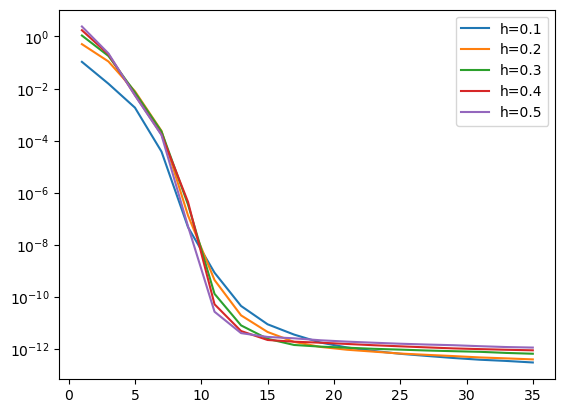

In [ ]:
PyPlot.plot(n_basis,h1,label="h=0.1")
PyPlot.plot(n_basis,h2,label="h=0.2")
PyPlot.plot(n_basis,h3,label="h=0.3")
PyPlot.plot(n_basis,h4,label="h=0.4")
PyPlot.plot(n_basis,h5,label="h=0.5")
PyPlot.yscale("log")
PyPlot.legend()
PyPlot.display_figs()

# Trotterised QFD

In [2]:
Lx = 1
Lz = 1
BC = 1
J = 1.0
hz = 0.1
n_l = 3
n_k = 3
r=4
n_l2 = 3
n_k2 = 3
r2=5
nkryl = 100
z = 0.5+0.01im
order = 2
type = 1 #Type 1: magnetic field in z direction. Type 2: uniform magnetic field
global α = 1
global β = 2
global γ = 3
n,Jxyz,hmagn,h,ham,ham_norm,kappa=output_ham_properties(Lx, Lz, BC, J, hz, type);

We consider n = 8 qubits


In [3]:
ev2,GSE2,GS2,coeffs2,vecs2 = find_GS_trot(Lx, Lz, BC,J,hz,n_l,n_k,r,order,type)

We consider n = 8 qubits
Eground = -0.12469873020765179
 >>exc>> 5 Y 
 >>exc>> 7 Y 
n_k,n_l =(3, 3)
 Smat Pos-def? true
 Hmat Hermitian? true
-0.1246987302076386

sys:1: UserWarning: The problem size 31 minus the constraints size 0 is too small relative to the block size 31. Using a dense eigensolver instead of LOBPCG.


(7.339292722155217e-13, -6.934505244240593, ArrayReg{2, ComplexF64, Array...}
    active qubits: 8/8
    nlevel: 2, ComplexF64[-0.09653241744166398 - 0.012450463944955949im, -0.05226812756034695 + 0.07417114981831753im, 0.017441401726533683 - 0.0003676246971434547im, -0.06329688356381465 - 0.03788745449199154im, -0.005477923462484688 + 0.004868321347018616im, -0.05599452317715116 + 0.059364706870130755im, -0.0033912480931275247 - 0.03662063162111767im, -0.016401830444709005 - 0.026444662129579213im, -0.06445820716479739 - 0.0027427842131545906im, 0.0010803321184454714 + 0.0008654508172706372im  …  -0.0003066508689578123 - 0.0014658786314098824im, -0.029291977702733642 + 0.05715531990087942im, 0.014569447295954602 + 0.027475837452545553im, 0.03029533513131409 + 0.020876999992450105im, -0.07910201983188324 + 0.01971071436764291im, -0.0071605106960388925 + 0.0023052149189252994im, 0.0021691784121702353 + 0.07373642893206296im, 0.008494119914469786 - 0.01528435000016229im, -0.0901894098379

In [ ]:
#Fix n_k, increase n_l
nk0 = map(i->find_GS_trot(Lx,Lz,BC,J,hz,i,0,r,order,type)[1],0:5);
nk1 = map(i->find_GS_trot(Lx,Lz,BC,J,hz,i,1,r,order,type)[1],0:5);
nk2 = map(i->find_GS_trot(Lx,Lz,BC,J,hz,i,2,r,order,type)[1],0:5);
nk3 = map(i->find_GS_trot(Lx,Lz,BC,J,hz,i,3,r,order,type)[1],0:5);
nk4 = map(i->find_GS_trot(Lx,Lz,BC,J,hz,i,4,r,order,type)[1],0:5);
nk5 = map(i->find_GS_trot(Lx,Lz,BC,J,hz,i,5,r,order,type)[1],0:5);

We consider n = 12 qubits


Eground = -0.037356021247679984
n_k,n_l =(0, 0)
 Smat Pos-def? 

┌ Info: Lanczos eigsolve finished after 5 iterations:
│ *  5 eigenvalues converged
│ *  norm of residuals = (6.583035338122754e-60, 9.897735754972141e-15, 2.388151835727457e-16, 1.3333553763595593e-19, 3.620577706423204e-14)
│ *  number of operations = 329
└ @ KrylovKit C:\Users\chidd\.julia\packages\KrylovKit\diNbc\src\eigsolve\lanczos.jl:143


true
 Hmat Hermitian? true
-0.03597323815905221
We consider n = 12 qubits


Eground = -0.037356021247680005


┌ Info: Lanczos eigsolve finished after 6 iterations:
│ *  14 eigenvalues converged
│ *  norm of residuals = (3.6838605390052103e-72, 2.467948316238893e-27, 3.955852165824021e-29, 2.2052395573111876e-25, 1.0807751216751827e-21, 4.670428271777679e-20, 1.9777388324103242e-24, 5.762145395211656e-14, 1.2112934143251242e-17, 6.684611833383983e-16, 0.0, 8.740594341442231e-17, 2.0201044122121207e-19, 0.0)
│ *  number of operations = 379
└ @ KrylovKit C:\Users\chidd\.julia\packages\KrylovKit\diNbc\src\eigsolve\lanczos.jl:143


n_k,n_l =(0, 1)


 Smat Pos-def? true
 Hmat Hermitian? true
-0.036502990398926335


We consider n = 12 qubits


Eground = -0.037356021247680136
n_k,n_l =(0, 2)


┌ Info: Lanczos eigsolve finished after 5 iterations:
│ *  5 eigenvalues converged
│ *  norm of residuals = (6.35195023447668e-60, 1.3393671417802918e-19, 1.553699719713915e-14, 1.1782411198245958e-16, 7.426393256474116e-15)
│ *  number of operations = 329
└ @ KrylovKit C:\Users\chidd\.julia\packages\KrylovKit\diNbc\src\eigsolve\lanczos.jl:143


 Smat Pos-def? true
 Hmat Hermitian? true
-0.03679580789352675


We consider n = 12 qubits


Eground = -0.037356021247680074
n_k,n_l =(0, 3)


┌ Info: Lanczos eigsolve finished after 5 iterations:
│ *  5 eigenvalues converged
│ *  norm of residuals = (4.27725722819018e-60, 3.635831478465786e-18, 1.5745190575257139e-15, 7.213953668309532e-15, 1.1504836037409785e-14)
│ *  number of operations = 329
└ @ KrylovKit C:\Users\chidd\.julia\packages\KrylovKit\diNbc\src\eigsolve\lanczos.jl:143


 Smat Pos-def? true
 Hmat Hermitian? true
-0.03721833519234515


We consider n = 12 qubits


Eground = -0.03735602124768008
n_k,n_l =(0, 4)


┌ Info: Lanczos eigsolve finished after 5 iterations:
│ *  5 eigenvalues converged
│ *  norm of residuals = (5.850002372510723e-60, 6.582982263215548e-20, 1.6622381937304727e-14, 2.925217995183274e-16, 1.9422632005825156e-13)
│ *  number of operations = 329
└ @ KrylovKit C:\Users\chidd\.julia\packages\KrylovKit\diNbc\src\eigsolve\lanczos.jl:143


 Smat Pos-def? true
 Hmat Hermitian? true
-0.037297464311397376


We consider n = 12 qubits


Eground = -0.0373560212476801
n_k,n_l =(0, 5)


┌ Info: Lanczos eigsolve finished after 5 iterations:
│ *  5 eigenvalues converged
│ *  norm of residuals = (5.00184639249734e-60, 5.254700476322015e-14, 6.644452537485317e-16, 5.940463798603087e-20, 4.340514549733551e-15)
│ *  number of operations = 329
└ @ KrylovKit C:\Users\chidd\.julia\packages\KrylovKit\diNbc\src\eigsolve\lanczos.jl:143


 Smat Pos-def? true
 Hmat Hermitian? true
-0.03732776261346858


We consider n = 12 qubits


Eground = -0.037356021247680074
n_k,n_l =(1, 0)


┌ Info: Lanczos eigsolve finished after 5 iterations:
│ *  5 eigenvalues converged
│ *  norm of residuals = (6.234325830412594e-60, 2.866459220182206e-14, 1.00770645442615e-17, 2.268284891431605e-16, 1.0089594655645983e-13)
│ *  number of operations = 329
└ @ KrylovKit C:\Users\chidd\.julia\packages\KrylovKit\diNbc\src\eigsolve\lanczos.jl:143


 Smat Pos-def? true
 Hmat Hermitian? true
-0.03650299039892471
We consider n = 12 qubits


Eground = -0.03735602124768011
n_k,n_l =(1, 1)

┌ Info: Lanczos eigsolve finished after 5 iterations:
│ *  5 eigenvalues converged
│ *  norm of residuals = (6.982389822206071e-60, 6.811133592506933e-18, 1.3577145806083703e-16, 1.0626188138668281e-14, 1.3965541486831426e-14)
│ *  number of operations = 329
└ @ KrylovKit C:\Users\chidd\.julia\packages\KrylovKit\diNbc\src\eigsolve\lanczos.jl:143



 Smat Pos-def? true
 Hmat Hermitian? true
-0.03674847751130431


We consider n = 12 qubits


Eground = -0.03735602124768001
n_k,n_l =(1, 2)


┌ Info: Lanczos eigsolve finished after 5 iterations:
│ *  5 eigenvalues converged
│ *  norm of residuals = (6.335608581475916e-60, 2.278294501507272e-18, 1.1965007656382058e-13, 3.9671301032181673e-16, 9.697689589882722e-14)
│ *  number of operations = 329
└ @ KrylovKit C:\Users\chidd\.julia\packages\KrylovKit\diNbc\src\eigsolve\lanczos.jl:143


 Smat Pos-def? true
 Hmat Hermitian? true
-0.03725052722745839


We consider n = 12 qubits


Eground = -0.037356021247680074
n_k,n_l =(1, 3)


┌ Info: Lanczos eigsolve finished after 5 iterations:
│ *  6 eigenvalues converged
│ *  norm of residuals = (6.105883990343949e-60, 8.588052934644556e-16, 7.723693071468446e-15, 4.121071635814371e-18, 2.614728232938554e-15, 9.898507306536435e-14)
│ *  number of operations = 329
└ @ KrylovKit C:\Users\chidd\.julia\packages\KrylovKit\diNbc\src\eigsolve\lanczos.jl:143


 Smat Pos-def? true
 Hmat Hermitian? true
-0.03731080776561456


We consider n = 12 qubits


Eground = -0.03735602124768
n_k,n_l =(1, 4)

┌ Info: Lanczos eigsolve finished after 6 iterations:
│ *  14 eigenvalues converged
│ *  norm of residuals = (2.634931500315085e-72, 1.231571711415024e-25, 8.314705986221081e-28, 2.0848843687769785e-27, 4.028359527417908e-20, 5.633818757895137e-22, 2.3060179264109278e-24, 1.0601316413835795e-13, 4.787573570821462e-18, 6.649417989007258e-16, 0.0, 1.4670329500928854e-16, 1.6417261120666812e-19, 0.0)
│ *  number of operations = 379
└ @ KrylovKit C:\Users\chidd\.julia\packages\KrylovKit\diNbc\src\eigsolve\lanczos.jl:143



 Smat Pos-def? true
 Hmat Hermitian? true
-0.03734811940756542


We consider n = 12 qubits


Eground = -0.03735602124768004


┌ Info: Lanczos eigsolve finished after 6 iterations:
│ *  14 eigenvalues converged
│ *  norm of residuals = (3.559793124395641e-72, 2.5028582967626375e-25, 1.5719605744327242e-31, 8.575417461083024e-28, 5.218106829777259e-22, 1.0565935229104651e-23, 8.260711876782055e-20, 1.0292556394912592e-18, 8.849457551436132e-16, 9.295561737869634e-14, 0.0, 9.018072257580818e-19, 2.2565702221950822e-16, 0.0)
│ *  number of operations = 379
└ @ KrylovKit C:\Users\chidd\.julia\packages\KrylovKit\diNbc\src\eigsolve\lanczos.jl:143


n_k,n_l =(1, 5)
 Smat Pos-def? true
 Hmat Hermitian? true
-0.0373538937856567


We consider n = 12 qubits


Eground = -0.03735602124768004
n_k,n_l =(2, 0)

┌ Info: Lanczos eigsolve finished after 5 iterations:
│ *  5 eigenvalues converged
│ *  norm of residuals = (6.503209269077221e-60, 2.5771776273422846e-19, 3.1630956048814993e-16, 2.2643944571929825e-14, 3.258646727995738e-14)
│ *  number of operations = 329
└ @ KrylovKit C:\Users\chidd\.julia\packages\KrylovKit\diNbc\src\eigsolve\lanczos.jl:143



 Smat Pos-def? true
 Hmat Hermitian? true
-0.0365320813850859


We consider n = 12 qubits


Eground = -0.03735602124768007
n_k,n_l =(2, 1)


┌ Info: Lanczos eigsolve finished after 5 iterations:
│ *  5 eigenvalues converged
│ *  norm of residuals = (4.992802933319585e-60, 1.3638562102365495e-19, 2.406274015951191e-16, 1.1369450865563185e-14, 2.139649512399941e-15)
│ *  number of operations = 329
└ @ KrylovKit C:\Users\chidd\.julia\packages\KrylovKit\diNbc\src\eigsolve\lanczos.jl:143


 Smat Pos-def? true
 Hmat Hermitian? true
-0.03718437937868518


We consider n = 12 qubits


Eground = -0.03735602124768009
n_k,n_l =(2, 2)


┌ Info: Lanczos eigsolve finished after 5 iterations:
│ *  5 eigenvalues converged
│ *  norm of residuals = (6.158722524484222e-60, 1.5725592775187266e-15, 1.5138772211040205e-14, 7.721277563418708e-18, 5.721996437728988e-15)
│ *  number of operations = 329
└ @ KrylovKit C:\Users\chidd\.julia\packages\KrylovKit\diNbc\src\eigsolve\lanczos.jl:143


 Smat Pos-def? true
 Hmat Hermitian? true
-0.03731753193529593


We consider n = 12 qubits


Eground = -0.037356021247680046
n_k,n_l =(2, 3)


┌ Info: Lanczos eigsolve finished after 5 iterations:
│ *  6 eigenvalues converged
│ *  norm of residuals = (4.7427078672196194e-60, 1.2972277218320792e-16, 1.6831740358125581e-18, 1.42313473681796e-14, 8.514680586687059e-16, 2.8166911043761073e-14)
│ *  number of operations = 329
└ @ KrylovKit C:\Users\chidd\.julia\packages\KrylovKit\diNbc\src\eigsolve\lanczos.jl:143


 Smat Pos-def? true
 Hmat Hermitian? true
-0.03735079344172313


We consider n = 12 qubits


Eground = -0.03735602124768002
n_k,n_l =(2, 4)


┌ Info: Lanczos eigsolve finished after 5 iterations:
│ *  6 eigenvalues converged
│ *  norm of residuals = (7.277162612822609e-60, 1.3687035738456007e-14, 2.8130642573313283e-18, 1.0339785363998887e-16, 7.391408622199665e-13, 1.2484055458596555e-14)
│ *  number of operations = 329
└ @ KrylovKit C:\Users\chidd\.julia\packages\KrylovKit\diNbc\src\eigsolve\lanczos.jl:143


 Smat Pos-def? true
 Hmat Hermitian? true
-0.037354760637353074


We consider n = 12 qubits


Eground = -0.03735602124768007
n_k,n_l =(2, 5)


┌ Info: Lanczos eigsolve finished after 6 iterations:
│ *  14 eigenvalues converged
│ *  norm of residuals = (4.0007446654664267e-72, 5.419431559692696e-25, 1.1064274677871837e-25, 5.551078220811911e-30, 6.369771302995685e-22, 6.96245773066045e-20, 2.165904383627999e-25, 9.468352508065658e-19, 1.6766167919602115e-13, 2.015446465821745e-14, 0.0, 1.0764823862400693e-16, 9.817501742044224e-19, 0.0)
│ *  number of operations = 379
└ @ KrylovKit C:\Users\chidd\.julia\packages\KrylovKit\diNbc\src\eigsolve\lanczos.jl:143


 Smat Pos-def? true
 Hmat Hermitian? true
-0.03735580812329896


We consider n = 12 qubits


Eground = -0.03735602124768013
n_k,n_l =(3, 0)


┌ Info: Lanczos eigsolve finished after 5 iterations:
│ *  5 eigenvalues converged
│ *  norm of residuals = (5.129581281383713e-60, 3.387149409443108e-14, 2.5643326250339236e-16, 6.209760593105437e-19, 3.5233447566614954e-15)
│ *  number of operations = 329
└ @ KrylovKit C:\Users\chidd\.julia\packages\KrylovKit\diNbc\src\eigsolve\lanczos.jl:143


 Smat Pos-def? true
 Hmat Hermitian? true
-0.03653491910042286


We consider n = 12 qubits


Eground = -0.03735602124768009
n_k,n_l =(3, 1)


┌ Info: Lanczos eigsolve finished after 6 iterations:
│ *  14 eigenvalues converged
│ *  norm of residuals = (3.79237865622696e-72, 2.9911423010544333e-25, 6.392269030819542e-28, 1.5846561252437845e-30, 1.9424504301010752e-22, 2.985043861068404e-20, 1.329198183486094e-22, 4.477211838352846e-18, 8.812244687126516e-14, 3.299507516111764e-16, 0.0, 1.8529753118250132e-19, 1.6127810241731868e-16, 0.0)
│ *  number of operations = 379
└ @ KrylovKit C:\Users\chidd\.julia\packages\KrylovKit\diNbc\src\eigsolve\lanczos.jl:143


 Smat Pos-def? true
 Hmat Hermitian? true
-0.03726655051993648


We consider n = 12 qubits


Eground = -0.03735602124768009
n_k,n_l =(3, 2)


┌ Info: Lanczos eigsolve finished after 6 iterations:
│ *  16 eigenvalues converged
│ *  norm of residuals = (3.505673683131979e-72, 6.139988605417761e-25, 1.0149880056655838e-27, 1.725371345904093e-29, 1.136173487967786e-21, 8.424317275729797e-20, 1.3452900963702147e-24, 7.148406342876694e-19, 8.442658163467683e-16, 5.98978007286372e-14, 0.0, 9.936123483171086e-19, 7.729889215469874e-17, 0.0, 6.055906135278505e-15, 7.1020078690736e-13)
│ *  number of operations = 379
└ @ KrylovKit C:\Users\chidd\.julia\packages\KrylovKit\diNbc\src\eigsolve\lanczos.jl:143


 Smat Pos-def? true
 Hmat Hermitian? true
-0.037344633554970835


We consider n = 12 qubits


Eground = -0.03735602124768007
n_k,n_l =(3, 3)


┌ Info: Lanczos eigsolve finished after 5 iterations:
│ *  5 eigenvalues converged
│ *  norm of residuals = (5.652845984750906e-60, 6.065721331879779e-17, 1.2352406768245344e-18, 1.65678217908491e-14, 8.469335481186906e-15)
│ *  number of operations = 329
└ @ KrylovKit C:\Users\chidd\.julia\packages\KrylovKit\diNbc\src\eigsolve\lanczos.jl:143


 Smat Pos-def? true
 Hmat Hermitian? true
-0.03735482166993997


We consider n = 12 qubits


Eground = -0.037356021247680025
n_k,n_l =(3, 4)

┌ Info: Lanczos eigsolve finished after 5 iterations:
│ *  6 eigenvalues converged
│ *  norm of residuals = (6.055472192849744e-60, 5.118026266532758e-14, 3.1760880909597485e-18, 2.1141215211380254e-16, 5.875112877847295e-15, 9.024439633582143e-13)
│ *  number of operations = 329
└ @ KrylovKit C:\Users\chidd\.julia\packages\KrylovKit\diNbc\src\eigsolve\lanczos.jl:143



 Smat Pos-def? true
 Hmat Hermitian? true
-0.037355710233490644


We consider n = 12 qubits


Eground = -0.03735602124768003
n_k,n_l =(3, 5)

┌ Info: Lanczos eigsolve finished after 5 iterations:
│ *  5 eigenvalues converged
│ *  norm of residuals = (5.65939624761522e-60, 2.867986292566938e-19, 2.3137222238640832e-14, 1.5855116326963096e-16, 1.6596993953520407e-15)
│ *  number of operations = 329
└ @ KrylovKit C:\Users\chidd\.julia\packages\KrylovKit\diNbc\src\eigsolve\lanczos.jl:143



 Smat Pos-def? true
 Hmat Hermitian? true
-0.03735589713438756


We consider n = 12 qubits


Eground = -0.03735602124768006
n_k,n_l =(4, 0)


┌ Info: Lanczos eigsolve finished after 5 iterations:
│ *  6 eigenvalues converged
│ *  norm of residuals = (7.135755537960921e-60, 2.416760849672442e-19, 3.4411191819094165e-14, 3.2809681648779884e-16, 4.547384058943304e-15, 6.940911848475574e-13)
│ *  number of operations = 329
└ @ KrylovKit C:\Users\chidd\.julia\packages\KrylovKit\diNbc\src\eigsolve\lanczos.jl:143


 Smat Pos-def? true
 Hmat Hermitian? true
-0.036539520027131005


We consider n = 12 qubits


Eground = -0.03735602124768007
n_k,n_l =(4, 1)


┌ Info: Lanczos eigsolve finished after 6 iterations:
│ *  14 eigenvalues converged
│ *  norm of residuals = (2.930688378694247e-72, 7.566172017765398e-28, 2.134691236974706e-25, 9.243426807364956e-28, 1.064255763531524e-19, 1.6873486733927452e-21, 6.4447449368990414e-24, 1.33843701946188e-18, 2.8758281872714228e-15, 2.3468401433500195e-13, 0.0, 4.808457155211615e-17, 2.7677449973692295e-19, 0.0)
│ *  number of operations = 379
└ @ KrylovKit C:\Users\chidd\.julia\packages\KrylovKit\diNbc\src\eigsolve\lanczos.jl:143


 Smat Pos-def? true
 Hmat Hermitian? true
-0.03728325864353553


We consider n = 12 qubits


Eground = -0.03735602124768009
n_k,n_l =(4, 2)


┌ Info: Lanczos eigsolve finished after 5 iterations:
│ *  6 eigenvalues converged
│ *  norm of residuals = (7.428564207896875e-60, 6.384732352902426e-20, 8.529430078098427e-15, 1.6635759860908826e-16, 5.872846483984966e-13, 8.46626672301897e-16)
│ *  number of operations = 329
└ @ KrylovKit C:\Users\chidd\.julia\packages\KrylovKit\diNbc\src\eigsolve\lanczos.jl:143


 Smat Pos-def? true
 Hmat Hermitian? true
-0.03735016507482354


We consider n = 12 qubits


Eground = -0.03735602124768008
n_k,n_l =(4, 3)


┌ Info: Lanczos eigsolve finished after 5 iterations:
│ *  5 eigenvalues converged
│ *  norm of residuals = (6.034117963630447e-60, 1.850674743176761e-16, 7.331270751709995e-17, 2.3740657235461472e-14, 5.834194174370678e-15)
│ *  number of operations = 329
└ @ KrylovKit C:\Users\chidd\.julia\packages\KrylovKit\diNbc\src\eigsolve\lanczos.jl:143


 Smat Pos-def? true
 Hmat Hermitian? true
-0.03735542528771359


We consider n = 12 qubits


Eground = -0.037356021247680074
n_k,n_l =(4, 4)

┌ Info: Lanczos eigsolve finished after 5 iterations:
│ *  5 eigenvalues converged
│ *  norm of residuals = (5.179293967574063e-60, 4.406733578507944e-19, 5.49366288848755e-16, 1.5220716803487703e-14, 1.2971341368247278e-14)
│ *  number of operations = 329
└ @ KrylovKit C:\Users\chidd\.julia\packages\KrylovKit\diNbc\src\eigsolve\lanczos.jl:143



 Smat Pos-def? true
 Hmat Hermitian? true
-0.03735589301941142


We consider n = 12 qubits


Eground = -0.037356021247680025
n_k,n_l =(4, 5)


┌ Info: Lanczos eigsolve finished after 6 iterations:
│ *  18 eigenvalues converged
│ *  norm of residuals = (3.639224743908366e-72, 6.083460338010692e-25, 3.871152200177957e-27, 4.496175355343102e-27, 4.252111860377943e-22, 4.405622083807809e-20, 5.065121607706361e-24, 2.2334125686940988e-14, 2.270638746853128e-14, 1.0323674700298144e-13, 0.0, 2.3246245902906323e-16, 2.6172515899835906e-18, 0.0, 1.7873967051331317e-14, 7.554962863820149e-13, 6.9800660363597814e-15, 9.259538231780086e-13)
│ *  number of operations = 379
└ @ KrylovKit C:\Users\chidd\.julia\packages\KrylovKit\diNbc\src\eigsolve\lanczos.jl:143


 Smat Pos-def? true
 Hmat Hermitian? true
-0.03735601401521689


We consider n = 12 qubits


Eground = -0.03735602124768004
n_k,n_l =(5, 0)


┌ Info: Lanczos eigsolve finished after 5 iterations:
│ *  5 eigenvalues converged
│ *  norm of residuals = (5.938488975406773e-60, 5.272632725775607e-19, 5.964141766488576e-16, 1.6007279367644772e-14, 5.5896435622727346e-14)
│ *  number of operations = 329
└ @ KrylovKit C:\Users\chidd\.julia\packages\KrylovKit\diNbc\src\eigsolve\lanczos.jl:143


 Smat Pos-def? true
 Hmat Hermitian? true
-0.036580895905639114


We consider n = 12 qubits


Eground = -0.03735602124768005
n_k,n_l =(5, 1)


┌ Info: Lanczos eigsolve finished after 5 iterations:
│ *  5 eigenvalues converged
│ *  norm of residuals = (5.906214710703645e-60, 5.299140032523544e-14, 2.347099762931953e-16, 3.7231494245902765e-18, 6.632986236105274e-15)
│ *  number of operations = 329
└ @ KrylovKit C:\Users\chidd\.julia\packages\KrylovKit\diNbc\src\eigsolve\lanczos.jl:143


 Smat Pos-def? true
 Hmat Hermitian? true
-0.03728679563301774


We consider n = 12 qubits


Eground = -0.037356021247680025
n_k,n_l =(5, 2)


┌ Info: Lanczos eigsolve finished after 5 iterations:
│ *  5 eigenvalues converged
│ *  norm of residuals = (4.61075629100661e-60, 6.991817509476414e-15, 1.305288365355533e-16, 3.724618020856092e-19, 2.4299842227716657e-15)
│ *  number of operations = 329
└ @ KrylovKit C:\Users\chidd\.julia\packages\KrylovKit\diNbc\src\eigsolve\lanczos.jl:143


 Smat Pos-def? true
 Hmat Hermitian? true
-0.037354046153506126


We consider n = 12 qubits


Eground = -0.03735602124768005
n_k,n_l =(5, 3)


┌ Info: Lanczos eigsolve finished after 6 iterations:
│ *  9 eigenvalues converged
│ *  norm of residuals = (5.460413048289341e-72, 2.5401493920155837e-28, 5.022654528464158e-27, 3.2324783078665097e-25, 4.590056990774316e-22, 9.929815195172645e-20, 1.6284115007574519e-24, 4.952600133268218e-19, 5.047719944730507e-15)
│ *  number of operations = 379
└ @ KrylovKit C:\Users\chidd\.julia\packages\KrylovKit\diNbc\src\eigsolve\lanczos.jl:143


 Smat Pos-def? true
 Hmat Hermitian? true
-0.037355795449795205


We consider n = 12 qubits


Eground = -0.03735602124768007
n_k,n_l =(5, 4)

┌ Info: Lanczos eigsolve finished after 6 iterations:
│ *  14 eigenvalues converged
│ *  norm of residuals = (3.739838773088884e-72, 2.6560748235076643e-30, 3.87372788051306e-25, 1.598924807531431e-26, 1.144595734731794e-25, 6.632002706559212e-22, 6.145405213298841e-20, 1.3191055799718512e-13, 5.12481520876562e-16, 7.629856657001222e-19, 0.0, 1.6097230156071006e-18, 1.1262721680360274e-16, 0.0)
│ *  number of operations = 379
└ @ KrylovKit C:\Users\chidd\.julia\packages\KrylovKit\diNbc\src\eigsolve\lanczos.jl:143



 Smat Pos-def? true
 Hmat Hermitian? true
-0.03735596631530068


We consider n = 12 qubits


Eground = -0.03735602124768008
n_k,n_l =(5, 5)


┌ Info: Lanczos eigsolve finished after 5 iterations:
│ *  5 eigenvalues converged
│ *  norm of residuals = (6.020818867882971e-60, 2.7788971825585914e-19, 3.4327916814906685e-16, 4.2177722165391697e-14, 1.0318448218500802e-14)
│ *  number of operations = 329
└ @ KrylovKit C:\Users\chidd\.julia\packages\KrylovKit\diNbc\src\eigsolve\lanczos.jl:143


 Smat Pos-def? true
 Hmat Hermitian? true
-0.03735602116376373


In [ ]:
open("./data/N=$(n)_h=$(hz)_J=$(J)_fix_n_k_trot_r=$(r).dat", "a") do io
    writedlm(io, [nk0,nk1,nk2,nk3,nk4,nk5])
end

In [ ]:
#Fix n_k, n_l, increase # trotter steps
trt8p = map(i->find_GS_trot(1,1,BC,1.0,hz,2,5,i,order,type)[1],1:10);
trt8m = map(i->find_GS_trot(1,1,BC,-1.0,hz,2,5,i,order,type)[1],1:10);
trt12p = map(i->find_GS_trot(1,2,BC,1.0,hz,2,5,i,order,type)[1],1:10);
trt12m = map(i->find_GS_trot(1,2,BC,-1.0,hz,2,5,i,order,type)[1],1:10);


We consider n = 8 qubits


Eground = -0.12469873020765179
 >>exc>> 5 Y 
 >>exc>> 7 Y 


┌ Info: Lanczos eigsolve finished after 1 iterations:
│ *  5 eigenvalues converged
│ *  norm of residuals = (5.822463173972722e-46, 0.0, 0.0, 0.0, 2.5307135518501628e-14)
│ *  number of operations = 128
└ @ KrylovKit C:\Users\chidd\.julia\packages\KrylovKit\diNbc\src\eigsolve\lanczos.jl:143


n_k,n_l =(5, 2)


 Smat Pos-def? true
 Hmat Hermitian? true
-0.12469873020762201


We consider n = 8 qubits
Eground = -0.12469873020765174
 >>exc>> 5 Y 
 >>exc>> 7 Y 
n_k,n_l =(5, 2)


┌ Info: Lanczos eigsolve finished after 1 iterations:
│ *  5 eigenvalues converged
│ *  norm of residuals = (2.4552001593858456e-46, 0.0, 0.0, 0.0, 6.515595421546625e-15)
│ *  number of operations = 128
└ @ KrylovKit C:\Users\chidd\.julia\packages\KrylovKit\diNbc\src\eigsolve\lanczos.jl:143


 Smat Pos-def? true
 Hmat Hermitian? true
-0.1246987302075676
We consider n = 8 qubits
Eground = -0.12469873020765179
 >>exc>> 

┌ Info: Lanczos eigsolve finished after 1 iterations:
│ *  5 eigenvalues converged
│ *  norm of residuals = (3.1158054276982896e-46, 0.0, 0.0, 0.0, 3.9662612260750325e-15)
│ *  number of operations = 128
└ @ KrylovKit C:\Users\chidd\.julia\packages\KrylovKit\diNbc\src\eigsolve\lanczos.jl:143


5 Y 
 >>exc>> 7 Y 
n_k,n_l =(5, 2)


 Smat Pos-def? true
 Hmat Hermitian? true
-0.12469873020762905
We consider n = 8 qubits


Eground = -0.12469873020765174
 >>exc>> 5 Y 
 >>exc>> 7 Y 
n_k,n_l =(5, 2)

┌ Info: Lanczos eigsolve finished after 1 iterations:
│ *  5 eigenvalues converged
│ *  norm of residuals = (3.2656877627086314e-46, 0.0, 0.0, 0.0, 1.344980206073413e-14)
│ *  number of operations = 128
└ @ KrylovKit C:\Users\chidd\.julia\packages\KrylovKit\diNbc\src\eigsolve\lanczos.jl:143



 Smat Pos-def? true
 Hmat Hermitian? true
-0.12469873020764272


We consider n = 8 qubits


Eground = -0.12469873020765174
 >>exc>> 5 Y 
 >>exc>> 7 Y 
n_k,n_l =(5, 2)


┌ Info: Lanczos eigsolve finished after 1 iterations:
│ *  5 eigenvalues converged
│ *  norm of residuals = (2.8384943676059868e-46, 0.0, 0.0, 0.0, 4.0072888512286004e-14)
│ *  number of operations = 128
└ @ KrylovKit C:\Users\chidd\.julia\packages\KrylovKit\diNbc\src\eigsolve\lanczos.jl:143


 Smat Pos-def? true
 Hmat Hermitian? true
-0.12469873020764234


We consider n = 8 qubits
Eground = -0.12469873020765179
 >>exc>> 5 Y 
 >>exc>> 7 Y 
n_k,n_l =(5, 2)


┌ Info: Lanczos eigsolve finished after 1 iterations:
│ *  5 eigenvalues converged
│ *  norm of residuals = (4.982508428641781e-46, 0.0, 0.0, 0.0, 1.6296091847409444e-16)
│ *  number of operations = 128
└ @ KrylovKit C:\Users\chidd\.julia\packages\KrylovKit\diNbc\src\eigsolve\lanczos.jl:143


 Smat Pos-def? true
 Hmat Hermitian? true
-0.12469873020764416


We consider n = 8 qubits
Eground = -0.12469873020765174

┌ Info: Lanczos eigsolve finished after 1 iterations:
│ *  5 eigenvalues converged
│ *  norm of residuals = (2.6833113631390557e-46, 0.0, 0.0, 0.0, 8.487776117476857e-15)
│ *  number of operations = 128
└ @ KrylovKit C:\Users\chidd\.julia\packages\KrylovKit\diNbc\src\eigsolve\lanczos.jl:143



 >>exc>> 5 Y 
 >>exc>> 7 Y 
n_k,n_l =(5, 2)


 Smat Pos-def? true
 Hmat Hermitian? true
-0.12469873020764448
We consider n = 

8 qubits
Eground = -0.12469873020765163
 >>exc>> 5 Y 
 >>exc>> 

┌ Info: Lanczos eigsolve finished after 1 iterations:
│ *  5 eigenvalues converged
│ *  norm of residuals = (2.017930612850199e-46, 0.0, 0.0, 0.0, 2.926526440196351e-14)
│ *  number of operations = 128
└ @ KrylovKit C:\Users\chidd\.julia\packages\KrylovKit\diNbc\src\eigsolve\lanczos.jl:143


7 Y 
n_k,n_l =(5, 2)


 Smat Pos-def? true
 Hmat Hermitian? true
-0.12469873020764452


We consider n = 8 qubits
Eground = -0.12469873020765174
 >>exc>> 5 Y 
 >>exc>> 7 Y 
n_k,n_l =(5, 2)


┌ Info: Lanczos eigsolve finished after 1 iterations:
│ *  5 eigenvalues converged
│ *  norm of residuals = (4.2178761240532346e-46, 0.0, 0.0, 0.0, 6.956251331607088e-15)
│ *  number of operations = 128
└ @ KrylovKit C:\Users\chidd\.julia\packages\KrylovKit\diNbc\src\eigsolve\lanczos.jl:143


 Smat Pos-def? true
 Hmat Hermitian? true
-0.12469873020764456


We consider n = 8 qubits
Eground = -0.12469873020765174
 >>exc>> 5 Y 
 >>exc>> 7 Y 
n_k,n_l =(5, 2)


┌ Info: Lanczos eigsolve finished after 1 iterations:
│ *  5 eigenvalues converged
│ *  norm of residuals = (1.9364078261821873e-46, 0.0, 0.0, 0.0, 1.0261463173451906e-14)
│ *  number of operations = 128
└ @ KrylovKit C:\Users\chidd\.julia\packages\KrylovKit\diNbc\src\eigsolve\lanczos.jl:143


 Smat Pos-def? true
 Hmat Hermitian? true
-0.12469873020764448


We consider n = 8 qubits
Eground = -0.1264973086360069
 >>exc>> 5 Y 
 >>exc>> 7 Y 
n_k,n_l =(5, 2)

┌ Info: Lanczos eigsolve finished after 1 iterations:
│ *  7 eigenvalues converged
│ *  norm of residuals = (8.713793489637224e-46, 0.0, 0.0, 0.0, 9.959842702157928e-16, 3.84800952155799e-14, 4.134153885644276e-13)
│ *  number of operations = 128
└ @ KrylovKit C:\Users\chidd\.julia\packages\KrylovKit\diNbc\src\eigsolve\lanczos.jl:143



 Smat Pos-def? true
 Hmat Hermitian? true
-0.12649730863565925


We consider n = 8 qubits
Eground = -0.12649730863600686
 >>exc>> 5 Y 
 >>exc>> 7 Y 
n_k,n_l =(5, 2)

┌ Info: Lanczos eigsolve finished after 1 iterations:
│ *  7 eigenvalues converged
│ *  norm of residuals = (7.81683901561891e-46, 0.0, 0.0, 0.0, 8.53257238055204e-16, 2.87653081475464e-14, 6.763263270388413e-14)
│ *  number of operations = 128
└ @ KrylovKit C:\Users\chidd\.julia\packages\KrylovKit\diNbc\src\eigsolve\lanczos.jl:143



 Smat Pos-def? true
 Hmat Hermitian? true
-0.12649730863562433
We consider n = 

8 qubits
Eground = -0.12649730863600686
 >>exc>> 5 Y 
 >>exc>> 7 Y 
n_k,n_l =(5, 2)

┌ Info: Lanczos eigsolve finished after 1 iterations:
│ *  7 eigenvalues converged
│ *  norm of residuals = (1.587892033963062e-45, 0.0, 0.0, 0.0, 1.8040676249103674e-15, 1.0842935005958841e-13, 6.884987693326487e-13)
│ *  number of operations = 128
└ @ KrylovKit C:\Users\chidd\.julia\packages\KrylovKit\diNbc\src\eigsolve\lanczos.jl:143



 Smat Pos-def? true
 Hmat Hermitian? true
-0.1264973086359836
We consider n = 8 qubits
Eground = -0.12649730863600686
 >>exc>> 5 Y 
 >>exc>> 7 Y 
n_k,n_l =(5, 2)


┌ Info: Lanczos eigsolve finished after 1 iterations:
│ *  7 eigenvalues converged
│ *  norm of residuals = (8.896555562475632e-46, 0.0, 0.0, 0.0, 1.7666329553291279e-15, 5.50047965068982e-14, 1.2558337584141208e-13)
│ *  number of operations = 128
└ @ KrylovKit C:\Users\chidd\.julia\packages\KrylovKit\diNbc\src\eigsolve\lanczos.jl:143


 Smat Pos-def? true
 Hmat Hermitian? true
-0.1264973086359901


We consider n = 8 qubits
Eground = -0.12649730863600686
 >>exc>> 5 Y 
 >>exc>> 7 Y 
n_k,n_l =(5, 2)

┌ Info: Lanczos eigsolve finished after 1 iterations:
│ *  7 eigenvalues converged
│ *  norm of residuals = (8.803884761818245e-46, 0.0, 0.0, 0.0, 1.7509081933124076e-15, 2.048691231221841e-13, 7.094853292805443e-13)
│ *  number of operations = 128
└ @ KrylovKit C:\Users\chidd\.julia\packages\KrylovKit\diNbc\src\eigsolve\lanczos.jl:143



 Smat Pos-def? true
 Hmat Hermitian? true
-0.12649730863597386


We consider n = 8 qubits
Eground = -0.12649730863600686
 >>exc>> 5 Y 
 >>exc>> 7 Y 
n_k,n_l =(5, 2)

┌ Info: Lanczos eigsolve finished after 1 iterations:
│ *  7 eigenvalues converged
│ *  norm of residuals = (2.1378396443995387e-45, 0.0, 0.0, 0.0, 2.2365251095759717e-15, 1.374147484305644e-13, 9.666437938968257e-13)
│ *  number of operations = 128
└ @ KrylovKit C:\Users\chidd\.julia\packages\KrylovKit\diNbc\src\eigsolve\lanczos.jl:143



 Smat Pos-def? true
 Hmat Hermitian? true
-0.126497308635985


We consider n = 8 qubits
Eground = -0.12649730863600686
 >>exc>> 5 Y 
 >>exc>> 7 Y 
n_k,n_l =(5, 2)


┌ Info: Lanczos eigsolve finished after 1 iterations:
│ *  7 eigenvalues converged
│ *  norm of residuals = (9.330358552373904e-46, 0.0, 0.0, 0.0, 1.1221117984061887e-15, 7.377011003787978e-14, 2.286002876246645e-13)
│ *  number of operations = 128
└ @ KrylovKit C:\Users\chidd\.julia\packages\KrylovKit\diNbc\src\eigsolve\lanczos.jl:143


 Smat Pos-def? true
 Hmat Hermitian? true
-0.12649730863598999


We consider n = 8 qubits
Eground = -0.12649730863600686
 >>exc>> 5 Y 
 >>exc>> 7 Y 
n_k,n_l =(5, 2)


┌ Info: Lanczos eigsolve finished after 1 iterations:
│ *  7 eigenvalues converged
│ *  norm of residuals = (3.987990414326399e-46, 0.0, 0.0, 0.0, 3.9922606732713513e-16, 4.60248931443948e-14, 6.209716163105154e-14)
│ *  number of operations = 128
└ @ KrylovKit C:\Users\chidd\.julia\packages\KrylovKit\diNbc\src\eigsolve\lanczos.jl:143


 Smat Pos-def? true
 Hmat Hermitian? true
-0.12649730863599146


We consider n = 8 qubits
Eground = -0.1264973086360069
 >>exc>> 5 Y 
 >>exc>> 

┌ Info: Lanczos eigsolve finished after 1 iterations:
│ *  6 eigenvalues converged
│ *  norm of residuals = (1.5327756989071892e-45, 0.0, 0.0, 0.0, 5.204038262870653e-15, 2.3182946512537663e-13)
│ *  number of operations = 128
└ @ KrylovKit C:\Users\chidd\.julia\packages\KrylovKit\diNbc\src\eigsolve\lanczos.jl:143


7 Y 
n_k,n_l =(5, 2)


 Smat Pos-def? true
 Hmat Hermitian? true
-0.12649730863599215


We consider n = 8 qubits
Eground = -0.1264973086360069
 >>exc>> 5 Y 
 >>exc>> 7 Y 
n_k,n_l =(5, 2)


┌ Info: Lanczos eigsolve finished after 1 iterations:
│ *  7 eigenvalues converged
│ *  norm of residuals = (1.4197180058244563e-45, 0.0, 0.0, 0.0, 2.202995582796425e-15, 7.576417802370555e-14, 2.31207109367639e-13)
│ *  number of operations = 128
└ @ KrylovKit C:\Users\chidd\.julia\packages\KrylovKit\diNbc\src\eigsolve\lanczos.jl:143


 Smat Pos-def? true
 Hmat Hermitian? true
-0.12649730863599232


We consider n = 12 qubits


Eground = -0.036041809996899765
n_k,n_l =(5, 2)


┌ Info: Lanczos eigsolve finished after 5 iterations:
│ *  7 eigenvalues converged
│ *  norm of residuals = (8.633189872955341e-24, 3.341904073532837e-22, 1.5146593770237992e-24, 0.0, 5.328405407604374e-18, 4.716122633914837e-16, 0.0)
│ *  number of operations = 333
└ @ KrylovKit C:\Users\chidd\.julia\packages\KrylovKit\diNbc\src\eigsolve\lanczos.jl:143


 Smat Pos-def? true
 Hmat Hermitian? true
-0.03602772459184212


We consider n = 12 qubits


Eground = -0.036041809996899765
n_k,n_l =(5, 2)


┌ Info: Lanczos eigsolve finished after 5 iterations:
│ *  7 eigenvalues converged
│ *  norm of residuals = (1.0957098488841929e-23, 6.167584368746715e-22, 1.1626093658971263e-26, 0.0, 3.553235065694231e-18, 1.0558852853605879e-15, 0.0)
│ *  number of operations = 333
└ @ KrylovKit C:\Users\chidd\.julia\packages\KrylovKit\diNbc\src\eigsolve\lanczos.jl:143


 Smat Pos-def? true
 Hmat Hermitian? true
-0.03602992355426925


We consider n = 12 qubits


Eground = -0.03604180999689977
n_k,n_l =(5, 2)

┌ Info: Lanczos eigsolve finished after 5 iterations:
│ *  7 eigenvalues converged
│ *  norm of residuals = (1.1769911366213875e-25, 4.813760565960756e-22, 3.611428088520753e-23, 0.0, 1.2262599314826342e-15, 6.3160093416263096e-18, 0.0)
│ *  number of operations = 331
└ @ KrylovKit C:\Users\chidd\.julia\packages\KrylovKit\diNbc\src\eigsolve\lanczos.jl:143



 Smat Pos-def? true
 Hmat Hermitian? true
-0.03603108753776341


We consider n = 12 qubits


Eground = -0.03604180999689978
n_k,n_l =(5, 2)


┌ Info: Lanczos eigsolve finished after 5 iterations:
│ *  8 eigenvalues converged
│ *  norm of residuals = (6.970932288954165e-24, 1.2498316854032594e-21, 5.0957502998994366e-27, 0.0, 2.1419276644360935e-15, 1.6472344792986547e-17, 0.0, 7.36748848953763e-13)
│ *  number of operations = 332
└ @ KrylovKit C:\Users\chidd\.julia\packages\KrylovKit\diNbc\src\eigsolve\lanczos.jl:143


 Smat Pos-def? true
 Hmat Hermitian? true
-0.03603428611619455


We consider n = 12 qubits


Eground = -0.03604180999689977
n_k,n_l =(5, 2)


┌ Info: Lanczos eigsolve finished after 5 iterations:
│ *  7 eigenvalues converged
│ *  norm of residuals = (6.066336614333388e-24, 9.705620046336535e-22, 7.245005592936018e-25, 0.0, 1.7734161536639833e-17, 1.1410788882741727e-15, 0.0)
│ *  number of operations = 332
└ @ KrylovKit C:\Users\chidd\.julia\packages\KrylovKit\diNbc\src\eigsolve\lanczos.jl:143


 Smat Pos-def? true
 Hmat Hermitian? true
-0.036037581947382186


We consider n = 12 qubits


Eground = -0.03604180999689978
n_k,n_l =(5, 2)


┌ Info: Lanczos eigsolve finished after 5 iterations:
│ *  7 eigenvalues converged
│ *  norm of residuals = (6.1808327525000396e-24, 3.533780432756775e-22, 8.73233727715322e-27, 0.0, 6.139570678840047e-18, 9.22283841348223e-16, 0.0)
│ *  number of operations = 331
└ @ KrylovKit C:\Users\chidd\.julia\packages\KrylovKit\diNbc\src\eigsolve\lanczos.jl:143


 Smat Pos-def? true
 Hmat Hermitian? true
-0.0360395799872019


We consider n = 12 qubits


Eground = -0.03604180999689976
n_k,n_l =(5, 2)


┌ Info: Lanczos eigsolve finished after 5 iterations:
│ *  7 eigenvalues converged
│ *  norm of residuals = (3.930862454774082e-21, 6.974947205432251e-24, 1.955217287281597e-27, 0.0, 1.1068104189289316e-17, 5.888537057541334e-16, 0.0)
│ *  number of operations = 332
└ @ KrylovKit C:\Users\chidd\.julia\packages\KrylovKit\diNbc\src\eigsolve\lanczos.jl:143


 Smat Pos-def? true
 Hmat Hermitian? true
-0.036040567091050676


We consider n = 12 qubits


Eground = -0.036041809996899786
n_k,n_l =(5, 2)


┌ Info: Lanczos eigsolve finished after 5 iterations:
│ *  7 eigenvalues converged
│ *  norm of residuals = (5.775677920171921e-22, 3.050335248738175e-24, 2.13877732279238e-27, 0.0, 7.897054282080727e-19, 7.111880722543674e-16, 0.0)
│ *  number of operations = 333
└ @ KrylovKit C:\Users\chidd\.julia\packages\KrylovKit\diNbc\src\eigsolve\lanczos.jl:143


 Smat Pos-def? true
 Hmat Hermitian? true
-0.03604104840845128


We consider n = 12 qubits


Eground = -0.03604180999689978
n_k,n_l =(5, 2)


┌ Info: Lanczos eigsolve finished after 4 iterations:
│ *  5 eigenvalues converged
│ *  norm of residuals = (5.491094919089917e-14, 6.059669505225763e-13, 1.0295865696689598e-17, 0.0, 5.736515824836274e-13)
│ *  number of operations = 281
└ @ KrylovKit C:\Users\chidd\.julia\packages\KrylovKit\diNbc\src\eigsolve\lanczos.jl:143


 Smat Pos-def? true
 Hmat Hermitian? true
-0.03604130503287863


We consider n = 12 qubits


Eground = -0.03604180999689981
n_k,n_l =(5, 2)


┌ Info: Lanczos eigsolve finished after 5 iterations:
│ *  8 eigenvalues converged
│ *  norm of residuals = (1.1741211075591128e-24, 1.947770688107664e-22, 4.35290263763131e-26, 0.0, 3.213267948846555e-18, 9.275567077980406e-16, 0.0, 3.872810052584373e-13)
│ *  number of operations = 331
└ @ KrylovKit C:\Users\chidd\.julia\packages\KrylovKit\diNbc\src\eigsolve\lanczos.jl:143


 Smat Pos-def? true
 Hmat Hermitian? true
-0.03604146027215683


We consider n = 12 qubits


Eground = -0.03735602124768008
n_k,n_l =(5, 2)


┌ Info: Lanczos eigsolve finished after 6 iterations:
│ *  14 eigenvalues converged
│ *  norm of residuals = (4.0253207035128243e-72, 1.431507154716177e-25, 5.9418600653822815e-27, 2.27618463872655e-28, 4.060443227519286e-20, 5.7516894255488e-22, 9.157553831676881e-24, 1.539965134330964e-17, 5.912473300929318e-14, 1.663420801305576e-15, 0.0, 1.3520365990443406e-18, 1.2362418167643492e-16, 0.0)
│ *  number of operations = 379
└ @ KrylovKit C:\Users\chidd\.julia\packages\KrylovKit\diNbc\src\eigsolve\lanczos.jl:143


 Smat Pos-def? true
 Hmat Hermitian? true
-0.03663758875177619


We consider n = 12 qubits


Eground = -0.03735602124768006
n_k,n_l =(5, 2)


┌ Info: Lanczos eigsolve finished after 6 iterations:
│ *  15 eigenvalues converged
│ *  norm of residuals = (3.4163985934850905e-72, 3.0607870825959098e-30, 2.3582026490242567e-27, 3.2292231425334e-25, 4.235393829406459e-24, 3.316084366550517e-22, 3.7751785982960974e-20, 4.246262632857458e-17, 2.9863362738274624e-14, 1.0661140738155077e-15, 0.0, 1.2724898749227697e-18, 2.296656416630372e-16, 0.0, 2.4224140617705127e-14)
│ *  number of operations = 379
└ @ KrylovKit C:\Users\chidd\.julia\packages\KrylovKit\diNbc\src\eigsolve\lanczos.jl:143


 Smat Pos-def? true
 Hmat Hermitian? true
-0.03724865900632582


We consider n = 12 qubits


Eground = -0.03735602124768004
n_k,n_l =(5, 2)


┌ Info: Lanczos eigsolve finished after 5 iterations:
│ *  5 eigenvalues converged
│ *  norm of residuals = (6.197635295848718e-60, 9.426264242793546e-17, 3.535034382104038e-18, 5.842921821471581e-14, 1.3121338409615652e-15)
│ *  number of operations = 329
└ @ KrylovKit C:\Users\chidd\.julia\packages\KrylovKit\diNbc\src\eigsolve\lanczos.jl:143


 Smat Pos-def? true
 Hmat Hermitian? true
-0.037342098768068314


We consider n = 12 qubits


Eground = -0.0373560212476801
n_k,n_l =(5, 2)


┌ Info: Lanczos eigsolve finished after 6 iterations:
│ *  15 eigenvalues converged
│ *  norm of residuals = (4.0191880262906536e-72, 2.962356771035143e-25, 7.606508019813672e-25, 7.4712162747042595e-31, 3.0000462101991285e-21, 5.879307287054926e-20, 1.012811284042221e-21, 1.0279366630216059e-18, 1.3573361432122171e-14, 1.5895624410306661e-13, 0.0, 5.672454811886105e-19, 6.995173661015691e-17, 0.0, 1.8980230815789186e-13)
│ *  number of operations = 379
└ @ KrylovKit C:\Users\chidd\.julia\packages\KrylovKit\diNbc\src\eigsolve\lanczos.jl:143


 Smat Pos-def? true
 Hmat Hermitian? true
-0.037354046153506126


We consider n = 12 qubits


Eground = -0.03735602124768017
n_k,n_l =(5, 2)

┌ Info: Lanczos eigsolve finished after 5 iterations:
│ *  5 eigenvalues converged
│ *  norm of residuals = (7.111382443807772e-60, 8.04791788757608e-15, 1.45247720515718e-15, 4.5469032356329915e-20, 3.037595095228918e-14)
│ *  number of operations = 329
└ @ KrylovKit C:\Users\chidd\.julia\packages\KrylovKit\diNbc\src\eigsolve\lanczos.jl:143



 Smat Pos-def? true
 Hmat Hermitian? true


-0.03735539077274374
We consider n = 12 qubits


Eground = -0.03735602124768006
n_k,n_l =(5, 2)


┌ Info: Lanczos eigsolve finished after 5 iterations:
│ *  6 eigenvalues converged
│ *  norm of residuals = (2.4419306223978875e-60, 2.8365229056091633e-19, 2.0642134428800286e-16, 1.4225782395305172e-14, 2.131645112948825e-15, 8.538136688036712e-13)
│ *  number of operations = 329
└ @ KrylovKit C:\Users\chidd\.julia\packages\KrylovKit\diNbc\src\eigsolve\lanczos.jl:143


 Smat Pos-def? true
 Hmat Hermitian? true
-0.037355714689576686


We consider n = 12 qubits


Eground = -0.03735602124768001
n_k,n_l =(5, 2)

┌ Info: Lanczos eigsolve finished after 6 iterations:
│ *  15 eigenvalues converged
│ *  norm of residuals = (2.0467626785994494e-72, 1.9440461921799365e-30, 1.988783889416993e-23, 2.3137330131530637e-27, 2.7203085038020003e-23, 7.869864702020004e-22, 1.1224067352034925e-19, 2.6962194209762707e-19, 3.0265199916260983e-16, 1.9384436233347092e-14, 0.0, 7.494742696140687e-20, 6.812035256636027e-17, 0.0, 1.976508018118343e-14)
│ *  number of operations = 380
└ @ KrylovKit C:\Users\chidd\.julia\packages\KrylovKit\diNbc\src\eigsolve\lanczos.jl:143



 Smat Pos-def? true
 Hmat Hermitian? true
-0.037355830927585515


We consider n = 12 qubits


Eground = -0.03735602124768001
n_k,n_l =(5, 2)


┌ Info: Lanczos eigsolve finished after 5 iterations:
│ *  5 eigenvalues converged
│ *  norm of residuals = (5.338760675527393e-60, 1.7447715152731259e-16, 1.6958169108906814e-16, 1.2533545304036029e-14, 1.5533406278325769e-15)
│ *  number of operations = 329
└ @ KrylovKit C:\Users\chidd\.julia\packages\KrylovKit\diNbc\src\eigsolve\lanczos.jl:143


 Smat Pos-def? true
 Hmat Hermitian? true
-0.03735588787931211


We consider n = 12 qubits


Eground = -0.037356021247680074
n_k,n_l =(5, 2)


┌ Info: Lanczos eigsolve finished after 5 iterations:
│ *  5 eigenvalues converged
│ *  norm of residuals = (4.7562239556018944e-60, 9.47532528908128e-17, 1.3078798749502734e-18, 9.386716827275252e-15, 4.1107499316368706e-15)
│ *  number of operations = 329
└ @ KrylovKit C:\Users\chidd\.julia\packages\KrylovKit\diNbc\src\eigsolve\lanczos.jl:143


 Smat Pos-def? true
 Hmat Hermitian? true
-0.037355924527695004


We consider n = 12 qubits


Eground = -0.03735602124767999
n_k,n_l =(5, 2)


┌ Info: Lanczos eigsolve finished after 6 iterations:
│ *  14 eigenvalues converged
│ *  norm of residuals = (3.600174337571704e-72, 1.3925432020740371e-30, 4.2398608193275545e-25, 2.9289813564025507e-25, 8.097484371659818e-22, 8.789027317864343e-24, 4.2175106068532703e-20, 8.015515024330355e-14, 3.1231991289417077e-15, 2.6173523670867274e-15, 0.0, 2.0050956344266007e-16, 3.868068532634251e-19, 0.0)
│ *  number of operations = 379
└ @ KrylovKit C:\Users\chidd\.julia\packages\KrylovKit\diNbc\src\eigsolve\lanczos.jl:143


 Smat Pos-def? true
 Hmat Hermitian? true
-0.03735594985543525

In [ ]:
open("./data/N=8_12_h=$(hz)_n_l=2_n_k=5_J=pm1_range_trot_steps.dat", "w") do io
    writedlm(io, [trt8p,trt8m,trt12p,trt12m])
end

# Green's functions

In [5]:
Lx = 1
Lz = 1
BC = 1
J = -1.0
hz = 0.1
n_l = 3
n_k = 3
r=5
n_l2 = 3
n_k2 = 3
r2=5
nkryl = 100
z = 0.5+0.01im
order = 2
type = 1 #Type 1: magnetic field in z direction. Type 2: uniform magnetic field
SIGN = 1 #1: cdag = cβ, 2: cdag = cα, 3: cdag = cα+cβ, 4: cdag = cα + i*cβ 
global α = 1
global β = 2
global γ = 3
n,Jxyz,hmagn,h,ham,ham_norm,kappa=output_ham_properties(Lx, Lz, BC, J, hz, type);

We consider n = 8 qubits


In [6]:
G1, G2 = Greens_fn(Lx, Lz, BC, J, hz, n_l, n_k, n_l2, n_k2,nkryl,z,SIGN,α,β,γ,type)

We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
Eground = -0.12649730863600686
 >>exc>> 5 Y 
 >>exc>> 7 Y 
n_k,n_l =(3, 3)
 Smat Pos-def? true
 Hmat Hermitian? true
-0.12649730863599978
Check GSE: -0.1264973086359997 + 1.2477764864067282e-19im
n_k2,n_l2 =(3, 3)
nkryl=1
nkryl=2
nkryl=3
nkryl=4
nkryl=5
nkryl=6
nkryl=7
nkryl=8
nkryl=9
nkryl=10
nkryl=11
nkryl=12
nkryl=13
nkryl=14
nkryl=15
nkryl=16
nkryl=17
nkryl=18
nkryl=19
nkryl=20
nkryl=21
nkryl=22
nkryl=23
nkryl=24
nkryl=25
nkryl=26
nkryl=27
nkryl=28
nkryl=29
nkryl=30
nkryl=31
nkryl=32
nkryl=33
nkryl=34
nkryl=35
nkryl=36
nkryl=37
nkryl=38
nkryl=39
nkryl=40
nkryl=41
nkryl=42
nkryl=43
nkryl=44
nkryl=45
nkryl=46
nkryl=47
nkryl=48
nkryl=49
nkryl=50
nkryl=51
nkryl=52
nkryl=53
nkryl=54
nkryl=55
nkryl=56
nkryl=57
nkryl=58
nkryl=59
nkryl=60
nkryl=61
nkryl=62
nkryl=63
nkryl=64
nkryl=65
nkryl=66
nkryl=67
nkryl=68
nkryl=69
nkryl=70
nkryl=71
nkryl=72
nkryl=73
nkryl=74
nkryl=75
nkryl=76
nkryl=77
nkryl=78
nkryl=79
nkryl=80


(0.23460880957653996 - 0.0008170229227866126im, -0.3433629724701572 - 0.0023860317827993963im)

In [7]:
Gt1, Gt2 = check_GF(Lx, Lz, BC, J, hz, z,α,β,γ, type,SIGN,SIGN)

We consider n = 8 qubits
We consider n = 8 qubits
Eground = -7.034524318395797
 >>exc>> 5 Y 
 >>exc>> 7 Y 
1
2
3
4
GS prepared, ΔE=3.108624468950438e-14


(0.23457312969343388 - 0.0008180131492828131im, -0.3429218422591275 - 0.0023690799847775855im)

In [ ]:
GS = GS_imag_evol(Lx, Lz, BC, J, hz, type)

We consider n = 8 qubits
Eground = -6.934505244241324
 >>exc>> 5 Y 
 >>exc>> 7 Y 
1
2
3
GS prepared, ΔE=2.7533531010703882e-14


┌ Info: Lanczos eigsolve finished after 2 iterations:
│ *  19 eigenvalues converged
│ *  norm of residuals = (3.0233758169084764e-72, 0.0, 0.0, 0.0, 3.95934355471379e-23, 3.0246337070828725e-25, 3.250964985680432e-17, 5.114575830358312e-19, 1.3411287797364572e-16, 1.3343263454681592e-18, 1.7116220067899302e-16, 2.9067160051506146e-18, 0.0, 0.0, 0.0, 9.22331924321453e-22, 1.051499322517353e-23, 1.6170785259237142e-23, 1.1282880682700642e-21)
│ *  number of operations = 178
└ @ KrylovKit C:\Users\cu234\.julia\packages\KrylovKit\r8GLV\src\eigsolve\lanczos.jl:143


ArrayReg{2, ComplexF64, Array...}
    active qubits: 8/8
    nlevel: 2

In [ ]:
GFx1 = map(i->exact_GF(GS,Lx,Lz,BC,J,hz,z,1,i,1,type),1:n)
GFy1 = map(i->exact_GF(GS,Lx,Lz,BC,J,hz,z,1,i,2,type),1:n)
GFz1 = map(i->exact_GF(GS,Lx,Lz,BC,J,hz,z,1,i,3,type),1:n)

We consider n = 

8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits


We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits


We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits


We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits


We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits


We consider n = 8 qubits


8-element Vector{Float64}:
 -0.028755572953383456
 -0.013302220361562101
 -0.00020815950364004977
 -0.013302220361562072
 -0.0011656418667049288
  0.00010973883779142994
 -0.001165641866704928
 -0.0007601059706176882

In [ ]:
ev,GSE,GSq,coeffs,vecs = find_GS_QFD(Lx,Lz,BC,J,hz,n_l,n_k,type)

We consider n = 8 qubits
Eground = -0.12469873020765179
 >>exc>> 5 Y 
 >>exc>> 7 Y 
n_k,n_l =(3, 3)


┌ Info: Lanczos eigsolve finished after 1 iterations:
│ *  5 eigenvalues converged
│ *  norm of residuals = (2.0143341429099873e-46, 0.0, 0.0, 0.0, 1.1296668443646506e-14)
│ *  number of operations = 128
└ @ KrylovKit C:\Users\cu234\.julia\packages\KrylovKit\r8GLV\src\eigsolve\lanczos.jl:143


 Smat Pos-def? true
 Hmat Hermitian? true
-0.12469873020764377


(4.4606847459576396e-13, -6.9345052442408806, ArrayReg{2, ComplexF64, Array...}
    active qubits: 8/8
    nlevel: 2, ComplexF64[-0.05725913425558203 - 0.017321489616228362im, -0.005063859499719267 + 0.05782521290628596im, 0.05095254271674199 - 0.006833615118588023im, -0.015843084534581157 - 0.04934556634401013im, -0.045561918506567156 + 0.021785240814439912im, 0.023394988732884137 + 0.037474592547540694im, 0.031203452451553836 - 0.026189166068493974im, -0.025649925300201746 - 0.019494366692059666im, -0.011927365972101613 + 0.02760892697992278im, 0.02954035959824566 + 0.0015747118942494032im  …  -0.028850508439291028 + 0.006359718195411372im, 0.016249627294378708 + 0.025285807840776886im, 0.022143298549480855 - 0.023411603418883677im, -0.03506328887160287 - 0.02072352196844413im, -0.016970819910373837 + 0.04077719111743139im, 0.04847674836203316 + 0.014092835838770974im, 0.007611332207868665 - 0.05126930295541183im, -0.05140036783300766 + 0.0015484985870815422im, 0.014393744711315073 +

In [ ]:
GFx1_q = map(i->QFD_GF(Lx, Lz, BC, J, hz, z, n_l, n_k, n_l2, n_k2,nkryl,1,i,1,GSq,coeffs,vecs,type),1:n)
GFy1_q = map(i->QFD_GF(Lx, Lz, BC, J, hz, z, n_l, n_k, n_l2, n_k2,nkryl,1,i,2,GSq,coeffs,vecs,type),1:n)
GFz1_q = map(i->QFD_GF(Lx, Lz, BC, J, hz, z, n_l, n_k, n_l2, n_k2,nkryl,1,i,3,GSq,coeffs,vecs,type),1:n)

We consider n = 8 qubits
We consider n = 8 qubits
Check GSE: -0.13241123770290783 + 0.0im


n_k2,n_l2 =(3, 3)


nkryl=1
nkryl=2
nkryl=3
nkryl=4
nkryl=5
nkryl=6
nkryl=7
nkryl=8
nkryl=9
nkryl=10
nkryl=11
nkryl=12
nkryl=13
nkryl=14
nkryl=15
nkryl=16
nkryl=17
nkryl=18
nkryl=19
nkryl=20
nkryl=21
nkryl=22
nkryl=23
nkryl=24
nkryl=25
nkryl=26
nkryl=27
nkryl=28
nkryl=29
nkryl=30
nkryl=31
nkryl=32
nkryl=33
nkryl=34
nkryl=35
nkryl=36
nkryl=37
nkryl=38
nkryl=39
nkryl=40
nkryl=41
nkryl=42
nkryl=43
nkryl=44
nkryl=45
nkryl=46
nkryl=47
nkryl=48
nkryl=49
nkryl=50
nkryl=51
nkryl=52
nkryl=53
nkryl=54
nkryl=55
nkryl=56
nkryl=57
nkryl=58
nkryl=59
nkryl=60
nkryl=61
nkryl=62
nkryl=63
nkryl=64
nkryl=65
nkryl=66
nkryl=67
nkryl=68
nkryl=69
nkryl=70
nkryl=71
nkryl=72
nkryl=73
nkryl=74
nkryl=75
nkryl=76
nkryl=77
nkryl=78
nkryl=79
nkryl=80
nkryl=81
nkryl=82
nkryl=83
nkryl=84
nkryl=85
nkryl=86
nkryl=87
nkryl=88
nkryl=89
nkryl=90
nkryl=91
nkryl=92
nkryl=93
nkryl=94
nkryl=95
nkryl=96
nkryl=97
nkryl=98
nkryl=99
nkryl=100
We consider n = 8 qubits
We consider n = 8 qubits
Check GSE: -0.13241123770290783 + 0.0im
n_k2,n_l2 =(3, 3)


nkryl=1
nkryl=2
nkryl=3
nkryl=4
nkryl=5
nkryl=6
nkryl=7
nkryl=8
nkryl=9
nkryl=10
nkryl=11
nkryl=12
nkryl=13
nkryl=14
nkryl=15
nkryl=16
nkryl=17
nkryl=18
nkryl=19
nkryl=20
nkryl=21
nkryl=22
nkryl=23
nkryl=24
nkryl=25
nkryl=26
nkryl=27
nkryl=28
nkryl=29
nkryl=30
nkryl=31
nkryl=32
nkryl=33
nkryl=34
nkryl=35
nkryl=36
nkryl=37
nkryl=38
nkryl=39
nkryl=40
nkryl=41
nkryl=42
nkryl=43
nkryl=44
nkryl=45
nkryl=46
nkryl=47
nkryl=48
nkryl=49
nkryl=50
nkryl=51
nkryl=52
nkryl=53
nkryl=54
nkryl=55
nkryl=56
nkryl=57
nkryl=58
nkryl=59
nkryl=60
nkryl=61
nkryl=62
nkryl=63
nkryl=64
nkryl=65
nkryl=66
nkryl=67
nkryl=68
nkryl=69
nkryl=70
nkryl=71
nkryl=72
nkryl=73
nkryl=74
nkryl=75
nkryl=76
nkryl=77
nkryl=78
nkryl=79
nkryl=80
nkryl=81
nkryl=82
nkryl=83
nkryl=84
nkryl=85
nkryl=86
nkryl=87
nkryl=88
nkryl=89
nkryl=90
nkryl=91
nkryl=92
nkryl=93
nkryl=94
nkryl=95
nkryl=96
nkryl=97
nkryl=98
nkryl=99
nkryl=100
We consider n = 8 qubits
We consider n = 8 qubits
Check GSE: -0.13241123770290783 + 0.0im
n_k2,n_l2 =(3, 3)

nkryl=1
nkryl=2
nkryl=3
nkryl=4
nkryl=5
nkryl=6
nkryl=7
nkryl=8
nkryl=9
nkryl=10
nkryl=11
nkryl=12
nkryl=13
nkryl=14
nkryl=15
nkryl=16
nkryl=17
nkryl=18
nkryl=19
nkryl=20
nkryl=21
nkryl=22
nkryl=23
nkryl=24
nkryl=25
nkryl=26
nkryl=27
nkryl=28
nkryl=29
nkryl=30
nkryl=31
nkryl=32
nkryl=33
nkryl=34
nkryl=35
nkryl=36
nkryl=37
nkryl=38
nkryl=39
nkryl=40
nkryl=41
nkryl=42
nkryl=43
nkryl=44
nkryl=45
nkryl=46
nkryl=47
nkryl=48
nkryl=49
nkryl=50
nkryl=51
nkryl=52
nkryl=53
nkryl=54
nkryl=55
nkryl=56
nkryl=57
nkryl=58
nkryl=59
nkryl=60
nkryl=61
nkryl=62
nkryl=63
nkryl=64
nkryl=65
nkryl=66
nkryl=67
nkryl=68
nkryl=69
nkryl=70
nkryl=71
nkryl=72
nkryl=73
nkryl=74
nkryl=75
nkryl=76
nkryl=77
nkryl=78
nkryl=79
nkryl=80
nkryl=81
nkryl=82
nkryl=83
nkryl=84
nkryl=85
nkryl=86
nkryl=87
nkryl=88
nkryl=89
nkryl=90
nkryl=91
nkryl=92
nkryl=93
nkryl=94
nkryl=95
nkryl=96
nkryl=97
nkryl=98
nkryl=99
nkryl=100
We consider n = 8 qubits
We consider n = 8 qubits
Check GSE: -0.13241123770290783 + 0.0im
n_k2,n_l2 =(3, 3)


nkryl=1
nkryl=2
nkryl=3
nkryl=4
nkryl=5
nkryl=6
nkryl=7
nkryl=8
nkryl=9
nkryl=10
nkryl=11
nkryl=12
nkryl=13
nkryl=14
nkryl=15
nkryl=16
nkryl=17
nkryl=18
nkryl=19
nkryl=20
nkryl=21
nkryl=22
nkryl=23
nkryl=24
nkryl=25
nkryl=26
nkryl=27
nkryl=28
nkryl=29
nkryl=30
nkryl=31
nkryl=32
nkryl=33
nkryl=34
nkryl=35
nkryl=36
nkryl=37
nkryl=38
nkryl=39
nkryl=40
nkryl=41
nkryl=42
nkryl=43
nkryl=44
nkryl=45
nkryl=46
nkryl=47
nkryl=48
nkryl=49
nkryl=50
nkryl=51
nkryl=52
nkryl=53
nkryl=54
nkryl=55
nkryl=56
nkryl=57
nkryl=58
nkryl=59
nkryl=60
nkryl=61
nkryl=62
nkryl=63
nkryl=64
nkryl=65
nkryl=66
nkryl=67
nkryl=68
nkryl=69
nkryl=70
nkryl=71
nkryl=72
nkryl=73
nkryl=74
nkryl=75
nkryl=76
nkryl=77
nkryl=78
nkryl=79
nkryl=80
nkryl=81
nkryl=82
nkryl=83
nkryl=84
nkryl=85
nkryl=86
nkryl=87
nkryl=88
nkryl=89
nkryl=90
nkryl=91
nkryl=92
nkryl=93
nkryl=94
nkryl=95
nkryl=96
nkryl=97
nkryl=98
nkryl=99
nkryl=100
We consider n = 8 qubits
We consider n = 8 qubits
Check GSE: -0.13241123770290783 + 0.0im
n_k2,n_l2 =(3, 3)


nkryl=1
nkryl=2
nkryl=3
nkryl=4
nkryl=5
nkryl=6
nkryl=7
nkryl=8
nkryl=9
nkryl=10
nkryl=11
nkryl=12
nkryl=13
nkryl=14
nkryl=15
nkryl=16
nkryl=17
nkryl=18
nkryl=19
nkryl=20
nkryl=21
nkryl=22
nkryl=23
nkryl=24
nkryl=25
nkryl=26
nkryl=27
nkryl=28
nkryl=29
nkryl=30
nkryl=31
nkryl=32
nkryl=33
nkryl=34
nkryl=35
nkryl=36
nkryl=37
nkryl=38
nkryl=39
nkryl=40
nkryl=41
nkryl=42
nkryl=43
nkryl=44
nkryl=45
nkryl=46
nkryl=47
nkryl=48
nkryl=49
nkryl=50
nkryl=51
nkryl=52
nkryl=53
nkryl=54
nkryl=55
nkryl=56
nkryl=57
nkryl=58
nkryl=59
nkryl=60
nkryl=61
nkryl=62
nkryl=63
nkryl=64
nkryl=65
nkryl=66
nkryl=67
nkryl=68
nkryl=69
nkryl=70
nkryl=71
nkryl=72
nkryl=73
nkryl=74
nkryl=75
nkryl=76
nkryl=77
nkryl=78
nkryl=79
nkryl=80
nkryl=81
nkryl=82
nkryl=83
nkryl=84
nkryl=85
nkryl=86
nkryl=87
nkryl=88
nkryl=89
nkryl=90
nkryl=91
nkryl=92
nkryl=93
nkryl=94
nkryl=95


nkryl=96
nkryl=97
nkryl=98
nkryl=99
nkryl=100
We consider n = 8 qubits
We consider n = 8 qubits
Check GSE: -0.13241123770290783 + 0.0im
n_k2,n_l2 =(3, 3)


nkryl=1
nkryl=2
nkryl=3
nkryl=4
nkryl=5
nkryl=6
nkryl=7
nkryl=8
nkryl=9
nkryl=10
nkryl=11
nkryl=12
nkryl=13
nkryl=14
nkryl=15
nkryl=16
nkryl=17
nkryl=18
nkryl=19
nkryl=20
nkryl=21
nkryl=22
nkryl=23
nkryl=24
nkryl=25
nkryl=26
nkryl=27
nkryl=28
nkryl=29
nkryl=30
nkryl=31
nkryl=32
nkryl=33
nkryl=34
nkryl=35
nkryl=36
nkryl=37
nkryl=38
nkryl=39
nkryl=40
nkryl=41
nkryl=42
nkryl=43
nkryl=44
nkryl=45
nkryl=46
nkryl=47
nkryl=48
nkryl=49
nkryl=50
nkryl=51
nkryl=52
nkryl=53
nkryl=54
nkryl=55
nkryl=56
nkryl=57
nkryl=58
nkryl=59
nkryl=60
nkryl=61
nkryl=62
nkryl=63
nkryl=64
nkryl=65
nkryl=66
nkryl=67
nkryl=68
nkryl=69
nkryl=70
nkryl=71
nkryl=72
nkryl=73
nkryl=74
nkryl=75
nkryl=76
nkryl=77
nkryl=78
nkryl=79
nkryl=80
nkryl=81
nkryl=82
nkryl=83
nkryl=84
nkryl=85
nkryl=86
nkryl=87
nkryl=88
nkryl=89
nkryl=90
nkryl=91
nkryl=92
nkryl=93
nkryl=94
nkryl=95
nkryl=96
nkryl=97
nkryl=98
nkryl=99
nkryl=100
We consider n = 8 qubits
We consider n = 8 qubits
Check GSE: -0.13241123770290783 + 0.0im
n_k2,n_l2 =(3, 3)

nkryl=1
nkryl=2
nkryl=3
nkryl=4
nkryl=5
nkryl=6
nkryl=7
nkryl=8
nkryl=9
nkryl=10
nkryl=11
nkryl=12
nkryl=13
nkryl=14
nkryl=15
nkryl=16
nkryl=17
nkryl=18
nkryl=19
nkryl=20
nkryl=21
nkryl=22
nkryl=23
nkryl=24
nkryl=25
nkryl=26
nkryl=27
nkryl=28
nkryl=29
nkryl=30
nkryl=31
nkryl=32
nkryl=33
nkryl=34
nkryl=35
nkryl=36
nkryl=37
nkryl=38
nkryl=39
nkryl=40
nkryl=41
nkryl=42
nkryl=43
nkryl=44
nkryl=45
nkryl=46
nkryl=47
nkryl=48
nkryl=49
nkryl=50
nkryl=51
nkryl=52
nkryl=53
nkryl=54
nkryl=55
nkryl=56
nkryl=57
nkryl=58
nkryl=59
nkryl=60
nkryl=61
nkryl=62
nkryl=63
nkryl=64
nkryl=65
nkryl=66
nkryl=67
nkryl=68
nkryl=69
nkryl=70
nkryl=71
nkryl=72
nkryl=73
nkryl=74
nkryl=75
nkryl=76
nkryl=77
nkryl=78
nkryl=79
nkryl=80
nkryl=81
nkryl=82
nkryl=83
nkryl=84
nkryl=85
nkryl=86
nkryl=87
nkryl=88
nkryl=89
nkryl=90
nkryl=91
nkryl=92
nkryl=93
nkryl=94
nkryl=95
nkryl=96
nkryl=97
nkryl=98
nkryl=99
nkryl=100
We consider n = 8 qubits
We consider n = 8 qubits
Check GSE: -0.13241123770290783 + 0.0im


n_k2,n_l2 =(3, 3)
nkryl=1
nkryl=2
nkryl=3
nkryl=4
nkryl=5
nkryl=6
nkryl=7
nkryl=8
nkryl=9
nkryl=10
nkryl=11
nkryl=12
nkryl=13
nkryl=14
nkryl=15
nkryl=16
nkryl=17
nkryl=18
nkryl=19
nkryl=20
nkryl=21
nkryl=22
nkryl=23
nkryl=24
nkryl=25
nkryl=26
nkryl=27
nkryl=28
nkryl=29
nkryl=30
nkryl=31
nkryl=32
nkryl=33
nkryl=34
nkryl=35
nkryl=36
nkryl=37
nkryl=38
nkryl=39
nkryl=40
nkryl=41
nkryl=42
nkryl=43
nkryl=44
nkryl=45
nkryl=46
nkryl=47
nkryl=48
nkryl=49
nkryl=50
nkryl=51
nkryl=52
nkryl=53
nkryl=54
nkryl=55
nkryl=56
nkryl=57
nkryl=58
nkryl=59
nkryl=60
nkryl=61
nkryl=62
nkryl=63
nkryl=64
nkryl=65
nkryl=66
nkryl=67
nkryl=68
nkryl=69
nkryl=70
nkryl=71
nkryl=72
nkryl=73
nkryl=74
nkryl=75
nkryl=76
nkryl=77
nkryl=78
nkryl=79
nkryl=80
nkryl=81
nkryl=82
nkryl=83
nkryl=84
nkryl=85
nkryl=86
nkryl=87
nkryl=88
nkryl=89
nkryl=90
nkryl=91
nkryl=92
nkryl=93
nkryl=94
nkryl=95
nkryl=96
nkryl=97
nkryl=98
nkryl=99
nkryl=100
We consider n = 8 qubits
We consider n = 8 qubits
Check GSE: -0.13241123770290783 + 0.0im



nkryl=1
nkryl=2
nkryl=3
nkryl=4
nkryl=5
nkryl=6
nkryl=7
nkryl=8
nkryl=9
nkryl=10
nkryl=11
nkryl=12
nkryl=13
nkryl=14
nkryl=15
nkryl=16
nkryl=17
nkryl=18
nkryl=19
nkryl=20
nkryl=21
nkryl=22
nkryl=23
nkryl=24
nkryl=25
nkryl=26
nkryl=27
nkryl=28
nkryl=29
nkryl=30
nkryl=31
nkryl=32
nkryl=33
nkryl=34
nkryl=35
nkryl=36
nkryl=37
nkryl=38
nkryl=39
nkryl=40
nkryl=41
nkryl=42
nkryl=43
nkryl=44
nkryl=45
nkryl=46
nkryl=47
nkryl=48
nkryl=49
nkryl=50
nkryl=51
nkryl=52
nkryl=53
nkryl=54
nkryl=55
nkryl=56
nkryl=57
nkryl=58
nkryl=59
nkryl=60
nkryl=61
nkryl=62
nkryl=63
nkryl=64
nkryl=65
nkryl=66
nkryl=67
nkryl=68
nkryl=69
nkryl=70
nkryl=71
nkryl=72
nkryl=73
nkryl=74
nkryl=75
nkryl=76
nkryl=77
nkryl=78
nkryl=79
nkryl=80
nkryl=81
nkryl=82
nkryl=83
nkryl=84
nkryl=85
nkryl=86
nkryl=87
nkryl=88
nkryl=89
nkryl=90
nkryl=91
nkryl=92
nkryl=93
nkryl=94
nkryl=95
nkryl=96
nkryl=97
nkryl=98
nkryl=99
nkryl=100
We consider n = 8 qubits
We consider n = 8 qubits
Check GSE: -0.13241123770290783 + 0.0im
n_k2,n_l2 =(3, 3)

nkryl=1
nkryl=2
nkryl=3
nkryl=4
nkryl=5
nkryl=6
nkryl=7
nkryl=8
nkryl=9
nkryl=10
nkryl=11
nkryl=12
nkryl=13
nkryl=14
nkryl=15
nkryl=16
nkryl=17
nkryl=18
nkryl=19
nkryl=20
nkryl=21
nkryl=22
nkryl=23
nkryl=24
nkryl=25
nkryl=26
nkryl=27
nkryl=28
nkryl=29
nkryl=30
nkryl=31
nkryl=32
nkryl=33
nkryl=34
nkryl=35
nkryl=36
nkryl=37
nkryl=38
nkryl=39
nkryl=40
nkryl=41
nkryl=42
nkryl=43
nkryl=44
nkryl=45
nkryl=46
nkryl=47
nkryl=48
nkryl=49
nkryl=50
nkryl=51
nkryl=52
nkryl=53
nkryl=54
nkryl=55
nkryl=56
nkryl=57
nkryl=58
nkryl=59
nkryl=60
nkryl=61
nkryl=62
nkryl=63
nkryl=64
nkryl=65
nkryl=66
nkryl=67
nkryl=68
nkryl=69
nkryl=70
nkryl=71
nkryl=72
nkryl=73
nkryl=74
nkryl=75
nkryl=76
nkryl=77
nkryl=78
nkryl=79
nkryl=80
nkryl=81
nkryl=82
nkryl=83
nkryl=84
nkryl=85
nkryl=86
nkryl=87
nkryl=88
nkryl=89
nkryl=90
nkryl=91
nkryl=92
nkryl=93
nkryl=94
nkryl=95
nkryl=96
nkryl=97
nkryl=98
nkryl=99
nkryl=100
We consider n = 8 qubits
We consider n = 8 qubits
Check GSE: -0.13241123770290783 + 0.0im
n_k2,n_l2 =(3, 3)


nkryl=1
nkryl=2
nkryl=3
nkryl=4
nkryl=5
nkryl=6
nkryl=7
nkryl=8
nkryl=9
nkryl=10
nkryl=11
nkryl=12
nkryl=13
nkryl=14
nkryl=15
nkryl=16
nkryl=17
nkryl=18
nkryl=19
nkryl=20
nkryl=21
nkryl=22
nkryl=23
nkryl=24
nkryl=25
nkryl=26
nkryl=27
nkryl=28
nkryl=29
nkryl=30
nkryl=31
nkryl=32
nkryl=33
nkryl=34
nkryl=35
nkryl=36
nkryl=37
nkryl=38
nkryl=39
nkryl=40
nkryl=41
nkryl=42
nkryl=43
nkryl=44
nkryl=45
nkryl=46
nkryl=47
nkryl=48
nkryl=49
nkryl=50
nkryl=51
nkryl=52
nkryl=53
nkryl=54
nkryl=55
nkryl=56
nkryl=57
nkryl=58
nkryl=59
nkryl=60
nkryl=61
nkryl=62
nkryl=63
nkryl=64
nkryl=65
nkryl=66
nkryl=67
nkryl=68
nkryl=69
nkryl=70
nkryl=71
nkryl=72
nkryl=73
nkryl=74
nkryl=75
nkryl=76
nkryl=77
nkryl=78
nkryl=79
nkryl=80
nkryl=81
nkryl=82
nkryl=83
nkryl=84
nkryl=85
nkryl=86
nkryl=87
nkryl=88
nkryl=89
nkryl=90
nkryl=91
nkryl=92
nkryl=93
nkryl=94
nkryl=95
nkryl=96
nkryl=97
nkryl=98
nkryl=99
nkryl=100
We consider n = 8 qubits
We consider n = 8 qubits
Check GSE: -0.13241123770290783 + 0.0im
n_k2,n_l2 =(3, 3)


nkryl=1
nkryl=2
nkryl=3
nkryl=4
nkryl=5
nkryl=6
nkryl=7
nkryl=8
nkryl=9
nkryl=10
nkryl=11
nkryl=12
nkryl=13
nkryl=14
nkryl=15
nkryl=16
nkryl=17
nkryl=18
nkryl=19
nkryl=20
nkryl=21
nkryl=22
nkryl=23
nkryl=24
nkryl=25
nkryl=26
nkryl=27
nkryl=28
nkryl=29
nkryl=30
nkryl=31
nkryl=32
nkryl=33
nkryl=34
nkryl=35
nkryl=36
nkryl=37
nkryl=38
nkryl=39
nkryl=40
nkryl=41
nkryl=42
nkryl=43
nkryl=44
nkryl=45
nkryl=46
nkryl=47
nkryl=48
nkryl=49
nkryl=50
nkryl=51
nkryl=52
nkryl=53
nkryl=54
nkryl=55
nkryl=56
nkryl=57
nkryl=58
nkryl=59
nkryl=60
nkryl=61
nkryl=62
nkryl=63
nkryl=64
nkryl=65
nkryl=66
nkryl=67
nkryl=68
nkryl=69
nkryl=70
nkryl=71
nkryl=72
nkryl=73
nkryl=74
nkryl=75
nkryl=76
nkryl=77
nkryl=78
nkryl=79
nkryl=80
nkryl=81
nkryl=82
nkryl=83
nkryl=84
nkryl=85
nkryl=86
nkryl=87
nkryl=88
nkryl=89
nkryl=90
nkryl=91
nkryl=92
nkryl=93
nkryl=94
nkryl=95
nkryl=96
nkryl=97
nkryl=98
nkryl=99
nkryl=100
We consider n = 8 qubits
We consider n = 8 qubits
Check GSE: -0.13241123770290783 + 0.0im
n_k2,n_l2 =(3, 3)

nkryl=1
nkryl=2
nkryl=3
nkryl=4
nkryl=5
nkryl=6
nkryl=7
nkryl=8
nkryl=9
nkryl=10
nkryl=11
nkryl=12
nkryl=13
nkryl=14
nkryl=15
nkryl=16
nkryl=17
nkryl=18
nkryl=19
nkryl=20
nkryl=21
nkryl=22
nkryl=23
nkryl=24
nkryl=25
nkryl=26
nkryl=27
nkryl=28
nkryl=29
nkryl=30
nkryl=31
nkryl=32
nkryl=33
nkryl=34
nkryl=35
nkryl=36
nkryl=37
nkryl=38
nkryl=39
nkryl=40
nkryl=41
nkryl=42
nkryl=43
nkryl=44
nkryl=45
nkryl=46
nkryl=47
nkryl=48
nkryl=49
nkryl=50
nkryl=51
nkryl=52
nkryl=53
nkryl=54
nkryl=55
nkryl=56
nkryl=57
nkryl=58
nkryl=59
nkryl=60
nkryl=61
nkryl=62
nkryl=63
nkryl=64
nkryl=65
nkryl=66
nkryl=67
nkryl=68
nkryl=69
nkryl=70
nkryl=71
nkryl=72
nkryl=73
nkryl=74
nkryl=75
nkryl=76
nkryl=77
nkryl=78
nkryl=79
nkryl=80
nkryl=81
nkryl=82
nkryl=83
nkryl=84
nkryl=85
nkryl=86
nkryl=87
nkryl=88
nkryl=89
nkryl=90
nkryl=91
nkryl=92
nkryl=93
nkryl=94
nkryl=95
nkryl=96
nkryl=97
nkryl=98
nkryl=99
nkryl=100
We consider n = 8 qubits
We consider n = 8 qubits
Check GSE: -0.13241123770290783 + 0.0im
n_k2,n_l2 =(3, 3)


nkryl=1
nkryl=2
nkryl=3
nkryl=4
nkryl=5
nkryl=6
nkryl=7
nkryl=8
nkryl=9
nkryl=10
nkryl=11
nkryl=12
nkryl=13
nkryl=14
nkryl=15
nkryl=16
nkryl=17
nkryl=18
nkryl=19
nkryl=20
nkryl=21
nkryl=22
nkryl=23
nkryl=24
nkryl=25
nkryl=26
nkryl=27
nkryl=28
nkryl=29
nkryl=30
nkryl=31
nkryl=32
nkryl=33
nkryl=34
nkryl=35
nkryl=36
nkryl=37
nkryl=38
nkryl=39
nkryl=40
nkryl=41
nkryl=42
nkryl=43
nkryl=44
nkryl=45
nkryl=46
nkryl=47
nkryl=48
nkryl=49
nkryl=50
nkryl=51
nkryl=52
nkryl=53
nkryl=54
nkryl=55
nkryl=56
nkryl=57
nkryl=58
nkryl=59
nkryl=60
nkryl=61
nkryl=62
nkryl=63
nkryl=64
nkryl=65
nkryl=66
nkryl=67
nkryl=68
nkryl=69
nkryl=70
nkryl=71
nkryl=72
nkryl=73
nkryl=74
nkryl=75
nkryl=76
nkryl=77
nkryl=78
nkryl=79
nkryl=80
nkryl=81
nkryl=82
nkryl=83
nkryl=84
nkryl=85
nkryl=86
nkryl=87
nkryl=88
nkryl=89
nkryl=90
nkryl=91
nkryl=92
nkryl=93
nkryl=94
nkryl=95
nkryl=96
nkryl=97
nkryl=98
nkryl=99
nkryl=100
We consider n = 8 qubits
We consider n = 8 qubits
Check GSE: -0.13241123770290783 + 0.0im
n_k2,n_l2 =(3, 3)

nkryl=1
nkryl=2
nkryl=3
nkryl=4
nkryl=5
nkryl=6
nkryl=7
nkryl=8
nkryl=9
nkryl=10
nkryl=11
nkryl=12
nkryl=13
nkryl=14
nkryl=15
nkryl=16
nkryl=17
nkryl=18
nkryl=19
nkryl=20
nkryl=21
nkryl=22
nkryl=23
nkryl=24
nkryl=25
nkryl=26
nkryl=27
nkryl=28
nkryl=29
nkryl=30
nkryl=31
nkryl=32
nkryl=33
nkryl=34
nkryl=35
nkryl=36
nkryl=37
nkryl=38
nkryl=39
nkryl=40
nkryl=41
nkryl=42
nkryl=43
nkryl=44
nkryl=45
nkryl=46
nkryl=47
nkryl=48
nkryl=49
nkryl=50
nkryl=51
nkryl=52
nkryl=53
nkryl=54
nkryl=55
nkryl=56
nkryl=57
nkryl=58
nkryl=59
nkryl=60
nkryl=61
nkryl=62
nkryl=63
nkryl=64
nkryl=65
nkryl=66
nkryl=67
nkryl=68
nkryl=69
nkryl=70
nkryl=71
nkryl=72
nkryl=73
nkryl=74
nkryl=75
nkryl=76
nkryl=77
nkryl=78
nkryl=79
nkryl=80
nkryl=81
nkryl=82
nkryl=83
nkryl=84
nkryl=85
nkryl=86
nkryl=87
nkryl=88
nkryl=89
nkryl=90
nkryl=91
nkryl=92
nkryl=93
nkryl=94
nkryl=95
nkryl=96
nkryl=97
nkryl=98
nkryl=99
nkryl=100
We consider n = 8 qubits
We consider n = 8 qubits
Check GSE: -0.13241123770290783 + 0.0im
n_k2,n_l2 =(3, 3)


nkryl=1
nkryl=2
nkryl=3
nkryl=4
nkryl=5
nkryl=6
nkryl=7
nkryl=8
nkryl=9
nkryl=10
nkryl=11
nkryl=12
nkryl=13
nkryl=14
nkryl=15
nkryl=16
nkryl=17
nkryl=18
nkryl=19
nkryl=20
nkryl=21
nkryl=22
nkryl=23
nkryl=24
nkryl=25
nkryl=26
nkryl=27
nkryl=28
nkryl=29
nkryl=30
nkryl=31
nkryl=32
nkryl=33
nkryl=34
nkryl=35
nkryl=36
nkryl=37
nkryl=38
nkryl=39
nkryl=40
nkryl=41
nkryl=42
nkryl=43
nkryl=44
nkryl=45
nkryl=46
nkryl=47
nkryl=48
nkryl=49
nkryl=50
nkryl=51
nkryl=52
nkryl=53
nkryl=54
nkryl=55
nkryl=56
nkryl=57
nkryl=58
nkryl=59
nkryl=60
nkryl=61
nkryl=62
nkryl=63
nkryl=64
nkryl=65
nkryl=66
nkryl=67
nkryl=68
nkryl=69
nkryl=70
nkryl=71
nkryl=72
nkryl=73
nkryl=74
nkryl=75
nkryl=76
nkryl=77
nkryl=78
nkryl=79
nkryl=80
nkryl=81
nkryl=82
nkryl=83
nkryl=84
nkryl=85
nkryl=86
nkryl=87
nkryl=88
nkryl=89
nkryl=90
nkryl=91
nkryl=92
nkryl=93
nkryl=94
nkryl=95
nkryl=96
nkryl=97
nkryl=98
nkryl=99
nkryl=100
We consider n = 8 qubits
We consider n = 8 qubits
Check GSE: -0.13241123770290783 + 0.0im
n_k2,n_l2 =(3, 3)

nkryl=1
nkryl=2
nkryl=3
nkryl=4
nkryl=5
nkryl=6
nkryl=7
nkryl=8
nkryl=9
nkryl=10
nkryl=11
nkryl=12
nkryl=13
nkryl=14
nkryl=15
nkryl=16
nkryl=17
nkryl=18
nkryl=19
nkryl=20
nkryl=21
nkryl=22
nkryl=23
nkryl=24
nkryl=25
nkryl=26
nkryl=27
nkryl=28
nkryl=29
nkryl=30
nkryl=31
nkryl=32
nkryl=33
nkryl=34
nkryl=35
nkryl=36
nkryl=37
nkryl=38
nkryl=39
nkryl=40
nkryl=41
nkryl=42
nkryl=43
nkryl=44
nkryl=45
nkryl=46
nkryl=47
nkryl=48
nkryl=49
nkryl=50
nkryl=51
nkryl=52
nkryl=53
nkryl=54
nkryl=55
nkryl=56
nkryl=57
nkryl=58
nkryl=59
nkryl=60
nkryl=61
nkryl=62
nkryl=63
nkryl=64
nkryl=65
nkryl=66
nkryl=67
nkryl=68
nkryl=69
nkryl=70
nkryl=71
nkryl=72
nkryl=73
nkryl=74
nkryl=75
nkryl=76
nkryl=77
nkryl=78
nkryl=79
nkryl=80
nkryl=81
nkryl=82
nkryl=83
nkryl=84
nkryl=85
nkryl=86
nkryl=87
nkryl=88
nkryl=89
nkryl=90
nkryl=91
nkryl=92
nkryl=93
nkryl=94
nkryl=95
nkryl=96
nkryl=97
nkryl=98
nkryl=99
nkryl=100
We consider n = 8 qubits
We consider n = 8 qubits
Check GSE: -0.13241123770290783 + 0.0im
n_k2,n_l2 =(3, 3)


nkryl=1
nkryl=2
nkryl=3
nkryl=4
nkryl=5
nkryl=6
nkryl=7
nkryl=8
nkryl=9
nkryl=10
nkryl=11
nkryl=12
nkryl=13
nkryl=14
nkryl=15
nkryl=16
nkryl=17
nkryl=18
nkryl=19
nkryl=20
nkryl=21
nkryl=22
nkryl=23
nkryl=24
nkryl=25
nkryl=26
nkryl=27
nkryl=28
nkryl=29
nkryl=30
nkryl=31
nkryl=32
nkryl=33
nkryl=34
nkryl=35
nkryl=36
nkryl=37
nkryl=38
nkryl=39
nkryl=40
nkryl=41
nkryl=42
nkryl=43
nkryl=44
nkryl=45
nkryl=46
nkryl=47
nkryl=48
nkryl=49
nkryl=50
nkryl=51
nkryl=52
nkryl=53
nkryl=54
nkryl=55
nkryl=56
nkryl=57
nkryl=58
nkryl=59
nkryl=60
nkryl=61
nkryl=62
nkryl=63
nkryl=64
nkryl=65
nkryl=66
nkryl=67
nkryl=68
nkryl=69
nkryl=70
nkryl=71
nkryl=72
nkryl=73
nkryl=74
nkryl=75
nkryl=76
nkryl=77
nkryl=78
nkryl=79
nkryl=80
nkryl=81
nkryl=82
nkryl=83
nkryl=84
nkryl=85
nkryl=86
nkryl=87
nkryl=88
nkryl=89
nkryl=90
nkryl=91
nkryl=92
nkryl=93
nkryl=94
nkryl=95
nkryl=96
nkryl=97
nkryl=98
nkryl=99
nkryl=100
We consider n = 8 qubits
We consider n = 8 qubits
Check GSE: -0.13241123770290783 + 0.0im
n_k2,n_l2 =(3, 3)


nkryl=1
nkryl=2
nkryl=3
nkryl=4
nkryl=5
nkryl=6
nkryl=7
nkryl=8
nkryl=9
nkryl=10
nkryl=11
nkryl=12
nkryl=13
nkryl=14
nkryl=15
nkryl=16
nkryl=17
nkryl=18
nkryl=19
nkryl=20
nkryl=21
nkryl=22
nkryl=23
nkryl=24
nkryl=25
nkryl=26
nkryl=27
nkryl=28
nkryl=29
nkryl=30
nkryl=31
nkryl=32
nkryl=33
nkryl=34
nkryl=35
nkryl=36
nkryl=37
nkryl=38
nkryl=39
nkryl=40
nkryl=41
nkryl=42
nkryl=43
nkryl=44
nkryl=45
nkryl=46
nkryl=47
nkryl=48
nkryl=49
nkryl=50
nkryl=51
nkryl=52
nkryl=53
nkryl=54
nkryl=55
nkryl=56
nkryl=57
nkryl=58
nkryl=59
nkryl=60
nkryl=61
nkryl=62
nkryl=63
nkryl=64
nkryl=65
nkryl=66
nkryl=67
nkryl=68
nkryl=69
nkryl=70
nkryl=71
nkryl=72
nkryl=73
nkryl=74
nkryl=75
nkryl=76
nkryl=77
nkryl=78
nkryl=79
nkryl=80
nkryl=81
nkryl=82
nkryl=83
nkryl=84
nkryl=85
nkryl=86
nkryl=87
nkryl=88
nkryl=89
nkryl=90
nkryl=91
nkryl=92
nkryl=93
nkryl=94
nkryl=95
nkryl=96
nkryl=97
nkryl=98
nkryl=99
nkryl=100
We consider n = 8 qubits
We consider n = 8 qubits
Check GSE: -0.13241123770290783 + 0.0im
n_k2,n_l2 =(3, 3)


nkryl=8
nkryl=9
nkryl=10
nkryl=11
nkryl=12
nkryl=13
nkryl=14
nkryl=15
nkryl=16
nkryl=17
nkryl=18
nkryl=19
nkryl=20
nkryl=21
nkryl=22
nkryl=23
nkryl=24
nkryl=25
nkryl=26
nkryl=27
nkryl=28
nkryl=29
nkryl=30
nkryl=31
nkryl=32
nkryl=33
nkryl=34
nkryl=35
nkryl=36
nkryl=37
nkryl=38
nkryl=39
nkryl=40
nkryl=41
nkryl=42
nkryl=43
nkryl=44
nkryl=45
nkryl=46
nkryl=47
nkryl=48
nkryl=49
nkryl=50
nkryl=51
nkryl=52
nkryl=53
nkryl=54
nkryl=55
nkryl=56
nkryl=57
nkryl=58
nkryl=59
nkryl=60
nkryl=61
nkryl=62
nkryl=63
nkryl=64
nkryl=65
nkryl=66
nkryl=67
nkryl=68
nkryl=69
nkryl=70
nkryl=71
nkryl=72
nkryl=73
nkryl=74
nkryl=75
nkryl=76
nkryl=77
nkryl=78
nkryl=79
nkryl=80
nkryl=81
nkryl=82
nkryl=83
nkryl=84
nkryl=85
nkryl=86
nkryl=87
nkryl=88
nkryl=89
nkryl=90
nkryl=91
nkryl=92
nkryl=93
nkryl=94
nkryl=95
nkryl=96
nkryl=97
nkryl=98
nkryl=99
nkryl=100
We consider n = 8 qubits
We consider n = 8 qubits
Check GSE: -0.13241123770290783 + 0.0im
n_k2,n_l2 =(3, 3)


nkryl=1
nkryl=2
nkryl=3
nkryl=4
nkryl=5
nkryl=6
nkryl=7
nkryl=8
nkryl=9
nkryl=10
nkryl=11
nkryl=12
nkryl=13
nkryl=14
nkryl=15
nkryl=16
nkryl=17
nkryl=18
nkryl=19
nkryl=20
nkryl=21
nkryl=22
nkryl=23
nkryl=24
nkryl=25
nkryl=26
nkryl=27
nkryl=28
nkryl=29
nkryl=30
nkryl=31
nkryl=32
nkryl=33
nkryl=34
nkryl=35
nkryl=36
nkryl=37
nkryl=38
nkryl=39
nkryl=40
nkryl=41
nkryl=42
nkryl=43
nkryl=44
nkryl=45
nkryl=46
nkryl=47
nkryl=48
nkryl=49
nkryl=50
nkryl=51
nkryl=52
nkryl=53
nkryl=54
nkryl=55
nkryl=56
nkryl=57
nkryl=58
nkryl=59
nkryl=60
nkryl=61
nkryl=62
nkryl=63
nkryl=64
nkryl=65
nkryl=66
nkryl=67
nkryl=68
nkryl=69
nkryl=70
nkryl=71
nkryl=72
nkryl=73
nkryl=74
nkryl=75
nkryl=76
nkryl=77
nkryl=78
nkryl=79
nkryl=80
nkryl=81
nkryl=82
nkryl=83
nkryl=84
nkryl=85
nkryl=86
nkryl=87
nkryl=88
nkryl=89
nkryl=90
nkryl=91
nkryl=92
nkryl=93
nkryl=94
nkryl=95
nkryl=96
nkryl=97
nkryl=98
nkryl=99
nkryl=100
We consider n = 8 qubits
We consider n = 8 qubits
Check GSE: -0.13241123770290783 + 0.0im


n_k2,n_l2 =(3, 3)
nkryl=1
nkryl=2
nkryl=3
nkryl=4
nkryl=5
nkryl=6
nkryl=7
nkryl=8
nkryl=9
nkryl=10
nkryl=11
nkryl=12
nkryl=13
nkryl=14
nkryl=15
nkryl=16
nkryl=17
nkryl=18
nkryl=19
nkryl=20
nkryl=21
nkryl=22
nkryl=23
nkryl=24
nkryl=25
nkryl=26
nkryl=27
nkryl=28
nkryl=29
nkryl=30
nkryl=31
nkryl=32
nkryl=33
nkryl=34
nkryl=35
nkryl=36
nkryl=37
nkryl=38
nkryl=39
nkryl=40
nkryl=41
nkryl=42
nkryl=43
nkryl=44
nkryl=45
nkryl=46
nkryl=47
nkryl=48
nkryl=49
nkryl=50
nkryl=51
nkryl=52
nkryl=53
nkryl=54
nkryl=55
nkryl=56
nkryl=57
nkryl=58
nkryl=59
nkryl=60
nkryl=61
nkryl=62
nkryl=63
nkryl=64
nkryl=65
nkryl=66
nkryl=67
nkryl=68
nkryl=69
nkryl=70
nkryl=71
nkryl=72
nkryl=73
nkryl=74
nkryl=75
nkryl=76
nkryl=77
nkryl=78
nkryl=79
nkryl=80
nkryl=81
nkryl=82
nkryl=83
nkryl=84
nkryl=85
nkryl=86
nkryl=87
nkryl=88
nkryl=89
nkryl=90
nkryl=91
nkryl=92
nkryl=93
nkryl=94
nkryl=95
nkryl=96
nkryl=97
nkryl=98
nkryl=99
nkryl=100
We consider n = 8 qubits
We consider n = 8 qubits
Check GSE: -0.13241123770290783 + 0.0im



nkryl=1
nkryl=2
nkryl=3
nkryl=4
nkryl=5
nkryl=6
nkryl=7
nkryl=8
nkryl=9
nkryl=10
nkryl=11
nkryl=12
nkryl=13
nkryl=14
nkryl=15
nkryl=16
nkryl=17
nkryl=18
nkryl=19
nkryl=20
nkryl=21
nkryl=22
nkryl=23
nkryl=24
nkryl=25
nkryl=26
nkryl=27
nkryl=28
nkryl=29
nkryl=30
nkryl=31
nkryl=32
nkryl=33
nkryl=34
nkryl=35
nkryl=36
nkryl=37
nkryl=38
nkryl=39
nkryl=40
nkryl=41
nkryl=42
nkryl=43
nkryl=44
nkryl=45
nkryl=46
nkryl=47
nkryl=48
nkryl=49
nkryl=50
nkryl=51
nkryl=52
nkryl=53
nkryl=54
nkryl=55
nkryl=56
nkryl=57
nkryl=58
nkryl=59
nkryl=60
nkryl=61
nkryl=62
nkryl=63
nkryl=64
nkryl=65
nkryl=66
nkryl=67
nkryl=68
nkryl=69
nkryl=70
nkryl=71
nkryl=72
nkryl=73
nkryl=74
nkryl=75
nkryl=76
nkryl=77
nkryl=78
nkryl=79
nkryl=80
nkryl=81
nkryl=82
nkryl=83
nkryl=84
nkryl=85
nkryl=86
nkryl=87
nkryl=88
nkryl=89
nkryl=90
nkryl=91
nkryl=92
nkryl=93
nkryl=94
nkryl=95
nkryl=96
nkryl=97
nkryl=98
nkryl=99
nkryl=100
We consider n = 8 qubits
We consider n = 8 qubits
Check GSE: -0.13241123770290783 + 0.0im
n_k2,n_l2 =(3, 3)


nkryl=1
nkryl=2
nkryl=3
nkryl=4
nkryl=5
nkryl=6
nkryl=7
nkryl=8
nkryl=9
nkryl=10
nkryl=11
nkryl=12
nkryl=13
nkryl=14
nkryl=15
nkryl=16
nkryl=17
nkryl=18
nkryl=19
nkryl=20
nkryl=21
nkryl=22
nkryl=23
nkryl=24
nkryl=25
nkryl=26
nkryl=27
nkryl=28
nkryl=29
nkryl=30
nkryl=31
nkryl=32
nkryl=33
nkryl=34
nkryl=35
nkryl=36
nkryl=37
nkryl=38
nkryl=39
nkryl=40
nkryl=41
nkryl=42
nkryl=43
nkryl=44
nkryl=45
nkryl=46
nkryl=47
nkryl=48
nkryl=49
nkryl=50
nkryl=51
nkryl=52
nkryl=53
nkryl=54
nkryl=55
nkryl=56
nkryl=57
nkryl=58
nkryl=59
nkryl=60
nkryl=61
nkryl=62
nkryl=63
nkryl=64
nkryl=65
nkryl=66
nkryl=67
nkryl=68
nkryl=69
nkryl=70
nkryl=71
nkryl=72
nkryl=73
nkryl=74
nkryl=75
nkryl=76
nkryl=77
nkryl=78
nkryl=79
nkryl=80
nkryl=81
nkryl=82
nkryl=83
nkryl=84
nkryl=85
nkryl=86
nkryl=87
nkryl=88
nkryl=89
nkryl=90
nkryl=91
nkryl=92
nkryl=93
nkryl=94
nkryl=95
nkryl=96
nkryl=97
nkryl=98
nkryl=99
nkryl=100
We consider n = 8 qubits
We consider n = 8 qubits
Check GSE: -0.13241123770290783 + 0.0im
n_k2,n_l2 =(3, 3)


nkryl=1
nkryl=2
nkryl=3
nkryl=4
nkryl=5
nkryl=6
nkryl=7
nkryl=8
nkryl=9
nkryl=10
nkryl=11
nkryl=12
nkryl=13
nkryl=14
nkryl=15
nkryl=16
nkryl=17
nkryl=18
nkryl=19
nkryl=20
nkryl=21
nkryl=22
nkryl=23
nkryl=24
nkryl=25
nkryl=26
nkryl=27
nkryl=28
nkryl=29
nkryl=30
nkryl=31
nkryl=32
nkryl=33
nkryl=34
nkryl=35
nkryl=36
nkryl=37
nkryl=38
nkryl=39
nkryl=40
nkryl=41
nkryl=42
nkryl=43
nkryl=44
nkryl=45
nkryl=46
nkryl=47
nkryl=48
nkryl=49
nkryl=50
nkryl=51
nkryl=52
nkryl=53
nkryl=54
nkryl=55
nkryl=56
nkryl=57
nkryl=58
nkryl=59
nkryl=60
nkryl=61
nkryl=62
nkryl=63
nkryl=64
nkryl=65
nkryl=66
nkryl=67
nkryl=68
nkryl=69
nkryl=70
nkryl=71
nkryl=72
nkryl=73
nkryl=74
nkryl=75
nkryl=76
nkryl=77
nkryl=78
nkryl=79
nkryl=80
nkryl=81
nkryl=82
nkryl=83
nkryl=84
nkryl=85
nkryl=86
nkryl=87
nkryl=88
nkryl=89
nkryl=90
nkryl=91
nkryl=92
nkryl=93
nkryl=94
nkryl=95
nkryl=96
nkryl=97
nkryl=98
nkryl=99
nkryl=100
We consider n = 8 qubits
We consider n = 8 qubits
Check GSE: -0.13241123770290783 + 0.0im
n_k2,n_l2 =(3, 3)


nkryl=1
nkryl=2
nkryl=3
nkryl=4
nkryl=5
nkryl=6
nkryl=7
nkryl=8
nkryl=9
nkryl=10
nkryl=11
nkryl=12
nkryl=13
nkryl=14
nkryl=15
nkryl=16
nkryl=17
nkryl=18
nkryl=19
nkryl=20
nkryl=21
nkryl=22
nkryl=23
nkryl=24
nkryl=25
nkryl=26
nkryl=27
nkryl=28
nkryl=29
nkryl=30
nkryl=31
nkryl=32
nkryl=33
nkryl=34
nkryl=35
nkryl=36
nkryl=37
nkryl=38
nkryl=39
nkryl=40
nkryl=41
nkryl=42
nkryl=43
nkryl=44
nkryl=45
nkryl=46
nkryl=47
nkryl=48
nkryl=49
nkryl=50
nkryl=51
nkryl=52
nkryl=53
nkryl=54
nkryl=55
nkryl=56
nkryl=57
nkryl=58
nkryl=59
nkryl=60
nkryl=61
nkryl=62
nkryl=63
nkryl=64
nkryl=65
nkryl=66
nkryl=67
nkryl=68
nkryl=69
nkryl=70
nkryl=71
nkryl=72
nkryl=73
nkryl=74
nkryl=75
nkryl=76
nkryl=77
nkryl=78
nkryl=79
nkryl=80
nkryl=81
nkryl=82
nkryl=83
nkryl=84
nkryl=85
nkryl=86
nkryl=87
nkryl=88
nkryl=89
nkryl=90
nkryl=91
nkryl=92
nkryl=93
nkryl=94
nkryl=95
nkryl=96
nkryl=97
nkryl=98
nkryl=99
nkryl=100
We consider n = 8 qubits
We consider n = 8 qubits
Check GSE: -0.13241123770290783 + 0.0im
n_k2,n_l2 =(3, 3)


nkryl=1
nkryl=2
nkryl=3
nkryl=4
nkryl=5
nkryl=6
nkryl=7
nkryl=8
nkryl=9
nkryl=10
nkryl=11
nkryl=12
nkryl=13
nkryl=14
nkryl=15
nkryl=16
nkryl=17
nkryl=18
nkryl=19
nkryl=20
nkryl=21
nkryl=22
nkryl=23
nkryl=24
nkryl=25
nkryl=26
nkryl=27
nkryl=28
nkryl=29
nkryl=30
nkryl=31
nkryl=32
nkryl=33
nkryl=34
nkryl=35
nkryl=36
nkryl=37
nkryl=38
nkryl=39
nkryl=40
nkryl=41
nkryl=42
nkryl=43
nkryl=44
nkryl=45
nkryl=46
nkryl=47
nkryl=48
nkryl=49
nkryl=50
nkryl=51
nkryl=52
nkryl=53
nkryl=54
nkryl=55
nkryl=56
nkryl=57
nkryl=58
nkryl=59
nkryl=60
nkryl=61
nkryl=62
nkryl=63
nkryl=64
nkryl=65
nkryl=66
nkryl=67
nkryl=68
nkryl=69
nkryl=70
nkryl=71
nkryl=72
nkryl=73
nkryl=74
nkryl=75
nkryl=76
nkryl=77
nkryl=78
nkryl=79
nkryl=80
nkryl=81
nkryl=82
nkryl=83
nkryl=84
nkryl=85
nkryl=86
nkryl=87
nkryl=88
nkryl=89
nkryl=90
nkryl=91
nkryl=92
nkryl=93
nkryl=94
nkryl=95
nkryl=96
nkryl=97
nkryl=98
nkryl=99
nkryl=100
We consider n = 8 qubits
We consider n = 8 qubits
Check GSE: -0.13241123770290783 + 0.0im
n_k2,n_l2 =(3, 3)


nkryl=1
nkryl=2
nkryl=3
nkryl=4
nkryl=5
nkryl=6
nkryl=7
nkryl=8
nkryl=9
nkryl=10
nkryl=11
nkryl=12
nkryl=13
nkryl=14
nkryl=15
nkryl=16
nkryl=17
nkryl=18
nkryl=19
nkryl=20
nkryl=21
nkryl=22
nkryl=23
nkryl=24
nkryl=25
nkryl=26
nkryl=27
nkryl=28
nkryl=29
nkryl=30
nkryl=31
nkryl=32
nkryl=33
nkryl=34
nkryl=35
nkryl=36
nkryl=37
nkryl=38
nkryl=39
nkryl=40
nkryl=41
nkryl=42
nkryl=43
nkryl=44
nkryl=45
nkryl=46
nkryl=47
nkryl=48
nkryl=49
nkryl=50
nkryl=51
nkryl=52
nkryl=53
nkryl=54
nkryl=55
nkryl=56
nkryl=57
nkryl=58
nkryl=59
nkryl=60
nkryl=61
nkryl=62
nkryl=63
nkryl=64
nkryl=65
nkryl=66
nkryl=67
nkryl=68
nkryl=69
nkryl=70
nkryl=71
nkryl=72
nkryl=73
nkryl=74
nkryl=75
nkryl=76
nkryl=77
nkryl=78
nkryl=79
nkryl=80
nkryl=81
nkryl=82
nkryl=83
nkryl=84
nkryl=85
nkryl=86
nkryl=87
nkryl=88
nkryl=89
nkryl=90
nkryl=91
nkryl=92
nkryl=93
nkryl=94
nkryl=95
nkryl=96
nkryl=97
nkryl=98
nkryl=99
nkryl=100
We consider n = 8 qubits
We consider n = 8 qubits
Check GSE: -0.13241123770290783 + 0.0im
n_k2,n_l2 =(3, 3)


nkryl=1
nkryl=2
nkryl=3
nkryl=4
nkryl=5
nkryl=6
nkryl=7
nkryl=8
nkryl=9
nkryl=10
nkryl=11
nkryl=12
nkryl=13
nkryl=14
nkryl=15
nkryl=16
nkryl=17
nkryl=18
nkryl=19
nkryl=20
nkryl=21
nkryl=22
nkryl=23
nkryl=24
nkryl=25
nkryl=26
nkryl=27
nkryl=28
nkryl=29
nkryl=30
nkryl=31
nkryl=32
nkryl=33
nkryl=34
nkryl=35
nkryl=36
nkryl=37
nkryl=38
nkryl=39
nkryl=40
nkryl=41
nkryl=42
nkryl=43
nkryl=44
nkryl=45
nkryl=46
nkryl=47
nkryl=48
nkryl=49
nkryl=50
nkryl=51
nkryl=52
nkryl=53
nkryl=54
nkryl=55
nkryl=56
nkryl=57
nkryl=58
nkryl=59
nkryl=60
nkryl=61
nkryl=62
nkryl=63
nkryl=64
nkryl=65
nkryl=66
nkryl=67
nkryl=68
nkryl=69
nkryl=70
nkryl=71
nkryl=72
nkryl=73
nkryl=74
nkryl=75
nkryl=76
nkryl=77
nkryl=78
nkryl=79
nkryl=80
nkryl=81
nkryl=82
nkryl=83
nkryl=84
nkryl=85
nkryl=86
nkryl=87
nkryl=88
nkryl=89
nkryl=90
nkryl=91
nkryl=92
nkryl=93
nkryl=94
nkryl=95
nkryl=96
nkryl=97
nkryl=98
nkryl=99
nkryl=100
We consider n = 8 qubits
We consider n = 8 qubits
Check GSE: -0.13241123770290783 + 0.0im
n_k2,n_l2 =(3, 3)

nkryl=1
nkryl=2
nkryl=3
nkryl=4
nkryl=5
nkryl=6
nkryl=7
nkryl=8
nkryl=9
nkryl=10
nkryl=11
nkryl=12
nkryl=13
nkryl=14
nkryl=15
nkryl=16
nkryl=17
nkryl=18
nkryl=19
nkryl=20
nkryl=21
nkryl=22
nkryl=23
nkryl=24
nkryl=25
nkryl=26
nkryl=27
nkryl=28
nkryl=29
nkryl=30
nkryl=31
nkryl=32
nkryl=33
nkryl=34
nkryl=35
nkryl=36
nkryl=37
nkryl=38
nkryl=39
nkryl=40
nkryl=41
nkryl=42
nkryl=43
nkryl=44
nkryl=45
nkryl=46
nkryl=47
nkryl=48
nkryl=49
nkryl=50
nkryl=51
nkryl=52
nkryl=53
nkryl=54
nkryl=55
nkryl=56
nkryl=57
nkryl=58
nkryl=59
nkryl=60
nkryl=61
nkryl=62
nkryl=63
nkryl=64
nkryl=65
nkryl=66
nkryl=67
nkryl=68
nkryl=69
nkryl=70
nkryl=71
nkryl=72
nkryl=73
nkryl=74
nkryl=75
nkryl=76
nkryl=77
nkryl=78
nkryl=79
nkryl=80
nkryl=81
nkryl=82
nkryl=83
nkryl=84
nkryl=85
nkryl=86
nkryl=87
nkryl=88
nkryl=89
nkryl=90
nkryl=91
nkryl=92
nkryl=93
nkryl=94
nkryl=95
nkryl=96
nkryl=97
nkryl=98
nkryl=99
nkryl=100
We consider n = 8 qubits
We consider n = 8 qubits
Check GSE: -0.13241123770290783 + 0.0im
n_k2,n_l2 =(3, 3)


nkryl=1
nkryl=2
nkryl=3
nkryl=4
nkryl=5
nkryl=6
nkryl=7
nkryl=8
nkryl=9
nkryl=10
nkryl=11
nkryl=12
nkryl=13
nkryl=14
nkryl=15
nkryl=16
nkryl=17
nkryl=18
nkryl=19
nkryl=20
nkryl=21
nkryl=22
nkryl=23
nkryl=24
nkryl=25
nkryl=26
nkryl=27
nkryl=28
nkryl=29
nkryl=30
nkryl=31
nkryl=32
nkryl=33
nkryl=34
nkryl=35
nkryl=36
nkryl=37
nkryl=38
nkryl=39
nkryl=40
nkryl=41
nkryl=42
nkryl=43
nkryl=44
nkryl=45
nkryl=46
nkryl=47
nkryl=48
nkryl=49
nkryl=50
nkryl=51
nkryl=52
nkryl=53
nkryl=54
nkryl=55
nkryl=56
nkryl=57
nkryl=58
nkryl=59
nkryl=60
nkryl=61
nkryl=62
nkryl=63
nkryl=64
nkryl=65
nkryl=66
nkryl=67
nkryl=68
nkryl=69
nkryl=70
nkryl=71
nkryl=72
nkryl=73
nkryl=74
nkryl=75
nkryl=76
nkryl=77
nkryl=78
nkryl=79
nkryl=80
nkryl=81
nkryl=82
nkryl=83
nkryl=84
nkryl=85
nkryl=86
nkryl=87
nkryl=88
nkryl=89
nkryl=90
nkryl=91
nkryl=92
nkryl=93
nkryl=94
nkryl=95
nkryl=96
nkryl=97
nkryl=98
nkryl=99
nkryl=100
We consider n = 8 qubits
We consider n = 8 qubits
Check GSE: -0.13241123770290783 + 0.0im
n_k2,n_l2 =(3, 3)


nkryl=21
nkryl=22
nkryl=23
nkryl=24
nkryl=25
nkryl=26
nkryl=27
nkryl=28
nkryl=29
nkryl=30
nkryl=31
nkryl=32
nkryl=33
nkryl=34
nkryl=35
nkryl=36
nkryl=37
nkryl=38
nkryl=39
nkryl=40
nkryl=41
nkryl=42
nkryl=43
nkryl=44
nkryl=45
nkryl=46
nkryl=47
nkryl=48
nkryl=49
nkryl=50
nkryl=51
nkryl=52
nkryl=53
nkryl=54
nkryl=55
nkryl=56
nkryl=57
nkryl=58
nkryl=59
nkryl=60
nkryl=61
nkryl=62
nkryl=63
nkryl=64
nkryl=65
nkryl=66
nkryl=67
nkryl=68
nkryl=69
nkryl=70
nkryl=71
nkryl=72
nkryl=73
nkryl=74
nkryl=75
nkryl=76
nkryl=77
nkryl=78
nkryl=79
nkryl=80
nkryl=81
nkryl=82
nkryl=83
nkryl=84
nkryl=85
nkryl=86
nkryl=87
nkryl=88
nkryl=89
nkryl=90
nkryl=91
nkryl=92
nkryl=93
nkryl=94
nkryl=95
nkryl=96
nkryl=97
nkryl=98
nkryl=99
nkryl=100
We consider n = 8 qubits
We consider n = 8 qubits
Check GSE: -0.13241123770290783 + 0.0im
n_k2,n_l2 =(3, 3)


nkryl=1
nkryl=2
nkryl=3
nkryl=4
nkryl=5
nkryl=6
nkryl=7
nkryl=8
nkryl=9
nkryl=10
nkryl=11
nkryl=12
nkryl=13
nkryl=14
nkryl=15
nkryl=16
nkryl=17
nkryl=18
nkryl=19
nkryl=20
nkryl=21
nkryl=22
nkryl=23
nkryl=24
nkryl=25
nkryl=26
nkryl=27
nkryl=28
nkryl=29
nkryl=30
nkryl=31
nkryl=32
nkryl=33
nkryl=34
nkryl=35
nkryl=36
nkryl=37
nkryl=38
nkryl=39
nkryl=40
nkryl=41
nkryl=42
nkryl=43
nkryl=44
nkryl=45
nkryl=46
nkryl=47
nkryl=48
nkryl=49
nkryl=50
nkryl=51
nkryl=52
nkryl=53
nkryl=54
nkryl=55
nkryl=56
nkryl=57
nkryl=58
nkryl=59
nkryl=60
nkryl=61
nkryl=62
nkryl=63
nkryl=64
nkryl=65
nkryl=66
nkryl=67
nkryl=68
nkryl=69
nkryl=70
nkryl=71
nkryl=72
nkryl=73
nkryl=74
nkryl=75
nkryl=76
nkryl=77
nkryl=78
nkryl=79
nkryl=80
nkryl=81
nkryl=82
nkryl=83
nkryl=84
nkryl=85
nkryl=86
nkryl=87
nkryl=88
nkryl=89
nkryl=90
nkryl=91
nkryl=92
nkryl=93
nkryl=94
nkryl=95
nkryl=96
nkryl=97
nkryl=98
nkryl=99
nkryl=100
We consider n = 8 qubits
We consider n = 8 qubits
Check GSE: -0.13241123770290783 + 0.0im
n_k2,n_l2 =(3, 3)


nkryl=1
nkryl=2
nkryl=3
nkryl=4
nkryl=5
nkryl=6
nkryl=7
nkryl=8
nkryl=9
nkryl=10
nkryl=11
nkryl=12
nkryl=13
nkryl=14
nkryl=15
nkryl=16
nkryl=17
nkryl=18
nkryl=19
nkryl=20
nkryl=21
nkryl=22
nkryl=23
nkryl=24
nkryl=25
nkryl=26
nkryl=27
nkryl=28
nkryl=29
nkryl=30
nkryl=31
nkryl=32
nkryl=33
nkryl=34
nkryl=35
nkryl=36
nkryl=37
nkryl=38
nkryl=39
nkryl=40
nkryl=41
nkryl=42
nkryl=43
nkryl=44
nkryl=45
nkryl=46
nkryl=47
nkryl=48
nkryl=49
nkryl=50
nkryl=51
nkryl=52
nkryl=53
nkryl=54
nkryl=55
nkryl=56
nkryl=57
nkryl=58
nkryl=59
nkryl=60
nkryl=61
nkryl=62
nkryl=63
nkryl=64
nkryl=65
nkryl=66
nkryl=67
nkryl=68
nkryl=69
nkryl=70
nkryl=71
nkryl=72
nkryl=73
nkryl=74
nkryl=75
nkryl=76
nkryl=77
nkryl=78
nkryl=79
nkryl=80
nkryl=81
nkryl=82
nkryl=83
nkryl=84
nkryl=85
nkryl=86
nkryl=87
nkryl=88
nkryl=89
nkryl=90
nkryl=91
nkryl=92
nkryl=93
nkryl=94
nkryl=95
nkryl=96
nkryl=97
nkryl=98
nkryl=99
nkryl=100
We consider n = 8 qubits
We consider n = 8 qubits
Check GSE: -0.13241123770290783 + 0.0im
n_k2,n_l2 =(3, 3)

nkryl=1
nkryl=2
nkryl=3
nkryl=4
nkryl=5
nkryl=6
nkryl=7
nkryl=8
nkryl=9
nkryl=10
nkryl=11
nkryl=12
nkryl=13
nkryl=14
nkryl=15
nkryl=16
nkryl=17
nkryl=18
nkryl=19
nkryl=20
nkryl=21
nkryl=22
nkryl=23
nkryl=24
nkryl=25
nkryl=26
nkryl=27
nkryl=28
nkryl=29
nkryl=30
nkryl=31
nkryl=32
nkryl=33
nkryl=34
nkryl=35
nkryl=36
nkryl=37
nkryl=38
nkryl=39
nkryl=40
nkryl=41
nkryl=42
nkryl=43
nkryl=44
nkryl=45
nkryl=46
nkryl=47
nkryl=48
nkryl=49
nkryl=50
nkryl=51
nkryl=52
nkryl=53
nkryl=54
nkryl=55
nkryl=56
nkryl=57
nkryl=58
nkryl=59
nkryl=60
nkryl=61
nkryl=62
nkryl=63
nkryl=64
nkryl=65
nkryl=66
nkryl=67
nkryl=68
nkryl=69
nkryl=70
nkryl=71
nkryl=72
nkryl=73
nkryl=74
nkryl=75
nkryl=76
nkryl=77
nkryl=78
nkryl=79
nkryl=80
nkryl=81
nkryl=82
nkryl=83
nkryl=84
nkryl=85
nkryl=86
nkryl=87
nkryl=88
nkryl=89
nkryl=90
nkryl=91
nkryl=92
nkryl=93
nkryl=94
nkryl=95
nkryl=96
nkryl=97
nkryl=98
nkryl=99
nkryl=100
We consider n = 8 qubits
We consider n = 8 qubits
Check GSE: -0.13241123770290783 + 0.0im
n_k2,n_l2 =(3, 3)


nkryl=1
nkryl=2
nkryl=3
nkryl=4
nkryl=5
nkryl=6
nkryl=7
nkryl=8
nkryl=9
nkryl=10
nkryl=11
nkryl=12
nkryl=13
nkryl=14
nkryl=15
nkryl=16
nkryl=17
nkryl=18
nkryl=19
nkryl=20
nkryl=21
nkryl=22
nkryl=23
nkryl=24
nkryl=25
nkryl=26
nkryl=27
nkryl=28
nkryl=29
nkryl=30
nkryl=31
nkryl=32
nkryl=33
nkryl=34
nkryl=35
nkryl=36
nkryl=37
nkryl=38
nkryl=39
nkryl=40
nkryl=41
nkryl=42
nkryl=43
nkryl=44
nkryl=45
nkryl=46
nkryl=47
nkryl=48
nkryl=49
nkryl=50
nkryl=51
nkryl=52
nkryl=53
nkryl=54
nkryl=55
nkryl=56
nkryl=57
nkryl=58
nkryl=59
nkryl=60
nkryl=61
nkryl=62
nkryl=63
nkryl=64
nkryl=65
nkryl=66
nkryl=67
nkryl=68
nkryl=69
nkryl=70
nkryl=71
nkryl=72
nkryl=73
nkryl=74
nkryl=75
nkryl=76
nkryl=77
nkryl=78
nkryl=79
nkryl=80
nkryl=81
nkryl=82
nkryl=83
nkryl=84
nkryl=85
nkryl=86
nkryl=87
nkryl=88
nkryl=89
nkryl=90
nkryl=91
nkryl=92
nkryl=93
nkryl=94
nkryl=95
nkryl=96
nkryl=97
nkryl=98
nkryl=99
nkryl=100
We consider n = 8 qubits
We consider n = 8 qubits
Check GSE: -0.13241123770290783 + 0.0im
n_k2,n_l2 =(3, 3)


nkryl=1
nkryl=2
nkryl=3
nkryl=4
nkryl=5
nkryl=6
nkryl=7
nkryl=8
nkryl=9
nkryl=10
nkryl=11
nkryl=12
nkryl=13
nkryl=14
nkryl=15
nkryl=16
nkryl=17
nkryl=18
nkryl=19
nkryl=20
nkryl=21
nkryl=22
nkryl=23
nkryl=24
nkryl=25
nkryl=26
nkryl=27
nkryl=28
nkryl=29
nkryl=30
nkryl=31
nkryl=32
nkryl=33
nkryl=34
nkryl=35
nkryl=36
nkryl=37
nkryl=38
nkryl=39
nkryl=40
nkryl=41
nkryl=42
nkryl=43
nkryl=44
nkryl=45
nkryl=46
nkryl=47
nkryl=48
nkryl=49
nkryl=50
nkryl=51
nkryl=52
nkryl=53
nkryl=54
nkryl=55
nkryl=56
nkryl=57
nkryl=58
nkryl=59
nkryl=60
nkryl=61
nkryl=62
nkryl=63
nkryl=64
nkryl=65
nkryl=66
nkryl=67
nkryl=68
nkryl=69
nkryl=70
nkryl=71
nkryl=72
nkryl=73
nkryl=74
nkryl=75
nkryl=76
nkryl=77
nkryl=78
nkryl=79
nkryl=80
nkryl=81
nkryl=82
nkryl=83
nkryl=84
nkryl=85
nkryl=86
nkryl=87
nkryl=88
nkryl=89
nkryl=90
nkryl=91
nkryl=92
nkryl=93
nkryl=94
nkryl=95
nkryl=96
nkryl=97
nkryl=98
nkryl=99
nkryl=100
We consider n = 8 qubits
We consider n = 8 qubits
Check GSE: -0.13241123770290783 + 0.0im
n_k2,n_l2 =(3, 3)


nkryl=1
nkryl=2
nkryl=3
nkryl=4
nkryl=5
nkryl=6
nkryl=7
nkryl=8
nkryl=9
nkryl=10
nkryl=11
nkryl=12
nkryl=13
nkryl=14
nkryl=15
nkryl=16
nkryl=17
nkryl=18
nkryl=19
nkryl=20
nkryl=21
nkryl=22
nkryl=23
nkryl=24
nkryl=25
nkryl=26
nkryl=27
nkryl=28
nkryl=29
nkryl=30
nkryl=31
nkryl=32
nkryl=33
nkryl=34
nkryl=35
nkryl=36
nkryl=37
nkryl=38
nkryl=39
nkryl=40
nkryl=41
nkryl=42
nkryl=43
nkryl=44
nkryl=45
nkryl=46
nkryl=47
nkryl=48
nkryl=49
nkryl=50
nkryl=51
nkryl=52
nkryl=53
nkryl=54
nkryl=55
nkryl=56
nkryl=57
nkryl=58
nkryl=59
nkryl=60
nkryl=61
nkryl=62
nkryl=63
nkryl=64
nkryl=65
nkryl=66
nkryl=67
nkryl=68
nkryl=69
nkryl=70
nkryl=71
nkryl=72
nkryl=73
nkryl=74
nkryl=75
nkryl=76
nkryl=77
nkryl=78
nkryl=79
nkryl=80
nkryl=81
nkryl=82
nkryl=83
nkryl=84
nkryl=85
nkryl=86
nkryl=87
nkryl=88
nkryl=89
nkryl=90
nkryl=91
nkryl=92
nkryl=93
nkryl=94
nkryl=95
nkryl=96
nkryl=97
nkryl=98
nkryl=99
nkryl=100
We consider n = 8 qubits
We consider n = 8 qubits
Check GSE: -0.13241123770290783 + 0.0im
n_k2,n_l2 =(3, 3)

nkryl=1
nkryl=2
nkryl=3
nkryl=4
nkryl=5
nkryl=6
nkryl=7
nkryl=8
nkryl=9
nkryl=10
nkryl=11
nkryl=12
nkryl=13
nkryl=14
nkryl=15
nkryl=16
nkryl=17
nkryl=18
nkryl=19
nkryl=20
nkryl=21
nkryl=22
nkryl=23
nkryl=24
nkryl=25
nkryl=26
nkryl=27
nkryl=28
nkryl=29
nkryl=30
nkryl=31
nkryl=32
nkryl=33
nkryl=34
nkryl=35
nkryl=36
nkryl=37
nkryl=38
nkryl=39
nkryl=40
nkryl=41
nkryl=42
nkryl=43
nkryl=44
nkryl=45
nkryl=46
nkryl=47
nkryl=48
nkryl=49
nkryl=50
nkryl=51
nkryl=52
nkryl=53
nkryl=54
nkryl=55
nkryl=56
nkryl=57
nkryl=58
nkryl=59
nkryl=60
nkryl=61
nkryl=62
nkryl=63
nkryl=64
nkryl=65
nkryl=66
nkryl=67
nkryl=68
nkryl=69
nkryl=70
nkryl=71
nkryl=72
nkryl=73
nkryl=74
nkryl=75
nkryl=76
nkryl=77
nkryl=78
nkryl=79
nkryl=80
nkryl=81
nkryl=82
nkryl=83
nkryl=84
nkryl=85
nkryl=86
nkryl=87
nkryl=88
nkryl=89
nkryl=90
nkryl=91
nkryl=92
nkryl=93
nkryl=94
nkryl=95
nkryl=96
nkryl=97
nkryl=98
nkryl=99
nkryl=100
We consider n = 8 qubits
We consider n = 8 qubits
Check GSE: -0.13241123770290783 + 0.0im
n_k2,n_l2 =(3, 3)


nkryl=1
nkryl=2
nkryl=3
nkryl=4
nkryl=5
nkryl=6
nkryl=7
nkryl=8
nkryl=9
nkryl=10
nkryl=11
nkryl=12
nkryl=13
nkryl=14
nkryl=15
nkryl=16
nkryl=17
nkryl=18
nkryl=19
nkryl=20
nkryl=21
nkryl=22
nkryl=23
nkryl=24
nkryl=25
nkryl=26
nkryl=27
nkryl=28
nkryl=29
nkryl=30
nkryl=31
nkryl=32
nkryl=33
nkryl=34
nkryl=35
nkryl=36
nkryl=37
nkryl=38
nkryl=39
nkryl=40
nkryl=41
nkryl=42
nkryl=43
nkryl=44
nkryl=45
nkryl=46
nkryl=47
nkryl=48
nkryl=49
nkryl=50
nkryl=51
nkryl=52
nkryl=53
nkryl=54
nkryl=55
nkryl=56
nkryl=57
nkryl=58
nkryl=59
nkryl=60
nkryl=61
nkryl=62
nkryl=63
nkryl=64
nkryl=65
nkryl=66
nkryl=67
nkryl=68
nkryl=69
nkryl=70
nkryl=71
nkryl=72
nkryl=73
nkryl=74
nkryl=75
nkryl=76
nkryl=77
nkryl=78
nkryl=79
nkryl=80
nkryl=81
nkryl=82
nkryl=83
nkryl=84
nkryl=85
nkryl=86
nkryl=87
nkryl=88
nkryl=89
nkryl=90
nkryl=91
nkryl=92
nkryl=93
nkryl=94
nkryl=95
nkryl=96
nkryl=97
nkryl=98
nkryl=99
nkryl=100
We consider n = 8 qubits
We consider n = 8 qubits
Check GSE: -0.13241123770290783 + 0.0im
n_k2,n_l2 =(3, 3)

Excessive output truncated after 524331 bytes.


nkryl=1
nkryl=2
nkryl=3
nkryl=4
nkryl=5
nkryl=6
nkryl=7
nkryl=8
nkryl=9
nkryl=10
nkryl=11
nkryl=12
nkryl=13
nkryl=14
nkryl=15
nkryl=16
nkryl=17
nkryl=18
nkryl=19
nkryl=20
nkryl=21
nkryl=22
nkryl=23
nkryl=24
nkryl=25
nkryl=26
nkryl=27
nkryl=28
nkryl=29
nkryl=30
nkryl=31
nkryl=32
nkryl=33
nkryl=34
nkryl=35
nkryl=36
nkryl=37
nkryl=38
nkryl=39
nkryl=40
nkryl=41
nkryl=42
nkryl=43
nkryl=44
nkryl=45
nkryl=46
nkryl=47
nkryl=48
nkryl=49
nkryl=50
nkryl=51
nkryl=52
nkryl=53
nkryl=54
nkryl=55
nkryl=56
nkryl=57
nkryl=58
nkryl=59
nkryl=60
nkryl=61
nkryl=62
nkryl=63
nkryl=64
nkryl=65
nkryl=66
nkryl=67
nkryl=68
nkryl=69
nkryl=70
nkryl=71
nkryl=72
nkryl=73
nkryl=74
nkryl=75
nkryl=76
nkryl=77
nkryl=78
nkryl=79
nkryl=80
nkryl=81
nkryl=82
nkryl=83
nkryl=84
nkryl=85
nkryl=86
nkryl=87
nkryl=88
nkryl=89
nkryl=90
nkryl=91
nkryl=92
nkryl=93
nkryl=94
nkryl=95
nkryl=96
nkryl=97
nkryl=98
nkryl=99
nkryl=100
We consider n = 8 qubits
We consider n = 

8-element Vector{Float64}:
 -0.028816943295268252
 -0.013246742155537884
  0.00017557232464349582
 -0.012935767234240846
 -0.001058857449276268
  0.00020433592781152112
 -0.0011602976197132792
 -0.0008020398291280397

In [ ]:
[GFz1,GFz1_q]

2-element Vector{Vector{Float64}}:
 [-0.028755572953383456, -0.013302220361562101, -0.00020815950364004977, -0.013302220361562072, -0.0011656418667049288, 0.00010973883779142994, -0.001165641866704928, -0.0007601059706176882]
 [-0.028816943295268252, -0.013246742155537884, 0.00017557232464349582, -0.012935767234240846, -0.001058857449276268, 0.00020433592781152112, -0.0011602976197132792, -0.0008020398291280397]

In [ ]:
[GFz1,GFz1_q]

2-element Vector{Vector{Float64}}:
 [-0.028755572953383345, -0.013302220361562006, -0.00020815950364001508, -0.013302220361562003, -0.0011656418667049184, 0.00010973883779149673, -0.0011656418667049288, -0.000760105970617761]
 [-0.028778742902432528, -0.013739378986513999, -0.0001969806664774993, -0.013319501731802415, -0.0014229431954160899, 0.00014507311458792933, -0.0013447131515341819, -0.0007867896644038327]

In [ ]:
omega = 0.0001:0.02:0.52
hs = 0.0001:0.01:0.21
Gf_mat=repeat([[]],length(hs))
@time begin
    println("Starting...")
    progress = Progress(length(hs))
    Threads.@threads for j=1:length(hs)
        Gf_mat[j]=DSF_exact_nn_range_freqs(Lx,Lz,BC,J,hs[j],omega,type)
        next!(progress)
    end
end

Starting...
We consider n = 8 qubits
Eground = -6.928203316463553
 >>exc>> 5 Y 
 >>exc>> 7 Y 
1
GS prepared, ΔE=2.6645352591003757e-15
We consider n = 8 qubits


┌ Info: Lanczos eigsolve finished after 1 iterations:
│ *  5 eigenvalues converged
│ *  norm of residuals = (2.934188069680591e-69, 0.0, 0.0, 0.0, 5.882857551997818e-13)
│ *  number of operations = 128
└ @ KrylovKit C:\Users\chidd\.julia\packages\KrylovKit\r8GLV\src\eigsolve\lanczos.jl:143


We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits


┌ Info: Lanczos eigsolve finished after 2 iterations:
│ *  20 eigenvalues converged
│ *  norm of residuals = (5.796815511791979e-84, 0.0, 0.0, 0.0, 0.0, 0.0, 4.1812927413997395e-29, 2.635104320132825e-28, 0.0, 4.583206880496942e-15, 2.8447660635630833e-14, 8.206556383046411e-13, 0.0, 0.0, 4.867701975082181e-31, 0.0, 1.5240743452477433e-31, 0.0, 3.480346616354821e-26, 1.7804718787003525e-24)
│ *  number of operations = 178
└ @ KrylovKit C:\Users\chidd\.julia\packages\KrylovKit\r8GLV\src\eigsolve\lanczos.jl:143


 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8

Progress:  10%|████                                     |  ETA: 0:06:27

We consider n = 8 qubits
Eground = -6.931721175360589
 >>exc>> 5 Y 
 >>exc>> 7 Y 
1
2
3
GS prepared, ΔE=2.930988785010413e-14
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits

┌ Info: Lanczos eigsolve finished after 2 iterations:
│ *  10 eigenvalues converged
│ *  norm of residuals = (5.3574103287250545e-80, 0.0, 0.0, 0.0, 0.0, 1.7232989893662923e-31, 7.991199221146981e-31, 9.886951028483601e-29, 0.0, 4.821728900014147e-15)
│ *  number of operations = 178
└ @ KrylovKit C:\Users\chidd\.julia\packages\KrylovKit\r8GLV\src\eigsolve\lanczos.jl:143



We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits

Progress:  14%|██████                                   |  ETA: 0:06:34


We consider n = 8 qubits
We consider n = 8 qubits
Eground = -6.9361921511980364

┌ Info: Lanczos eigsolve finished after 2 iterations:
│ *  10 eigenvalues converged
│ *  norm of residuals = (5.381444311224491e-78, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 6.427545466248333e-30, 0.0, 5.813077469811004e-15)
│ *  number of operations = 178
└ @ KrylovKit C:\Users\chidd\.julia\packages\KrylovKit\r8GLV\src\eigsolve\lanczos.jl:143



 >>exc>> 5 Y 
 >>exc>> 7 Y 
1
2
3
GS prepared, ΔE=1.7408297026122455e-13
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
W

Progress:  19%|████████                                 |  ETA: 0:06:26


We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
Eground = -6.942628900517238
 >>exc>> 5 Y 
 >>exc>> 7 Y 
1
2


┌ Info: Lanczos eigsolve finished after 2 iterations:
│ *  9 eigenvalues converged
│ *  norm of residuals = (3.861566133313299e-77, 0.0, 0.0, 0.0, 0.0, 0.0, 4.75984487379482e-31, 0.0, 0.0)
│ *  number of operations = 178
└ @ KrylovKit C:\Users\chidd\.julia\packages\KrylovKit\r8GLV\src\eigsolve\lanczos.jl:143


3
GS prepared, ΔE=6.785683126508957e-13
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We conside

Progress:  24%|██████████                               |  ETA: 0:06:10

We consider n = 8 qubits
Eground = -6.951211869859732
 >>exc>> 5 Y 
 >>exc>> 7 Y 
1
2
3
4
GS prepared, ΔE=1.7763568394002505e-15
We consider n = 8 qubits


┌ Info: Lanczos eigsolve finished after 2 iterations:
│ *  11 eigenvalues converged
│ *  norm of residuals = (1.0894705403555753e-75, 0.0, 0.0, 0.0, 0.0, 0.0, 5.845522049040312e-31, 0.0, 0.0, 2.3920097861505477e-15, 1.5990377127446757e-13)
│ *  number of operations = 178
└ @ KrylovKit C:\Users\chidd\.julia\packages\KrylovKit\r8GLV\src\eigsolve\lanczos.jl:143


We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits


Progress:  29%|████████████                             |  ETA: 0:05:52

We consider n = 8 qubits
We consider n = 8 qubits
Eground = -6.962164531496746
 >>exc>> 5 Y 
 >>exc>> 7 Y 
1
2
3
4
GS prepared, ΔE=5.329070518200751e-15
We consider n = 8 qubits
We consider n = 8 qubits

┌ Info: Lanczos eigsolve finished after 2 iterations:
│ *  11 eigenvalues converged
│ *  norm of residuals = (5.722069050265476e-75, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 6.239196235408487e-14, 1.0280964090977815e-14)
│ *  number of operations = 178
└ @ KrylovKit C:\Users\chidd\.julia\packages\KrylovKit\r8GLV\src\eigsolve\lanczos.jl:143



We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits

Progress:  33%|██████████████                           |  ETA: 0:05:31

8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
Eground = -6.975741446134843
 >>exc>> 5 Y 
 >>exc>> 7 Y 
1
2


┌ Info: Lanczos eigsolve finished after 1 iterations:
│ *  5 eigenvalues converged
│ *  norm of residuals = (4.40902510771387e-45, 0.0, 0.0, 0.0, 6.214420981914356e-13)
│ *  number of operations = 128
└ @ KrylovKit C:\Users\chidd\.julia\packages\KrylovKit\r8GLV\src\eigsolve\lanczos.jl:143


3
4
GS prepared, ΔE=9.769962616701378e-15
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consi

Progress:  38%|████████████████                         |  ETA: 0:05:09


We consider n = 8 qubits
We consider n = 8 qubits
Eground = -6.992208786891249
 >>exc>> 

┌ Info: Lanczos eigsolve finished after 2 iterations:
│ *  11 eigenvalues converged
│ *  norm of residuals = (1.1315829149553069e-73, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.181747385595818e-13, 1.035567787376632e-14)
│ *  number of operations = 178
└ @ KrylovKit C:\Users\chidd\.julia\packages\KrylovKit\r8GLV\src\eigsolve\lanczos.jl:143


5 Y 
 >>exc>> 7 Y 
1
2
3
4
GS prepared, ΔE=2.220446049250313e-14
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We conside

Progress:  43%|██████████████████                       |  ETA: 0:04:48


We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits


We consider n = 8 qubits
Eground = -7.011817308795309
 >>exc>> 5 Y 
 >>exc>> 7 Y 
1
2
3
4
GS prepared, ΔE=2.7533531010703882e-14
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits

┌ Info: Lanczos eigsolve finished after 1 iterations:
│ *  5 eigenvalues converged
│ *  norm of residuals = (3.312758560983563e-44, 0.0, 0.0, 0.0, 1.4230048935944554e-13)
│ *  number of operations = 128
└ @ KrylovKit C:\Users\chidd\.julia\packages\KrylovKit\r8GLV\src\eigsolve\lanczos.jl:143



We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits

Progress:  48%|████████████████████                     |  ETA: 0:04:25


We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
Eground = -7.034770906976443
 >>exc>> 5 Y 
 >>exc>> 7 Y 
1
2
3
4
GS prepared, ΔE=2.930988785010413e-14
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits


┌ Info: Lanczos eigsolve finished after 1 iterations:
│ *  5 eigenvalues converged
│ *  norm of residuals = (4.597985714903347e-44, 0.0, 0.0, 0.0, 3.955164160496566e-14)
│ *  number of operations = 128
└ @ KrylovKit C:\Users\chidd\.julia\packages\KrylovKit\r8GLV\src\eigsolve\lanczos.jl:143


We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits


Progress:  52%|██████████████████████                   |  ETA: 0:04:02


We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
Eground = -7.06119733379566
 >>exc>> 5 Y 
 >>exc>> 7 Y 
1
2
3
4
GS prepared, ΔE=1.2434497875801753e-14
We consider n = 8 qubits
We consider n = 8 qubits


┌ Info: Lanczos eigsolve finished after 1 iterations:
│ *  5 eigenvalues converged
│ *  norm of residuals = (7.779908612084803e-44, 0.0, 0.0, 0.0, 4.2626023075120315e-14)
│ *  number of operations = 128
└ @ KrylovKit C:\Users\chidd\.julia\packages\KrylovKit\r8GLV\src\eigsolve\lanczos.jl:143


We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits


Progress:  57%|████████████████████████                 |  ETA: 0:03:39

We consider n = 8 qubits
Eground = -7.091129067775472
 >>exc>> 5 Y 
 >>exc>> 7 Y 
1
2
3
4
GS prepared, ΔE=3.552713678800501e-15
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits

┌ Info: Lanczos eigsolve finished after 1 iterations:
│ *  6 eigenvalues converged
│ *  norm of residuals = (7.358868788349559e-44, 0.0, 0.0, 0.0, 5.572182537249614e-13, 3.1221316628895788e-15)
│ *  number of operations = 128
└ @ KrylovKit C:\Users\chidd\.julia\packages\KrylovKit\r8GLV\src\eigsolve\lanczos.jl:143



We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits

Progress:  62%|██████████████████████████               |  ETA: 0:03:17


We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits


┌ Info: Lanczos eigsolve finished after 1 iterations:
│ *  7 eigenvalues converged
│ *  norm of residuals = (7.927680338414491e-44, 0.0, 0.0, 0.0, 4.195776563230617e-13, 1.5075849204661017e-15, 1.3632035803327326e-13)
│ *  number of operations = 128
└ @ KrylovKit C:\Users\chidd\.julia\packages\KrylovKit\r8GLV\src\eigsolve\lanczos.jl:143


Eground = -7.124499943507609
 >>exc>> 5 Y 
 >>exc>> 7 Y 
1
2
3
4
GS prepared, ΔE=1.7763568394002505e-15
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qub

Progress:  67%|████████████████████████████             |  ETA: 0:02:53

We consider n = 8 qubits
We consider n = 8 qubits
Eground = -7.161157695094115
 >>exc>> 5 Y 
 >>exc>> 7 Y 
1
2
3
4
GS prepared, ΔE=5.329070518200751e-15
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits

┌ Info: Lanczos eigsolve finished after 1 iterations:
│ *  6 eigenvalues converged
│ *  norm of residuals = (6.565470555404944e-44, 0.0, 0.0, 0.0, 1.150887527107135e-13, 8.86501972331832e-15)
│ *  number of operations = 128
└ @ KrylovKit C:\Users\chidd\.julia\packages\KrylovKit\r8GLV\src\eigsolve\lanczos.jl:143



We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits

Progress:  71%|██████████████████████████████           |  ETA: 0:02:29


We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
Eground = -7.200887234551752

┌ Info: Lanczos eigsolve finished after 1 iterations:
│ *  7 eigenvalues converged
│ *  norm of residuals = (5.823938542643229e-44, 0.0, 0.0, 0.0, 1.5676799072888966e-14, 9.166010039477232e-14, 4.969822718443752e-14)
│ *  number of operations = 128
└ @ KrylovKit C:\Users\chidd\.julia\packages\KrylovKit\r8GLV\src\eigsolve\lanczos.jl:143



 >>exc>> 5 Y 
 >>exc>> 7 Y 
1
2
3
4
GS prepared, ΔE=7.105427357601002e-15
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits


Progress:  76%|████████████████████████████████         |  ETA: 0:02:04


We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
Eground = -7.24343724906457
 >>exc>> 5 Y 
 >>exc>> 7 Y 
1
2

┌ Info: Lanczos eigsolve finished after 1 iterations:
│ *  7 eigenvalues converged
│ *  norm of residuals = (3.6774531606020974e-44, 0.0, 0.0, 0.0, 3.5764176037359345e-14, 1.6098469042453654e-16, 3.6170793190688464e-14)
│ *  number of operations = 128
└ @ KrylovKit C:\Users\chidd\.julia\packages\KrylovKit\r8GLV\src\eigsolve\lanczos.jl:143



3
GS prepared, ΔE=3.268496584496461e-13
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
We consid

Excessive output truncated after 524295 bytes.

In [ ]:
omega = 0.0001:0.02:0.52
hs = 0.0001:0.01:0.21
Gf_mat2=repeat([[]],length(hs))
@time begin
    println("Starting...")
    progress = Progress(length(hs))
    Threads.@threads for j=1:length(hs)
        Gf_mat2[j]=DSF_QFD_nn_range_freqs_quick(Lx,Lz,BC,J,hs[j],omega,n_l, n_k, n_l2, n_k2,nkryl,type)
        next!(progress)
    end
end

In [ ]:
Gf_mat_t = transpose(mapreduce(permutedims, vcat, Gf_mat))
Gf_mat2_t = transpose(mapreduce(permutedims, vcat, Gf_mat2))

26×21 transpose(::Matrix{Any}) with eltype Any:
 -0.0704784  -0.0567928  -0.0388035  …  -0.193061   -0.191889   -0.179309
 -0.0691099  -0.055919   -0.0385614     -0.196116   -0.194821   -0.182282
 -0.0655403  -0.0536378  -0.0379252     -0.204977   -0.203544   -0.191119
 -0.0608873  -0.0506635  -0.037086      -0.218464   -0.21759    -0.205567
 -0.0561631  -0.0476507  -0.036225      -0.233405   -0.234974   -0.224497
 -0.0519318  -0.0449675  -0.0354519  …  -0.244164   -0.251109   -0.244794
 -0.0483794  -0.0427327  -0.0348078     -0.244577   -0.259299   -0.260616
 -0.0454943  -0.0409309  -0.0342929     -0.23215    -0.254296   -0.265065
 -0.0431898  -0.0394932  -0.0338905     -0.210075   -0.236423   -0.254718
 -0.0413604  -0.0383426  -0.0335792     -0.184285   -0.211046   -0.23249
  ⋮                                  ⋱                           ⋮
 -0.0352105  -0.0343381  -0.0326528     -0.0721293  -0.0792846  -0.0834308
 -0.0349307  -0.0341583  -0.0326343     -0.06724    -0.073188   -0.0765

In [ ]:
Gf_mat_t

26×21 transpose(::Matrix{Any}) with eltype Any:
 -0.0316882  -0.0327095  -0.0357878  …  -0.189602   -0.180315   -0.170086
 -0.0316895  -0.032671   -0.0356296     -0.193108   -0.183699   -0.173225
 -0.0316933  -0.0325727  -0.0352238     -0.203151   -0.193618   -0.182571
 -0.0316997  -0.0324491  -0.0347089     -0.218131   -0.209258   -0.19787
 -0.0317086  -0.0323295  -0.0342019     -0.234359   -0.228262   -0.217914
 -0.0317201  -0.0322286  -0.0337624  …  -0.245762   -0.245748   -0.239406
 -0.0317341  -0.0321503  -0.033406      -0.246108   -0.254851   -0.256278
 -0.0317507  -0.0320932  -0.0331268     -0.233293   -0.250327   -0.261468
 -0.0317698  -0.0320541  -0.0329121     -0.210918   -0.232618   -0.251543
 -0.0317915  -0.0320298  -0.0327489     -0.184978   -0.207207   -0.229498
  ⋮                                  ⋱                           ⋮
 -0.0320585  -0.0321374  -0.0323759     -0.071873   -0.076694   -0.0820426
 -0.0321037  -0.0321745  -0.0323886     -0.066969   -0.0709508  -0.0753

In [ ]:
open("./data/N=$(n)_J=$(J)_DSF_exact_omega=0.1.dat", "w") do io
    writedlm(io, [Gf_mat_t])
end

In [ ]:
open("./data/N=$(n)_J=$(J)_n_l=$(n_l)_n_k=$(n_k)_DSF_QFD_omega=0.1.dat", "w") do io
    writedlm(io, [Gf_mat2_t])
end

In [ ]:
nm=maximum([maximum(abs.(Gf_mat[i])) for i=1:length(hs)])
nm2=maximum([maximum(abs.(Gf_mat2[i])) for i=1:length(hs)])

0.26506471327060727

In [ ]:
[maximum(abs.(Gf_mat[i])) for i=1:length(hs)]

21-element Vector{Float64}:
 0.032495056173059325
 0.032709511940260616
 0.03578779091060523
 0.04107599427039831
 0.04879652776308065
 0.05918530784746317
 0.07240013983138238
 0.08839558136522589
 0.10678291231538858
 0.12672659488216304
 ⋮
 0.18196401090409978
 0.19477853790321742
 0.20692509438554987
 0.21799581336589202
 0.2292693698074035
 0.23893657295875878
 0.24610782255305316
 0.2548512761263174
 0.26146779350290156

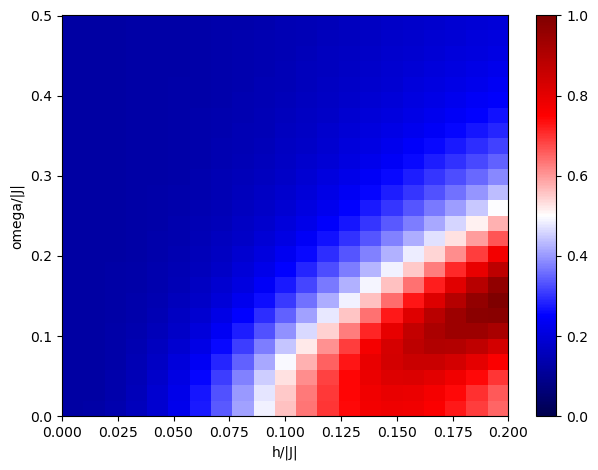

In [ ]:
PyPlot.imshow(abs.(Gf_mat_t)/nm,vmin=0, vmax=1, cmap="seismic",origin="lower",aspect = "auto", extent=(-0.00001,0.200001,-0.00001,0.500001))
PyPlot.xlabel("h/|J|")
PyPlot.ylabel("omega/|J|")
PyPlot.colorbar()
PyPlot.tight_layout()
PyPlot.display_figs()
PyPlot.show()

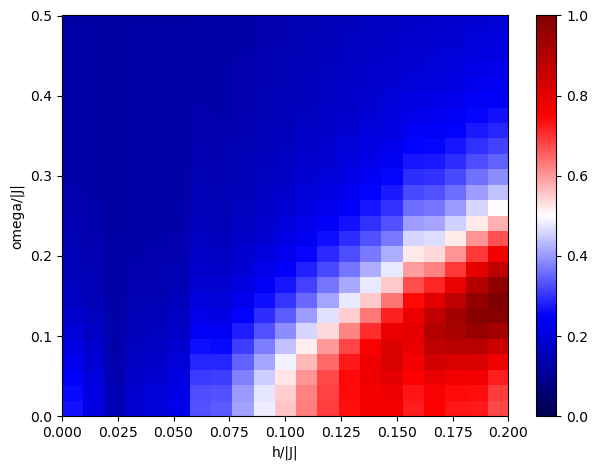

In [ ]:
PyPlot.imshow(abs.(Gf_mat2_t)/nm2,vmin=0, vmax=1, cmap="seismic",origin="lower",aspect = "auto", extent=(-0.00001,0.200001,-0.00001,0.500001))
PyPlot.xlabel("h/|J|")
PyPlot.ylabel("omega/|J|")
PyPlot.colorbar()
PyPlot.tight_layout()
PyPlot.display_figs()
PyPlot.show()

In [ ]:
dsf = DSF_exact_nn_range_freqs(Lx,Lz,BC,J,0.1,0:0.1:10,type)

101-element Vector{Any}:
 -0.08620100194627414
 -0.02934535607209054
 -0.0069195888314278736
 -0.004759374962117112
 -0.004090604076996036
 -0.0038176610222207257
 -0.003701612155233459
 -0.0036661007510220022
 -0.0036824943527542287
 -0.003741532519564566
  ⋮
 -0.00403947828418395
 -0.0038178923178179345
 -0.0036152908581501466
 -0.0034294600001808285
 -0.003258513830453932
 -0.0031008353507003057
 -0.0029550299179337087
 -0.002819888164029481
 -0.0026943561832579307

In [ ]:
Lx = 1
Lz = 1
BC = 1
J = -1.0
hz = 0.1
n_l = 3
n_k = 3
r=5
n_l2 = 3
n_k2 = 3
r2=5
nkryl = 100
z = 0.5+0.01im
order = 2
type = 1 #Type 1: magnetic field in z direction. Type 2: uniform magnetic field
SIGN = 1 #1: cdag = cβ, 2: cdag = cα, 3: cdag = cα+cβ, 4: cdag = cα + i*cβ 
global α = 1
global β = 2
global γ = 3
n,Jxyz,hmagn,h,ham,ham_norm,kappa=output_ham_properties(Lx, Lz, BC, J, hz, type);

We consider n = 8 qubits


In [ ]:
XXbonds, YYbonds, ZZbonds = edges(Lx, Lz, BC);
ZZbonds

4-element Vector{Vector{Int64}}:
 [1, 8]
 [5, 4]
 [3, 6]
 [7, 2]

In [ ]:
ω = collect(0:0.1:10)
z2,gfe_r,gfe_i,gfc_r,gfc_i,gft_r,gft_i = compare_GFS(Lx, Lz, BC, J, hz, n_l, n_k, r, n_l2, n_k2,r2,nkryl,α,β,γ,ω,order,type)

n_l=3, n_k=3, r=5, n_l2=3, n_k2=3, r2=5
We consider n = 8 qubits
We consider n = 8 qubits
Eground = -7.034524318395797

┌ Info: Lanczos eigsolve finished after 1 iterations:
│ *  5 eigenvalues converged
│ *  norm of residuals = (3.5119802940857675e-44, 0.0, 0.0, 0.0, 2.0975013413800337e-14)
│ *  number of operations = 128
└ @ KrylovKit C:\Users\cu234\.julia\packages\KrylovKit\wPepJ\src\eigsolve\lanczos.jl:143



 >>exc>> 5 Y 
 >>exc>> 7 Y 
1
2
3
4
GS prepared, ΔE=2.930988785010413e-14
We consider n = 8 qubits
We consider n = 8 qubits
We consider n = 8 qubits
Eground = -0.1264973086360069
 >>exc>> 5 Y 
 >>exc>> 7 Y 


┌ Info: Lanczos eigsolve finished after 1 iterations:
│ *  7 eigenvalues converged
│ *  norm of residuals = (1.2007359770639042e-45, 0.0, 0.0, 0.0, 1.7600735800686895e-14, 1.5987154819991948e-14, 3.3024958903541463e-13)
│ *  number of operations = 128
└ @ KrylovKit C:\Users\cu234\.julia\packages\KrylovKit\wPepJ\src\eigsolve\lanczos.jl:143


n_k,n_l =(3, 3)
 Smat Pos-def? false
 Hmat Hermitian? true


sys:1: UserWarning: The problem size 31 minus the constraints size 0 is too small relative to the block size 31. Using a dense eigensolver instead of LOBPCG.


PyCall.PyError: PyError ($(Expr(:escape, :(ccall(#= C:\Users\cu234\.julia\packages\PyCall\1gn3u\src\pyfncall.jl:43 =# @pysym(:PyObject_Call), PyPtr, (PyPtr, PyPtr, PyPtr), o, pyargsptr, kw))))) <class 'numpy.linalg.LinAlgError'>
LinAlgError('The leading minor of order 8 of B is not positive definite. The factorization of B could not be completed and no eigenvalues or eigenvectors were computed.')
  File "C:\Users\cu234\.julia\conda\3\lib\site-packages\scipy\sparse\linalg\_eigen\lobpcg\lobpcg.py", line 386, in lobpcg
    vals, vecs = eigh(A,
  File "C:\Users\cu234\.julia\conda\3\lib\site-packages\scipy\linalg\_decomp.py", line 580, in eigh
    raise LinAlgError('The leading minor of order {} of B is not '


In [ ]:
PyPlot.plot(z2,gfe_r,label="Exact GF")
PyPlot.plot(z2,gfc_r,"--",label="Calculated GF")
PyPlot.plot(z2,gft_r,":",label="Trotter GF - 5 steps")
PyPlot.xlabel("ω")
PyPlot.ylabel("Re[G(ω+iδ)]")
PyPlot.legend()
PyPlot.display_figs()
PyPlot.show()

UndefVarError: UndefVarError: `z2` not defined

In [ ]:
-1/pi*gfe_i[16]

1.534716451582148

In [ ]:
inv1 = inv((1.5+0.01im)*I-Matrix(h))
inv2 = pinv((1.5+0.01im)*I-Matrix(h))
inv1 ≈ inv2

true

In [ ]:
c = creation_op(n,2,α,β,γ)
cd = creation_op(n,1,α,β,γ)
cp = creation_op(n,3,α,β,γ)
cim = creation_op(n,4,α,β,γ)
GS=GS_imag_evol(Lx,Lz,BC,J,hz,type)

We consider n = 8 qubits
Eground = -7.034524318395797
 >>exc>> 5 Y 
 >>exc>> 7 Y 
1
2
3
4


┌ Info: Lanczos eigsolve finished after 1 iterations:
│ *  6 eigenvalues converged
│ *  norm of residuals = (2.500316773594871e-44, 0.0, 0.0, 0.0, 4.4917762554072037e-14, 8.654632841503515e-13)
│ *  number of operations = 128
└ @ KrylovKit C:\Users\cu234\.julia\packages\KrylovKit\r8GLV\src\eigsolve\lanczos.jl:143


GS prepared, ΔE=2.7533531010703882e-14


ArrayReg{2, ComplexF64, Array...}
    active qubits: 8/8
    nlevel: 2

In [ ]:
gg = state(GS)'*Matrix(c)*inv((5.6+0.1im)*I-Matrix(h))*Matrix(cd)*state(GS)
gl = state(GS)'*Matrix(c)*inv((5.6+0.1im)*I+Matrix(h))*Matrix(cd)*state(GS)
gg

1×1 Matrix{ComplexF64}:
 0.02955635718859494 - 0.0002900787683494684im

In [ ]:
g1 = state(GS)'*Matrix(cp)*inv((5.6+0.1im)*I-Matrix(h))*Matrix(cp)*state(GS)
g2 = state(GS)'*Matrix(cim')*inv((5.6+0.1im)*I-Matrix(h))*Matrix(cim)*state(GS)
gi = state(GS)'*Matrix(c)*inv((5.6+0.1im)*I-Matrix(h))*Matrix(c)*state(GS)
gj = state(GS)'*Matrix(cd)*inv((5.6+0.1im)*I-Matrix(h))*Matrix(cd)*state(GS)


1×1 Matrix{ComplexF64}:
 0.09945270360996537 - 0.0010393467233359012im

In [ ]:
0.5(g1-im*g2+(im-1)*(gi+gj)) ≈ gg

true

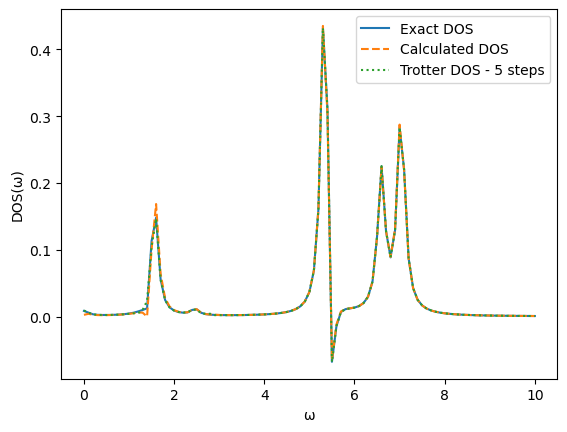

In [ ]:
DOS_e = -1/pi*gfe_i
DOS_c = -1/pi*gfc_i
DOS_t = -1/pi*gft_i

PyPlot.plot(z2,DOS_e,label="Exact DOS")
PyPlot.plot(z2,DOS_c,"--",label="Calculated DOS")
PyPlot.plot(z2,DOS_t,":",label="Trotter DOS - 5 steps")
PyPlot.xlabel("ω")
PyPlot.ylabel("DOS(ω)")
PyPlot.legend()
PyPlot.display_figs()
PyPlot.show()

In [ ]:
using LinearAlgebra
eigvals(Matrix(h))

256-element Vector{Float64}:
 -7.034524318395798
 -6.629430684742267
 -6.597056843954373
 -6.486140309240599
 -6.166177298138037
 -6.166177298138006
 -6.074479479552757
 -6.074479479552715
 -5.86545841960566
 -5.825338778089911
  ⋮
  5.819243220948818
  5.822389658001167
  5.822389658001186
  5.846891036931344
  5.846891036931347
  6.475564556284324
  6.479517425765436
  6.48614030924059
  6.934505244241335

In [ ]:
open("./data/N=$(n)_h=$(hz)_n_l=$(n_l)_n_k=$(n_k)_r=$(r)_J=$(J)_G_$(α)$(β)^$(γ).dat", "w") do io
    writedlm(io, [gfe_r,gfe_i,gfc_r,gfc_i,gft_r,gft_i])
end